In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4272856, 828)
(4272856, 8)
validation
(622688, 828)
(622688, 8)
test
(494648, 828)
(494648, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/428 [..............................] - ETA: 12:07 - loss: 2.3239 - STD: 0.0984 - MAE: 0.2195

  4/428 [..............................] - ETA: 10s - loss: 2.1509 - STD: 0.0554 - MAE: 0.2177  

  7/428 [..............................] - ETA: 9s - loss: 2.1248 - STD: 0.0566 - MAE: 0.2168 

 10/428 [..............................] - ETA: 9s - loss: 2.1125 - STD: 0.0540 - MAE: 0.2167

 13/428 [..............................] - ETA: 9s - loss: 2.0998 - STD: 0.0496 - MAE: 0.2167

 16/428 [>.............................] - ETA: 9s - loss: 2.0901 - STD: 0.0466 - MAE: 0.2167

 19/428 [>.............................] - ETA: 9s - loss: 2.0847 - STD: 0.0450 - MAE: 0.2166

 22/428 [>.............................] - ETA: 9s - loss: 2.0797 - STD: 0.0432 - MAE: 0.2166

 25/428 [>.............................] - ETA: 9s - loss: 2.0747 - STD: 0.0414 - MAE: 0.2166

 28/428 [>.............................] - ETA: 8s - loss: 2.0700 - STD: 0.0403 - MAE: 0.2165

 31/428 [=>............................] - ETA: 8s - loss: 2.0643 - STD: 0.0401 - MAE: 0.2164

 34/428 [=>............................] - ETA: 8s - loss: 2.0581 - STD: 0.0402 - MAE: 0.2162

 37/428 [=>............................] - ETA: 8s - loss: 2.0504 - STD: 0.0403 - MAE: 0.2159

 40/428 [=>............................] - ETA: 8s - loss: 2.0412 - STD: 0.0412 - MAE: 0.2155

 43/428 [==>...........................] - ETA: 8s - loss: 2.0316 - STD: 0.0425 - MAE: 0.2151

 46/428 [==>...........................] - ETA: 8s - loss: 2.0217 - STD: 0.0443 - MAE: 0.2146

 49/428 [==>...........................] - ETA: 8s - loss: 2.0116 - STD: 0.0461 - MAE: 0.2141

 52/428 [==>...........................] - ETA: 8s - loss: 2.0017 - STD: 0.0479 - MAE: 0.2136

 55/428 [==>...........................] - ETA: 8s - loss: 1.9919 - STD: 0.0497 - MAE: 0.2131

 58/428 [===>..........................] - ETA: 8s - loss: 1.9823 - STD: 0.0514 - MAE: 0.2126

 61/428 [===>..........................] - ETA: 8s - loss: 1.9728 - STD: 0.0528 - MAE: 0.2122

 64/428 [===>..........................] - ETA: 8s - loss: 1.9635 - STD: 0.0543 - MAE: 0.2117

 67/428 [===>..........................] - ETA: 8s - loss: 1.9542 - STD: 0.0557 - MAE: 0.2113

 70/428 [===>..........................] - ETA: 8s - loss: 1.9447 - STD: 0.0572 - MAE: 0.2108

 73/428 [====>.........................] - ETA: 8s - loss: 1.9351 - STD: 0.0586 - MAE: 0.2103

 76/428 [====>.........................] - ETA: 8s - loss: 1.9253 - STD: 0.0600 - MAE: 0.2099

 79/428 [====>.........................] - ETA: 7s - loss: 1.9153 - STD: 0.0613 - MAE: 0.2094

 82/428 [====>.........................] - ETA: 7s - loss: 1.9054 - STD: 0.0626 - MAE: 0.2089

 85/428 [====>.........................] - ETA: 7s - loss: 1.8952 - STD: 0.0640 - MAE: 0.2084

 88/428 [=====>........................] - ETA: 7s - loss: 1.8849 - STD: 0.0654 - MAE: 0.2078

 89/428 [=====>........................] - ETA: 10s - loss: 1.8839 - STD: 0.0659 - MAE: 0.2076

 92/428 [=====>........................] - ETA: 10s - loss: 1.8733 - STD: 0.0674 - MAE: 0.2070

 95/428 [=====>........................] - ETA: 10s - loss: 1.8629 - STD: 0.0690 - MAE: 0.2064

 98/428 [=====>........................] - ETA: 10s - loss: 1.8526 - STD: 0.0707 - MAE: 0.2058

101/428 [======>.......................] - ETA: 10s - loss: 1.8428 - STD: 0.0723 - MAE: 0.2051

104/428 [======>.......................] - ETA: 9s - loss: 1.8329 - STD: 0.0738 - MAE: 0.2045 

107/428 [======>.......................] - ETA: 9s - loss: 1.8233 - STD: 0.0754 - MAE: 0.2039

110/428 [======>.......................] - ETA: 9s - loss: 1.8138 - STD: 0.0769 - MAE: 0.2032

113/428 [======>.......................] - ETA: 9s - loss: 1.8043 - STD: 0.0785 - MAE: 0.2026

116/428 [=======>......................] - ETA: 9s - loss: 1.7949 - STD: 0.0800 - MAE: 0.2020

119/428 [=======>......................] - ETA: 9s - loss: 1.7857 - STD: 0.0814 - MAE: 0.2013

122/428 [=======>......................] - ETA: 8s - loss: 1.7766 - STD: 0.0829 - MAE: 0.2007

125/428 [=======>......................] - ETA: 8s - loss: 1.7678 - STD: 0.0843 - MAE: 0.2001

128/428 [=======>......................] - ETA: 8s - loss: 1.7594 - STD: 0.0857 - MAE: 0.1995

131/428 [========>.....................] - ETA: 8s - loss: 1.7509 - STD: 0.0871 - MAE: 0.1989

134/428 [========>.....................] - ETA: 8s - loss: 1.7426 - STD: 0.0884 - MAE: 0.1983

137/428 [========>.....................] - ETA: 8s - loss: 1.7344 - STD: 0.0898 - MAE: 0.1977

140/428 [========>.....................] - ETA: 8s - loss: 1.7265 - STD: 0.0910 - MAE: 0.1971

142/428 [========>.....................] - ETA: 8s - loss: 1.7212 - STD: 0.0919 - MAE: 0.1967

145/428 [=========>....................] - ETA: 8s - loss: 1.7135 - STD: 0.0932 - MAE: 0.1962

148/428 [=========>....................] - ETA: 7s - loss: 1.7064 - STD: 0.0944 - MAE: 0.1956

150/428 [=========>....................] - ETA: 7s - loss: 1.7015 - STD: 0.0952 - MAE: 0.1953

153/428 [=========>....................] - ETA: 7s - loss: 1.6944 - STD: 0.0964 - MAE: 0.1947

156/428 [=========>....................] - ETA: 7s - loss: 1.6874 - STD: 0.0975 - MAE: 0.1942

159/428 [==========>...................] - ETA: 7s - loss: 1.6807 - STD: 0.0987 - MAE: 0.1937

162/428 [==========>...................] - ETA: 7s - loss: 1.6740 - STD: 0.0998 - MAE: 0.1931

165/428 [==========>...................] - ETA: 7s - loss: 1.6676 - STD: 0.1009 - MAE: 0.1926

168/428 [==========>...................] - ETA: 7s - loss: 1.6614 - STD: 0.1019 - MAE: 0.1921

171/428 [==========>...................] - ETA: 7s - loss: 1.6553 - STD: 0.1030 - MAE: 0.1917

174/428 [===========>..................] - ETA: 6s - loss: 1.6493 - STD: 0.1040 - MAE: 0.1912

177/428 [===========>..................] - ETA: 6s - loss: 1.6434 - STD: 0.1050 - MAE: 0.1907

180/428 [===========>..................] - ETA: 6s - loss: 1.6376 - STD: 0.1059 - MAE: 0.1903

183/428 [===========>..................] - ETA: 6s - loss: 1.6321 - STD: 0.1069 - MAE: 0.1898

186/428 [============>.................] - ETA: 6s - loss: 1.6267 - STD: 0.1078 - MAE: 0.1894

189/428 [============>.................] - ETA: 6s - loss: 1.6214 - STD: 0.1087 - MAE: 0.1890

191/428 [============>.................] - ETA: 6s - loss: 1.6180 - STD: 0.1093 - MAE: 0.1887

194/428 [============>.................] - ETA: 6s - loss: 1.6131 - STD: 0.1102 - MAE: 0.1883

197/428 [============>.................] - ETA: 6s - loss: 1.6081 - STD: 0.1110 - MAE: 0.1879

200/428 [=============>................] - ETA: 6s - loss: 1.6033 - STD: 0.1118 - MAE: 0.1875

203/428 [=============>................] - ETA: 6s - loss: 1.5984 - STD: 0.1126 - MAE: 0.1871

206/428 [=============>................] - ETA: 5s - loss: 1.5937 - STD: 0.1135 - MAE: 0.1867

209/428 [=============>................] - ETA: 5s - loss: 1.5891 - STD: 0.1142 - MAE: 0.1863

212/428 [=============>................] - ETA: 5s - loss: 1.5845 - STD: 0.1150 - MAE: 0.1859

215/428 [==============>...............] - ETA: 5s - loss: 1.5801 - STD: 0.1158 - MAE: 0.1856

218/428 [==============>...............] - ETA: 5s - loss: 1.5759 - STD: 0.1165 - MAE: 0.1852

221/428 [==============>...............] - ETA: 5s - loss: 1.5717 - STD: 0.1172 - MAE: 0.1849

224/428 [==============>...............] - ETA: 5s - loss: 1.5676 - STD: 0.1179 - MAE: 0.1845

227/428 [==============>...............] - ETA: 5s - loss: 1.5637 - STD: 0.1186 - MAE: 0.1842

230/428 [===============>..............] - ETA: 5s - loss: 1.5598 - STD: 0.1193 - MAE: 0.1839

233/428 [===============>..............] - ETA: 5s - loss: 1.5559 - STD: 0.1200 - MAE: 0.1836

236/428 [===============>..............] - ETA: 5s - loss: 1.5522 - STD: 0.1206 - MAE: 0.1832

239/428 [===============>..............] - ETA: 4s - loss: 1.5486 - STD: 0.1213 - MAE: 0.1829

242/428 [===============>..............] - ETA: 4s - loss: 1.5448 - STD: 0.1219 - MAE: 0.1826

245/428 [================>.............] - ETA: 4s - loss: 1.5412 - STD: 0.1225 - MAE: 0.1823

248/428 [================>.............] - ETA: 4s - loss: 1.5379 - STD: 0.1231 - MAE: 0.1820

251/428 [================>.............] - ETA: 4s - loss: 1.5345 - STD: 0.1237 - MAE: 0.1817

254/428 [================>.............] - ETA: 4s - loss: 1.5312 - STD: 0.1243 - MAE: 0.1815

257/428 [=================>............] - ETA: 4s - loss: 1.5278 - STD: 0.1249 - MAE: 0.1812

260/428 [=================>............] - ETA: 4s - loss: 1.5245 - STD: 0.1254 - MAE: 0.1809

263/428 [=================>............] - ETA: 4s - loss: 1.5212 - STD: 0.1259 - MAE: 0.1806

266/428 [=================>............] - ETA: 4s - loss: 1.5179 - STD: 0.1265 - MAE: 0.1803

269/428 [=================>............] - ETA: 4s - loss: 1.5146 - STD: 0.1270 - MAE: 0.1801

272/428 [==================>...........] - ETA: 4s - loss: 1.5115 - STD: 0.1276 - MAE: 0.1798

275/428 [==================>...........] - ETA: 3s - loss: 1.5084 - STD: 0.1281 - MAE: 0.1795

278/428 [==================>...........] - ETA: 3s - loss: 1.5054 - STD: 0.1286 - MAE: 0.1793

281/428 [==================>...........] - ETA: 3s - loss: 1.5024 - STD: 0.1291 - MAE: 0.1790

284/428 [==================>...........] - ETA: 3s - loss: 1.4994 - STD: 0.1296 - MAE: 0.1788

287/428 [===================>..........] - ETA: 3s - loss: 1.4965 - STD: 0.1301 - MAE: 0.1785

290/428 [===================>..........] - ETA: 3s - loss: 1.4936 - STD: 0.1306 - MAE: 0.1783

293/428 [===================>..........] - ETA: 3s - loss: 1.4908 - STD: 0.1311 - MAE: 0.1780

296/428 [===================>..........] - ETA: 3s - loss: 1.4880 - STD: 0.1316 - MAE: 0.1778

299/428 [===================>..........] - ETA: 3s - loss: 1.4852 - STD: 0.1320 - MAE: 0.1775

302/428 [====================>.........] - ETA: 3s - loss: 1.4826 - STD: 0.1325 - MAE: 0.1773

305/428 [====================>.........] - ETA: 3s - loss: 1.4799 - STD: 0.1329 - MAE: 0.1770

308/428 [====================>.........] - ETA: 3s - loss: 1.4772 - STD: 0.1334 - MAE: 0.1768

311/428 [====================>.........] - ETA: 3s - loss: 1.4746 - STD: 0.1338 - MAE: 0.1766

314/428 [=====================>........] - ETA: 2s - loss: 1.4721 - STD: 0.1343 - MAE: 0.1764

317/428 [=====================>........] - ETA: 2s - loss: 1.4695 - STD: 0.1347 - MAE: 0.1761

320/428 [=====================>........] - ETA: 2s - loss: 1.4670 - STD: 0.1351 - MAE: 0.1759

323/428 [=====================>........] - ETA: 2s - loss: 1.4645 - STD: 0.1355 - MAE: 0.1757

326/428 [=====================>........] - ETA: 2s - loss: 1.4620 - STD: 0.1359 - MAE: 0.1755

329/428 [======================>.......] - ETA: 2s - loss: 1.4595 - STD: 0.1363 - MAE: 0.1753

332/428 [======================>.......] - ETA: 2s - loss: 1.4572 - STD: 0.1368 - MAE: 0.1750

335/428 [======================>.......] - ETA: 2s - loss: 1.4549 - STD: 0.1371 - MAE: 0.1748

338/428 [======================>.......] - ETA: 2s - loss: 1.4526 - STD: 0.1375 - MAE: 0.1746

341/428 [======================>.......] - ETA: 2s - loss: 1.4503 - STD: 0.1379 - MAE: 0.1744

344/428 [=======================>......] - ETA: 2s - loss: 1.4481 - STD: 0.1383 - MAE: 0.1742

347/428 [=======================>......] - ETA: 2s - loss: 1.4459 - STD: 0.1387 - MAE: 0.1740

350/428 [=======================>......] - ETA: 1s - loss: 1.4437 - STD: 0.1391 - MAE: 0.1738

353/428 [=======================>......] - ETA: 1s - loss: 1.4415 - STD: 0.1394 - MAE: 0.1736

356/428 [=======================>......] - ETA: 1s - loss: 1.4395 - STD: 0.1398 - MAE: 0.1735

359/428 [========================>.....] - ETA: 1s - loss: 1.4374 - STD: 0.1401 - MAE: 0.1733

362/428 [========================>.....] - ETA: 1s - loss: 1.4354 - STD: 0.1405 - MAE: 0.1731

365/428 [========================>.....] - ETA: 1s - loss: 1.4332 - STD: 0.1409 - MAE: 0.1729

368/428 [========================>.....] - ETA: 1s - loss: 1.4311 - STD: 0.1412 - MAE: 0.1727

371/428 [=========================>....] - ETA: 1s - loss: 1.4292 - STD: 0.1416 - MAE: 0.1725

374/428 [=========================>....] - ETA: 1s - loss: 1.4271 - STD: 0.1419 - MAE: 0.1723

377/428 [=========================>....] - ETA: 1s - loss: 1.4251 - STD: 0.1422 - MAE: 0.1721

380/428 [=========================>....] - ETA: 1s - loss: 1.4232 - STD: 0.1426 - MAE: 0.1720

383/428 [=========================>....] - ETA: 1s - loss: 1.4213 - STD: 0.1429 - MAE: 0.1718

386/428 [==========================>...] - ETA: 1s - loss: 1.4194 - STD: 0.1432 - MAE: 0.1716

389/428 [==========================>...] - ETA: 0s - loss: 1.4174 - STD: 0.1435 - MAE: 0.1714

392/428 [==========================>...] - ETA: 0s - loss: 1.4154 - STD: 0.1438 - MAE: 0.1713

395/428 [==========================>...] - ETA: 0s - loss: 1.4137 - STD: 0.1442 - MAE: 0.1711

398/428 [==========================>...] - ETA: 0s - loss: 1.4118 - STD: 0.1445 - MAE: 0.1709

401/428 [===========================>..] - ETA: 0s - loss: 1.4100 - STD: 0.1448 - MAE: 0.1708

404/428 [===========================>..] - ETA: 0s - loss: 1.4082 - STD: 0.1451 - MAE: 0.1706

407/428 [===========================>..] - ETA: 0s - loss: 1.4065 - STD: 0.1454 - MAE: 0.1704

410/428 [===========================>..] - ETA: 0s - loss: 1.4047 - STD: 0.1457 - MAE: 0.1703

413/428 [===========================>..] - ETA: 0s - loss: 1.4029 - STD: 0.1460 - MAE: 0.1701

416/428 [============================>.] - ETA: 0s - loss: 1.4011 - STD: 0.1463 - MAE: 0.1699

419/428 [============================>.] - ETA: 0s - loss: 1.3993 - STD: 0.1466 - MAE: 0.1698

422/428 [============================>.] - ETA: 0s - loss: 1.3975 - STD: 0.1469 - MAE: 0.1696

425/428 [============================>.] - ETA: 0s - loss: 1.3958 - STD: 0.1471 - MAE: 0.1695

428/428 [==============================] - ETA: 0s - loss: 1.3941 - STD: 0.1474 - MAE: 0.1693

428/428 [==============================] - 14s 29ms/step - loss: 1.3941 - STD: 0.1474 - MAE: 0.1693 - val_loss: 1.2235 - val_STD: 0.1851 - val_MAE: 0.1498


Epoch 2/10000


  1/428 [..............................] - ETA: 25s - loss: 1.1416 - STD: 0.1866 - MAE: 0.1467

  4/428 [..............................] - ETA: 10s - loss: 1.1532 - STD: 0.1868 - MAE: 0.1472

  7/428 [..............................] - ETA: 9s - loss: 1.1524 - STD: 0.1876 - MAE: 0.1469 

 10/428 [..............................] - ETA: 9s - loss: 1.1614 - STD: 0.1876 - MAE: 0.1473

 13/428 [..............................] - ETA: 9s - loss: 1.1602 - STD: 0.1878 - MAE: 0.1471

 16/428 [>.............................] - ETA: 9s - loss: 1.1578 - STD: 0.1878 - MAE: 0.1470

 19/428 [>.............................] - ETA: 9s - loss: 1.1583 - STD: 0.1879 - MAE: 0.1470

 22/428 [>.............................] - ETA: 9s - loss: 1.1618 - STD: 0.1881 - MAE: 0.1471

 25/428 [>.............................] - ETA: 9s - loss: 1.1616 - STD: 0.1882 - MAE: 0.1471

 28/428 [>.............................] - ETA: 9s - loss: 1.1601 - STD: 0.1882 - MAE: 0.1470

 31/428 [=>............................] - ETA: 9s - loss: 1.1583 - STD: 0.1884 - MAE: 0.1468

 34/428 [=>............................] - ETA: 9s - loss: 1.1586 - STD: 0.1884 - MAE: 0.1469

 37/428 [=>............................] - ETA: 9s - loss: 1.1579 - STD: 0.1884 - MAE: 0.1468

 40/428 [=>............................] - ETA: 9s - loss: 1.1574 - STD: 0.1885 - MAE: 0.1468

 43/428 [==>...........................] - ETA: 9s - loss: 1.1568 - STD: 0.1885 - MAE: 0.1467

 46/428 [==>...........................] - ETA: 9s - loss: 1.1557 - STD: 0.1886 - MAE: 0.1466

 49/428 [==>...........................] - ETA: 8s - loss: 1.1547 - STD: 0.1886 - MAE: 0.1465

 52/428 [==>...........................] - ETA: 8s - loss: 1.1541 - STD: 0.1886 - MAE: 0.1465

 55/428 [==>...........................] - ETA: 8s - loss: 1.1535 - STD: 0.1887 - MAE: 0.1465

 58/428 [===>..........................] - ETA: 8s - loss: 1.1531 - STD: 0.1887 - MAE: 0.1464

 61/428 [===>..........................] - ETA: 8s - loss: 1.1519 - STD: 0.1888 - MAE: 0.1463

 64/428 [===>..........................] - ETA: 8s - loss: 1.1507 - STD: 0.1889 - MAE: 0.1462

 67/428 [===>..........................] - ETA: 8s - loss: 1.1499 - STD: 0.1889 - MAE: 0.1462

 70/428 [===>..........................] - ETA: 8s - loss: 1.1495 - STD: 0.1889 - MAE: 0.1461

 73/428 [====>.........................] - ETA: 8s - loss: 1.1496 - STD: 0.1890 - MAE: 0.1461

 76/428 [====>.........................] - ETA: 8s - loss: 1.1493 - STD: 0.1891 - MAE: 0.1461

 79/428 [====>.........................] - ETA: 8s - loss: 1.1494 - STD: 0.1891 - MAE: 0.1460

 82/428 [====>.........................] - ETA: 8s - loss: 1.1491 - STD: 0.1892 - MAE: 0.1460

 85/428 [====>.........................] - ETA: 7s - loss: 1.1485 - STD: 0.1892 - MAE: 0.1460

 88/428 [=====>........................] - ETA: 7s - loss: 1.1477 - STD: 0.1893 - MAE: 0.1459

 91/428 [=====>........................] - ETA: 7s - loss: 1.1467 - STD: 0.1893 - MAE: 0.1458

 94/428 [=====>........................] - ETA: 7s - loss: 1.1457 - STD: 0.1894 - MAE: 0.1458

 97/428 [=====>........................] - ETA: 7s - loss: 1.1450 - STD: 0.1895 - MAE: 0.1457

100/428 [======>.......................] - ETA: 7s - loss: 1.1442 - STD: 0.1895 - MAE: 0.1456

103/428 [======>.......................] - ETA: 7s - loss: 1.1434 - STD: 0.1896 - MAE: 0.1455

106/428 [======>.......................] - ETA: 7s - loss: 1.1423 - STD: 0.1897 - MAE: 0.1454

109/428 [======>.......................] - ETA: 7s - loss: 1.1415 - STD: 0.1897 - MAE: 0.1454

112/428 [======>.......................] - ETA: 7s - loss: 1.1407 - STD: 0.1898 - MAE: 0.1453

115/428 [=======>......................] - ETA: 7s - loss: 1.1399 - STD: 0.1899 - MAE: 0.1452

118/428 [=======>......................] - ETA: 7s - loss: 1.1390 - STD: 0.1900 - MAE: 0.1451

121/428 [=======>......................] - ETA: 7s - loss: 1.1386 - STD: 0.1901 - MAE: 0.1451

124/428 [=======>......................] - ETA: 7s - loss: 1.1378 - STD: 0.1902 - MAE: 0.1450

127/428 [=======>......................] - ETA: 6s - loss: 1.1369 - STD: 0.1903 - MAE: 0.1449

130/428 [========>.....................] - ETA: 6s - loss: 1.1361 - STD: 0.1904 - MAE: 0.1449

133/428 [========>.....................] - ETA: 6s - loss: 1.1353 - STD: 0.1904 - MAE: 0.1448

136/428 [========>.....................] - ETA: 6s - loss: 1.1347 - STD: 0.1905 - MAE: 0.1447

139/428 [========>.....................] - ETA: 6s - loss: 1.1349 - STD: 0.1906 - MAE: 0.1447

142/428 [========>.....................] - ETA: 6s - loss: 1.1343 - STD: 0.1907 - MAE: 0.1446

145/428 [=========>....................] - ETA: 6s - loss: 1.1341 - STD: 0.1908 - MAE: 0.1446

148/428 [=========>....................] - ETA: 6s - loss: 1.1335 - STD: 0.1909 - MAE: 0.1445

151/428 [=========>....................] - ETA: 6s - loss: 1.1333 - STD: 0.1910 - MAE: 0.1445

154/428 [=========>....................] - ETA: 6s - loss: 1.1330 - STD: 0.1910 - MAE: 0.1444

157/428 [==========>...................] - ETA: 6s - loss: 1.1322 - STD: 0.1911 - MAE: 0.1443

160/428 [==========>...................] - ETA: 6s - loss: 1.1315 - STD: 0.1912 - MAE: 0.1443

163/428 [==========>...................] - ETA: 6s - loss: 1.1312 - STD: 0.1913 - MAE: 0.1442

166/428 [==========>...................] - ETA: 6s - loss: 1.1308 - STD: 0.1913 - MAE: 0.1442

169/428 [==========>...................] - ETA: 5s - loss: 1.1303 - STD: 0.1914 - MAE: 0.1441

172/428 [===========>..................] - ETA: 5s - loss: 1.1297 - STD: 0.1915 - MAE: 0.1441

175/428 [===========>..................] - ETA: 5s - loss: 1.1291 - STD: 0.1915 - MAE: 0.1440

178/428 [===========>..................] - ETA: 5s - loss: 1.1283 - STD: 0.1916 - MAE: 0.1439

181/428 [===========>..................] - ETA: 5s - loss: 1.1276 - STD: 0.1917 - MAE: 0.1439

184/428 [===========>..................] - ETA: 5s - loss: 1.1271 - STD: 0.1918 - MAE: 0.1438

187/428 [============>.................] - ETA: 5s - loss: 1.1265 - STD: 0.1918 - MAE: 0.1438

190/428 [============>.................] - ETA: 5s - loss: 1.1260 - STD: 0.1919 - MAE: 0.1437

193/428 [============>.................] - ETA: 5s - loss: 1.1253 - STD: 0.1920 - MAE: 0.1436

196/428 [============>.................] - ETA: 5s - loss: 1.1247 - STD: 0.1920 - MAE: 0.1436

198/428 [============>.................] - ETA: 5s - loss: 1.1244 - STD: 0.1921 - MAE: 0.1435

200/428 [=============>................] - ETA: 5s - loss: 1.1239 - STD: 0.1921 - MAE: 0.1435

202/428 [=============>................] - ETA: 5s - loss: 1.1235 - STD: 0.1922 - MAE: 0.1434

204/428 [=============>................] - ETA: 5s - loss: 1.1231 - STD: 0.1922 - MAE: 0.1434

206/428 [=============>................] - ETA: 5s - loss: 1.1229 - STD: 0.1923 - MAE: 0.1434

209/428 [=============>................] - ETA: 5s - loss: 1.1225 - STD: 0.1923 - MAE: 0.1433

211/428 [=============>................] - ETA: 5s - loss: 1.1221 - STD: 0.1924 - MAE: 0.1433

213/428 [=============>................] - ETA: 5s - loss: 1.1220 - STD: 0.1924 - MAE: 0.1433

216/428 [==============>...............] - ETA: 4s - loss: 1.1225 - STD: 0.1925 - MAE: 0.1433

218/428 [==============>...............] - ETA: 4s - loss: 1.1224 - STD: 0.1926 - MAE: 0.1432

220/428 [==============>...............] - ETA: 4s - loss: 1.1226 - STD: 0.1926 - MAE: 0.1432

222/428 [==============>...............] - ETA: 4s - loss: 1.1223 - STD: 0.1927 - MAE: 0.1432

224/428 [==============>...............] - ETA: 4s - loss: 1.1223 - STD: 0.1927 - MAE: 0.1432

226/428 [==============>...............] - ETA: 4s - loss: 1.1222 - STD: 0.1928 - MAE: 0.1431

228/428 [==============>...............] - ETA: 4s - loss: 1.1219 - STD: 0.1928 - MAE: 0.1431

231/428 [===============>..............] - ETA: 4s - loss: 1.1217 - STD: 0.1929 - MAE: 0.1431

233/428 [===============>..............] - ETA: 4s - loss: 1.1216 - STD: 0.1929 - MAE: 0.1430

235/428 [===============>..............] - ETA: 4s - loss: 1.1214 - STD: 0.1930 - MAE: 0.1430

237/428 [===============>..............] - ETA: 4s - loss: 1.1213 - STD: 0.1930 - MAE: 0.1430

239/428 [===============>..............] - ETA: 4s - loss: 1.1212 - STD: 0.1930 - MAE: 0.1430

241/428 [===============>..............] - ETA: 4s - loss: 1.1212 - STD: 0.1930 - MAE: 0.1430

243/428 [================>.............] - ETA: 4s - loss: 1.1210 - STD: 0.1931 - MAE: 0.1430

245/428 [================>.............] - ETA: 4s - loss: 1.1208 - STD: 0.1931 - MAE: 0.1429

247/428 [================>.............] - ETA: 4s - loss: 1.1205 - STD: 0.1931 - MAE: 0.1429

249/428 [================>.............] - ETA: 4s - loss: 1.1203 - STD: 0.1932 - MAE: 0.1429

251/428 [================>.............] - ETA: 4s - loss: 1.1199 - STD: 0.1932 - MAE: 0.1429

253/428 [================>.............] - ETA: 4s - loss: 1.1196 - STD: 0.1932 - MAE: 0.1428

256/428 [================>.............] - ETA: 4s - loss: 1.1191 - STD: 0.1933 - MAE: 0.1428

258/428 [=================>............] - ETA: 4s - loss: 1.1189 - STD: 0.1933 - MAE: 0.1428

260/428 [=================>............] - ETA: 3s - loss: 1.1186 - STD: 0.1933 - MAE: 0.1427

262/428 [=================>............] - ETA: 3s - loss: 1.1182 - STD: 0.1934 - MAE: 0.1427

265/428 [=================>............] - ETA: 3s - loss: 1.1179 - STD: 0.1934 - MAE: 0.1427

267/428 [=================>............] - ETA: 3s - loss: 1.1178 - STD: 0.1934 - MAE: 0.1426

270/428 [=================>............] - ETA: 3s - loss: 1.1174 - STD: 0.1935 - MAE: 0.1426

272/428 [==================>...........] - ETA: 3s - loss: 1.1171 - STD: 0.1935 - MAE: 0.1426

274/428 [==================>...........] - ETA: 3s - loss: 1.1170 - STD: 0.1936 - MAE: 0.1425

277/428 [==================>...........] - ETA: 3s - loss: 1.1167 - STD: 0.1936 - MAE: 0.1425

279/428 [==================>...........] - ETA: 3s - loss: 1.1165 - STD: 0.1937 - MAE: 0.1425

281/428 [==================>...........] - ETA: 3s - loss: 1.1163 - STD: 0.1937 - MAE: 0.1425

284/428 [==================>...........] - ETA: 3s - loss: 1.1159 - STD: 0.1937 - MAE: 0.1424

287/428 [===================>..........] - ETA: 3s - loss: 1.1155 - STD: 0.1938 - MAE: 0.1424

290/428 [===================>..........] - ETA: 3s - loss: 1.1148 - STD: 0.1938 - MAE: 0.1423

293/428 [===================>..........] - ETA: 3s - loss: 1.1144 - STD: 0.1939 - MAE: 0.1423

296/428 [===================>..........] - ETA: 3s - loss: 1.1139 - STD: 0.1939 - MAE: 0.1422

299/428 [===================>..........] - ETA: 3s - loss: 1.1134 - STD: 0.1940 - MAE: 0.1422

302/428 [====================>.........] - ETA: 2s - loss: 1.1129 - STD: 0.1940 - MAE: 0.1421

305/428 [====================>.........] - ETA: 2s - loss: 1.1125 - STD: 0.1941 - MAE: 0.1421

308/428 [====================>.........] - ETA: 2s - loss: 1.1120 - STD: 0.1942 - MAE: 0.1420

311/428 [====================>.........] - ETA: 2s - loss: 1.1119 - STD: 0.1942 - MAE: 0.1420

314/428 [=====================>........] - ETA: 2s - loss: 1.1115 - STD: 0.1943 - MAE: 0.1420

316/428 [=====================>........] - ETA: 2s - loss: 1.1113 - STD: 0.1943 - MAE: 0.1420

319/428 [=====================>........] - ETA: 2s - loss: 1.1109 - STD: 0.1944 - MAE: 0.1419

322/428 [=====================>........] - ETA: 2s - loss: 1.1106 - STD: 0.1944 - MAE: 0.1419

324/428 [=====================>........] - ETA: 2s - loss: 1.1102 - STD: 0.1945 - MAE: 0.1418

326/428 [=====================>........] - ETA: 2s - loss: 1.1100 - STD: 0.1945 - MAE: 0.1418

328/428 [=====================>........] - ETA: 2s - loss: 1.1097 - STD: 0.1945 - MAE: 0.1418

330/428 [======================>.......] - ETA: 2s - loss: 1.1096 - STD: 0.1945 - MAE: 0.1418

332/428 [======================>.......] - ETA: 2s - loss: 1.1092 - STD: 0.1946 - MAE: 0.1417

334/428 [======================>.......] - ETA: 2s - loss: 1.1089 - STD: 0.1946 - MAE: 0.1417

337/428 [======================>.......] - ETA: 2s - loss: 1.1086 - STD: 0.1947 - MAE: 0.1417

339/428 [======================>.......] - ETA: 2s - loss: 1.1084 - STD: 0.1947 - MAE: 0.1416

342/428 [======================>.......] - ETA: 2s - loss: 1.1080 - STD: 0.1948 - MAE: 0.1416

344/428 [=======================>......] - ETA: 2s - loss: 1.1077 - STD: 0.1948 - MAE: 0.1416

346/428 [=======================>......] - ETA: 1s - loss: 1.1076 - STD: 0.1948 - MAE: 0.1415

348/428 [=======================>......] - ETA: 1s - loss: 1.1073 - STD: 0.1949 - MAE: 0.1415

350/428 [=======================>......] - ETA: 1s - loss: 1.1070 - STD: 0.1949 - MAE: 0.1415

353/428 [=======================>......] - ETA: 1s - loss: 1.1066 - STD: 0.1950 - MAE: 0.1414

356/428 [=======================>......] - ETA: 1s - loss: 1.1061 - STD: 0.1950 - MAE: 0.1414

358/428 [========================>.....] - ETA: 1s - loss: 1.1058 - STD: 0.1950 - MAE: 0.1414

361/428 [========================>.....] - ETA: 1s - loss: 1.1053 - STD: 0.1951 - MAE: 0.1413

363/428 [========================>.....] - ETA: 1s - loss: 1.1050 - STD: 0.1951 - MAE: 0.1413

365/428 [========================>.....] - ETA: 1s - loss: 1.1047 - STD: 0.1952 - MAE: 0.1413

367/428 [========================>.....] - ETA: 1s - loss: 1.1044 - STD: 0.1952 - MAE: 0.1412

369/428 [========================>.....] - ETA: 1s - loss: 1.1042 - STD: 0.1953 - MAE: 0.1412

371/428 [=========================>....] - ETA: 1s - loss: 1.1038 - STD: 0.1953 - MAE: 0.1412

373/428 [=========================>....] - ETA: 1s - loss: 1.1036 - STD: 0.1953 - MAE: 0.1411

375/428 [=========================>....] - ETA: 1s - loss: 1.1033 - STD: 0.1954 - MAE: 0.1411

378/428 [=========================>....] - ETA: 1s - loss: 1.1029 - STD: 0.1954 - MAE: 0.1411

380/428 [=========================>....] - ETA: 1s - loss: 1.1026 - STD: 0.1955 - MAE: 0.1410

382/428 [=========================>....] - ETA: 1s - loss: 1.1023 - STD: 0.1955 - MAE: 0.1410

385/428 [=========================>....] - ETA: 1s - loss: 1.1021 - STD: 0.1955 - MAE: 0.1410

387/428 [==========================>...] - ETA: 0s - loss: 1.1019 - STD: 0.1956 - MAE: 0.1409

390/428 [==========================>...] - ETA: 0s - loss: 1.1016 - STD: 0.1956 - MAE: 0.1409

392/428 [==========================>...] - ETA: 0s - loss: 1.1014 - STD: 0.1957 - MAE: 0.1409

395/428 [==========================>...] - ETA: 0s - loss: 1.1011 - STD: 0.1957 - MAE: 0.1408

397/428 [==========================>...] - ETA: 0s - loss: 1.1009 - STD: 0.1958 - MAE: 0.1408

400/428 [===========================>..] - ETA: 0s - loss: 1.1005 - STD: 0.1958 - MAE: 0.1408

402/428 [===========================>..] - ETA: 0s - loss: 1.1002 - STD: 0.1958 - MAE: 0.1408

405/428 [===========================>..] - ETA: 0s - loss: 1.0998 - STD: 0.1959 - MAE: 0.1407

407/428 [===========================>..] - ETA: 0s - loss: 1.0997 - STD: 0.1959 - MAE: 0.1407

409/428 [===========================>..] - ETA: 0s - loss: 1.0995 - STD: 0.1960 - MAE: 0.1407

412/428 [===========================>..] - ETA: 0s - loss: 1.0992 - STD: 0.1960 - MAE: 0.1406

414/428 [============================>.] - ETA: 0s - loss: 1.0989 - STD: 0.1960 - MAE: 0.1406

416/428 [============================>.] - ETA: 0s - loss: 1.0987 - STD: 0.1961 - MAE: 0.1406

418/428 [============================>.] - ETA: 0s - loss: 1.0985 - STD: 0.1961 - MAE: 0.1406

421/428 [============================>.] - ETA: 0s - loss: 1.0981 - STD: 0.1962 - MAE: 0.1405

423/428 [============================>.] - ETA: 0s - loss: 1.0977 - STD: 0.1962 - MAE: 0.1405

425/428 [============================>.] - ETA: 0s - loss: 1.0975 - STD: 0.1962 - MAE: 0.1405

428/428 [==============================] - ETA: 0s - loss: 1.0971 - STD: 0.1963 - MAE: 0.1404

428/428 [==============================] - 12s 27ms/step - loss: 1.0971 - STD: 0.1963 - MAE: 0.1404 - val_loss: 1.1281 - val_STD: 0.2017 - val_MAE: 0.1390


Epoch 3/10000


  1/428 [..............................] - ETA: 21s - loss: 1.0332 - STD: 0.2045 - MAE: 0.1339

  4/428 [..............................] - ETA: 9s - loss: 1.0557 - STD: 0.2037 - MAE: 0.1354 

  7/428 [..............................] - ETA: 9s - loss: 1.0554 - STD: 0.2035 - MAE: 0.1354

 10/428 [..............................] - ETA: 9s - loss: 1.0501 - STD: 0.2035 - MAE: 0.1351

 13/428 [..............................] - ETA: 9s - loss: 1.0466 - STD: 0.2033 - MAE: 0.1349

 15/428 [>.............................] - ETA: 9s - loss: 1.0443 - STD: 0.2033 - MAE: 0.1348

 17/428 [>.............................] - ETA: 9s - loss: 1.0440 - STD: 0.2033 - MAE: 0.1348

 20/428 [>.............................] - ETA: 9s - loss: 1.0416 - STD: 0.2034 - MAE: 0.1346

 22/428 [>.............................] - ETA: 9s - loss: 1.0414 - STD: 0.2035 - MAE: 0.1346

 24/428 [>.............................] - ETA: 9s - loss: 1.0414 - STD: 0.2036 - MAE: 0.1345

 26/428 [>.............................] - ETA: 9s - loss: 1.0418 - STD: 0.2037 - MAE: 0.1345

 28/428 [>.............................] - ETA: 9s - loss: 1.0412 - STD: 0.2037 - MAE: 0.1345

 31/428 [=>............................] - ETA: 9s - loss: 1.0403 - STD: 0.2038 - MAE: 0.1344

 33/428 [=>............................] - ETA: 9s - loss: 1.0401 - STD: 0.2038 - MAE: 0.1344

 35/428 [=>............................] - ETA: 9s - loss: 1.0401 - STD: 0.2039 - MAE: 0.1343

 37/428 [=>............................] - ETA: 9s - loss: 1.0397 - STD: 0.2039 - MAE: 0.1343

 40/428 [=>............................] - ETA: 9s - loss: 1.0396 - STD: 0.2040 - MAE: 0.1343

 42/428 [=>............................] - ETA: 9s - loss: 1.0399 - STD: 0.2040 - MAE: 0.1343

 45/428 [==>...........................] - ETA: 9s - loss: 1.0394 - STD: 0.2040 - MAE: 0.1343

 47/428 [==>...........................] - ETA: 9s - loss: 1.0398 - STD: 0.2040 - MAE: 0.1343

 49/428 [==>...........................] - ETA: 9s - loss: 1.0398 - STD: 0.2041 - MAE: 0.1342

 51/428 [==>...........................] - ETA: 9s - loss: 1.0402 - STD: 0.2041 - MAE: 0.1343

 54/428 [==>...........................] - ETA: 9s - loss: 1.0396 - STD: 0.2041 - MAE: 0.1342

 56/428 [==>...........................] - ETA: 9s - loss: 1.0389 - STD: 0.2041 - MAE: 0.1342

 58/428 [===>..........................] - ETA: 9s - loss: 1.0383 - STD: 0.2042 - MAE: 0.1341

 60/428 [===>..........................] - ETA: 9s - loss: 1.0380 - STD: 0.2042 - MAE: 0.1341

 62/428 [===>..........................] - ETA: 9s - loss: 1.0373 - STD: 0.2042 - MAE: 0.1340

 64/428 [===>..........................] - ETA: 9s - loss: 1.0369 - STD: 0.2043 - MAE: 0.1340

 66/428 [===>..........................] - ETA: 8s - loss: 1.0364 - STD: 0.2043 - MAE: 0.1340

 68/428 [===>..........................] - ETA: 8s - loss: 1.0359 - STD: 0.2043 - MAE: 0.1339

 70/428 [===>..........................] - ETA: 8s - loss: 1.0355 - STD: 0.2044 - MAE: 0.1339

 72/428 [====>.........................] - ETA: 8s - loss: 1.0354 - STD: 0.2044 - MAE: 0.1339

 74/428 [====>.........................] - ETA: 8s - loss: 1.0351 - STD: 0.2045 - MAE: 0.1338

 77/428 [====>.........................] - ETA: 8s - loss: 1.0353 - STD: 0.2045 - MAE: 0.1338

 79/428 [====>.........................] - ETA: 8s - loss: 1.0349 - STD: 0.2046 - MAE: 0.1338

 81/428 [====>.........................] - ETA: 8s - loss: 1.0348 - STD: 0.2046 - MAE: 0.1338

 83/428 [====>.........................] - ETA: 8s - loss: 1.0351 - STD: 0.2047 - MAE: 0.1338

 85/428 [====>.........................] - ETA: 8s - loss: 1.0353 - STD: 0.2047 - MAE: 0.1337

 87/428 [=====>........................] - ETA: 8s - loss: 1.0359 - STD: 0.2047 - MAE: 0.1338

 90/428 [=====>........................] - ETA: 8s - loss: 1.0363 - STD: 0.2047 - MAE: 0.1338

 92/428 [=====>........................] - ETA: 8s - loss: 1.0372 - STD: 0.2048 - MAE: 0.1338

 94/428 [=====>........................] - ETA: 8s - loss: 1.0373 - STD: 0.2047 - MAE: 0.1338

 96/428 [=====>........................] - ETA: 8s - loss: 1.0376 - STD: 0.2048 - MAE: 0.1339

 99/428 [=====>........................] - ETA: 8s - loss: 1.0376 - STD: 0.2048 - MAE: 0.1339

101/428 [======>.......................] - ETA: 8s - loss: 1.0376 - STD: 0.2048 - MAE: 0.1338

103/428 [======>.......................] - ETA: 8s - loss: 1.0376 - STD: 0.2048 - MAE: 0.1338

105/428 [======>.......................] - ETA: 8s - loss: 1.0377 - STD: 0.2048 - MAE: 0.1338

107/428 [======>.......................] - ETA: 7s - loss: 1.0377 - STD: 0.2049 - MAE: 0.1338

110/428 [======>.......................] - ETA: 7s - loss: 1.0372 - STD: 0.2049 - MAE: 0.1338

112/428 [======>.......................] - ETA: 7s - loss: 1.0372 - STD: 0.2049 - MAE: 0.1338

114/428 [======>.......................] - ETA: 7s - loss: 1.0372 - STD: 0.2049 - MAE: 0.1338

116/428 [=======>......................] - ETA: 7s - loss: 1.0370 - STD: 0.2049 - MAE: 0.1338

118/428 [=======>......................] - ETA: 7s - loss: 1.0368 - STD: 0.2049 - MAE: 0.1338

121/428 [=======>......................] - ETA: 7s - loss: 1.0366 - STD: 0.2049 - MAE: 0.1337

123/428 [=======>......................] - ETA: 7s - loss: 1.0363 - STD: 0.2049 - MAE: 0.1337

126/428 [=======>......................] - ETA: 7s - loss: 1.0359 - STD: 0.2050 - MAE: 0.1337

128/428 [=======>......................] - ETA: 7s - loss: 1.0355 - STD: 0.2050 - MAE: 0.1336

130/428 [========>.....................] - ETA: 7s - loss: 1.0353 - STD: 0.2050 - MAE: 0.1336

132/428 [========>.....................] - ETA: 7s - loss: 1.0353 - STD: 0.2050 - MAE: 0.1336

134/428 [========>.....................] - ETA: 7s - loss: 1.0350 - STD: 0.2050 - MAE: 0.1336

137/428 [========>.....................] - ETA: 7s - loss: 1.0349 - STD: 0.2050 - MAE: 0.1336

139/428 [========>.....................] - ETA: 7s - loss: 1.0347 - STD: 0.2050 - MAE: 0.1336

141/428 [========>.....................] - ETA: 7s - loss: 1.0344 - STD: 0.2051 - MAE: 0.1336

143/428 [=========>....................] - ETA: 7s - loss: 1.0341 - STD: 0.2051 - MAE: 0.1335

145/428 [=========>....................] - ETA: 7s - loss: 1.0341 - STD: 0.2051 - MAE: 0.1335

148/428 [=========>....................] - ETA: 6s - loss: 1.0338 - STD: 0.2052 - MAE: 0.1335

151/428 [=========>....................] - ETA: 6s - loss: 1.0336 - STD: 0.2052 - MAE: 0.1335

153/428 [=========>....................] - ETA: 6s - loss: 1.0337 - STD: 0.2052 - MAE: 0.1335

155/428 [=========>....................] - ETA: 6s - loss: 1.0333 - STD: 0.2052 - MAE: 0.1334

157/428 [==========>...................] - ETA: 6s - loss: 1.0333 - STD: 0.2052 - MAE: 0.1334

159/428 [==========>...................] - ETA: 6s - loss: 1.0332 - STD: 0.2053 - MAE: 0.1334

161/428 [==========>...................] - ETA: 6s - loss: 1.0331 - STD: 0.2053 - MAE: 0.1334

163/428 [==========>...................] - ETA: 6s - loss: 1.0330 - STD: 0.2053 - MAE: 0.1334

166/428 [==========>...................] - ETA: 6s - loss: 1.0327 - STD: 0.2053 - MAE: 0.1334

168/428 [==========>...................] - ETA: 6s - loss: 1.0326 - STD: 0.2053 - MAE: 0.1334

171/428 [==========>...................] - ETA: 6s - loss: 1.0322 - STD: 0.2054 - MAE: 0.1333

173/428 [===========>..................] - ETA: 6s - loss: 1.0321 - STD: 0.2054 - MAE: 0.1333

175/428 [===========>..................] - ETA: 6s - loss: 1.0317 - STD: 0.2054 - MAE: 0.1333

177/428 [===========>..................] - ETA: 6s - loss: 1.0313 - STD: 0.2054 - MAE: 0.1332

179/428 [===========>..................] - ETA: 6s - loss: 1.0309 - STD: 0.2055 - MAE: 0.1332

181/428 [===========>..................] - ETA: 6s - loss: 1.0306 - STD: 0.2055 - MAE: 0.1332

183/428 [===========>..................] - ETA: 6s - loss: 1.0303 - STD: 0.2055 - MAE: 0.1332

185/428 [===========>..................] - ETA: 6s - loss: 1.0301 - STD: 0.2055 - MAE: 0.1331

187/428 [============>.................] - ETA: 6s - loss: 1.0298 - STD: 0.2056 - MAE: 0.1331

189/428 [============>.................] - ETA: 5s - loss: 1.0298 - STD: 0.2056 - MAE: 0.1331

191/428 [============>.................] - ETA: 5s - loss: 1.0295 - STD: 0.2056 - MAE: 0.1331

193/428 [============>.................] - ETA: 5s - loss: 1.0294 - STD: 0.2057 - MAE: 0.1330

196/428 [============>.................] - ETA: 5s - loss: 1.0290 - STD: 0.2057 - MAE: 0.1330

198/428 [============>.................] - ETA: 5s - loss: 1.0289 - STD: 0.2057 - MAE: 0.1330

200/428 [=============>................] - ETA: 5s - loss: 1.0286 - STD: 0.2057 - MAE: 0.1330

202/428 [=============>................] - ETA: 5s - loss: 1.0283 - STD: 0.2058 - MAE: 0.1329

204/428 [=============>................] - ETA: 5s - loss: 1.0282 - STD: 0.2058 - MAE: 0.1329

206/428 [=============>................] - ETA: 5s - loss: 1.0279 - STD: 0.2058 - MAE: 0.1329

209/428 [=============>................] - ETA: 5s - loss: 1.0274 - STD: 0.2059 - MAE: 0.1328

211/428 [=============>................] - ETA: 5s - loss: 1.0271 - STD: 0.2059 - MAE: 0.1328

213/428 [=============>................] - ETA: 5s - loss: 1.0269 - STD: 0.2059 - MAE: 0.1328

215/428 [==============>...............] - ETA: 5s - loss: 1.0264 - STD: 0.2059 - MAE: 0.1328

217/428 [==============>...............] - ETA: 5s - loss: 1.0264 - STD: 0.2060 - MAE: 0.1327

219/428 [==============>...............] - ETA: 5s - loss: 1.0264 - STD: 0.2060 - MAE: 0.1327

221/428 [==============>...............] - ETA: 5s - loss: 1.0261 - STD: 0.2060 - MAE: 0.1327

224/428 [==============>...............] - ETA: 5s - loss: 1.0259 - STD: 0.2061 - MAE: 0.1327

227/428 [==============>...............] - ETA: 5s - loss: 1.0257 - STD: 0.2061 - MAE: 0.1326

229/428 [===============>..............] - ETA: 4s - loss: 1.0254 - STD: 0.2062 - MAE: 0.1326

232/428 [===============>..............] - ETA: 4s - loss: 1.0250 - STD: 0.2062 - MAE: 0.1326

234/428 [===============>..............] - ETA: 4s - loss: 1.0248 - STD: 0.2062 - MAE: 0.1326

236/428 [===============>..............] - ETA: 4s - loss: 1.0246 - STD: 0.2062 - MAE: 0.1325

238/428 [===============>..............] - ETA: 4s - loss: 1.0244 - STD: 0.2063 - MAE: 0.1325

240/428 [===============>..............] - ETA: 4s - loss: 1.0241 - STD: 0.2063 - MAE: 0.1325

242/428 [===============>..............] - ETA: 4s - loss: 1.0239 - STD: 0.2063 - MAE: 0.1325

244/428 [================>.............] - ETA: 4s - loss: 1.0236 - STD: 0.2063 - MAE: 0.1325

246/428 [================>.............] - ETA: 4s - loss: 1.0235 - STD: 0.2064 - MAE: 0.1324

248/428 [================>.............] - ETA: 4s - loss: 1.0233 - STD: 0.2064 - MAE: 0.1324

251/428 [================>.............] - ETA: 4s - loss: 1.0232 - STD: 0.2064 - MAE: 0.1324

254/428 [================>.............] - ETA: 4s - loss: 1.0230 - STD: 0.2065 - MAE: 0.1324

256/428 [================>.............] - ETA: 4s - loss: 1.0228 - STD: 0.2065 - MAE: 0.1323

258/428 [=================>............] - ETA: 4s - loss: 1.0227 - STD: 0.2065 - MAE: 0.1323

260/428 [=================>............] - ETA: 4s - loss: 1.0225 - STD: 0.2065 - MAE: 0.1323

262/428 [=================>............] - ETA: 4s - loss: 1.0222 - STD: 0.2066 - MAE: 0.1323

265/428 [=================>............] - ETA: 4s - loss: 1.0221 - STD: 0.2066 - MAE: 0.1323

267/428 [=================>............] - ETA: 4s - loss: 1.0221 - STD: 0.2066 - MAE: 0.1323

269/428 [=================>............] - ETA: 3s - loss: 1.0220 - STD: 0.2066 - MAE: 0.1323

271/428 [=================>............] - ETA: 3s - loss: 1.0216 - STD: 0.2066 - MAE: 0.1322

273/428 [==================>...........] - ETA: 3s - loss: 1.0214 - STD: 0.2066 - MAE: 0.1322

276/428 [==================>...........] - ETA: 3s - loss: 1.0211 - STD: 0.2067 - MAE: 0.1322

278/428 [==================>...........] - ETA: 3s - loss: 1.0209 - STD: 0.2067 - MAE: 0.1321

280/428 [==================>...........] - ETA: 3s - loss: 1.0207 - STD: 0.2067 - MAE: 0.1321

282/428 [==================>...........] - ETA: 3s - loss: 1.0206 - STD: 0.2068 - MAE: 0.1321

285/428 [==================>...........] - ETA: 3s - loss: 1.0203 - STD: 0.2068 - MAE: 0.1321

287/428 [===================>..........] - ETA: 3s - loss: 1.0200 - STD: 0.2068 - MAE: 0.1321

289/428 [===================>..........] - ETA: 3s - loss: 1.0199 - STD: 0.2068 - MAE: 0.1320

291/428 [===================>..........] - ETA: 3s - loss: 1.0198 - STD: 0.2069 - MAE: 0.1320

294/428 [===================>..........] - ETA: 3s - loss: 1.0199 - STD: 0.2069 - MAE: 0.1320

296/428 [===================>..........] - ETA: 3s - loss: 1.0198 - STD: 0.2069 - MAE: 0.1320

299/428 [===================>..........] - ETA: 3s - loss: 1.0196 - STD: 0.2069 - MAE: 0.1320

301/428 [====================>.........] - ETA: 3s - loss: 1.0196 - STD: 0.2070 - MAE: 0.1320

304/428 [====================>.........] - ETA: 3s - loss: 1.0192 - STD: 0.2070 - MAE: 0.1319

307/428 [====================>.........] - ETA: 3s - loss: 1.0190 - STD: 0.2070 - MAE: 0.1319

310/428 [====================>.........] - ETA: 2s - loss: 1.0187 - STD: 0.2071 - MAE: 0.1319

312/428 [====================>.........] - ETA: 2s - loss: 1.0186 - STD: 0.2071 - MAE: 0.1319

314/428 [=====================>........] - ETA: 2s - loss: 1.0184 - STD: 0.2071 - MAE: 0.1318

316/428 [=====================>........] - ETA: 2s - loss: 1.0182 - STD: 0.2071 - MAE: 0.1318

318/428 [=====================>........] - ETA: 2s - loss: 1.0179 - STD: 0.2072 - MAE: 0.1318

321/428 [=====================>........] - ETA: 2s - loss: 1.0176 - STD: 0.2072 - MAE: 0.1318

323/428 [=====================>........] - ETA: 2s - loss: 1.0173 - STD: 0.2072 - MAE: 0.1317

325/428 [=====================>........] - ETA: 2s - loss: 1.0171 - STD: 0.2072 - MAE: 0.1317

327/428 [=====================>........] - ETA: 2s - loss: 1.0169 - STD: 0.2073 - MAE: 0.1317

330/428 [======================>.......] - ETA: 2s - loss: 1.0166 - STD: 0.2073 - MAE: 0.1317

332/428 [======================>.......] - ETA: 2s - loss: 1.0165 - STD: 0.2073 - MAE: 0.1317

334/428 [======================>.......] - ETA: 2s - loss: 1.0163 - STD: 0.2074 - MAE: 0.1316

336/428 [======================>.......] - ETA: 2s - loss: 1.0160 - STD: 0.2074 - MAE: 0.1316

338/428 [======================>.......] - ETA: 2s - loss: 1.0158 - STD: 0.2074 - MAE: 0.1316

341/428 [======================>.......] - ETA: 2s - loss: 1.0155 - STD: 0.2074 - MAE: 0.1316

343/428 [=======================>......] - ETA: 2s - loss: 1.0154 - STD: 0.2074 - MAE: 0.1315

345/428 [=======================>......] - ETA: 2s - loss: 1.0152 - STD: 0.2075 - MAE: 0.1315

347/428 [=======================>......] - ETA: 2s - loss: 1.0150 - STD: 0.2075 - MAE: 0.1315

349/428 [=======================>......] - ETA: 1s - loss: 1.0148 - STD: 0.2075 - MAE: 0.1315

351/428 [=======================>......] - ETA: 1s - loss: 1.0147 - STD: 0.2076 - MAE: 0.1315

353/428 [=======================>......] - ETA: 1s - loss: 1.0146 - STD: 0.2076 - MAE: 0.1315

355/428 [=======================>......] - ETA: 1s - loss: 1.0144 - STD: 0.2076 - MAE: 0.1314

357/428 [========================>.....] - ETA: 1s - loss: 1.0142 - STD: 0.2076 - MAE: 0.1314

359/428 [========================>.....] - ETA: 1s - loss: 1.0142 - STD: 0.2076 - MAE: 0.1314

361/428 [========================>.....] - ETA: 1s - loss: 1.0142 - STD: 0.2077 - MAE: 0.1314

363/428 [========================>.....] - ETA: 1s - loss: 1.0140 - STD: 0.2077 - MAE: 0.1314

365/428 [========================>.....] - ETA: 1s - loss: 1.0141 - STD: 0.2077 - MAE: 0.1314

367/428 [========================>.....] - ETA: 1s - loss: 1.0140 - STD: 0.2077 - MAE: 0.1314

369/428 [========================>.....] - ETA: 1s - loss: 1.0139 - STD: 0.2077 - MAE: 0.1313

372/428 [=========================>....] - ETA: 1s - loss: 1.0137 - STD: 0.2078 - MAE: 0.1313

375/428 [=========================>....] - ETA: 1s - loss: 1.0139 - STD: 0.2078 - MAE: 0.1313

377/428 [=========================>....] - ETA: 1s - loss: 1.0138 - STD: 0.2078 - MAE: 0.1313

379/428 [=========================>....] - ETA: 1s - loss: 1.0136 - STD: 0.2078 - MAE: 0.1313

381/428 [=========================>....] - ETA: 1s - loss: 1.0135 - STD: 0.2079 - MAE: 0.1313

383/428 [=========================>....] - ETA: 1s - loss: 1.0134 - STD: 0.2079 - MAE: 0.1313

386/428 [==========================>...] - ETA: 1s - loss: 1.0133 - STD: 0.2079 - MAE: 0.1312

388/428 [==========================>...] - ETA: 1s - loss: 1.0132 - STD: 0.2079 - MAE: 0.1312

390/428 [==========================>...] - ETA: 0s - loss: 1.0132 - STD: 0.2079 - MAE: 0.1312

392/428 [==========================>...] - ETA: 0s - loss: 1.0132 - STD: 0.2080 - MAE: 0.1312

394/428 [==========================>...] - ETA: 0s - loss: 1.0130 - STD: 0.2080 - MAE: 0.1312

396/428 [==========================>...] - ETA: 0s - loss: 1.0129 - STD: 0.2080 - MAE: 0.1312

398/428 [==========================>...] - ETA: 0s - loss: 1.0127 - STD: 0.2080 - MAE: 0.1312

400/428 [===========================>..] - ETA: 0s - loss: 1.0126 - STD: 0.2080 - MAE: 0.1312

402/428 [===========================>..] - ETA: 0s - loss: 1.0124 - STD: 0.2080 - MAE: 0.1311

404/428 [===========================>..] - ETA: 0s - loss: 1.0122 - STD: 0.2080 - MAE: 0.1311

406/428 [===========================>..] - ETA: 0s - loss: 1.0120 - STD: 0.2081 - MAE: 0.1311

408/428 [===========================>..] - ETA: 0s - loss: 1.0118 - STD: 0.2081 - MAE: 0.1311

411/428 [===========================>..] - ETA: 0s - loss: 1.0115 - STD: 0.2081 - MAE: 0.1311

413/428 [===========================>..] - ETA: 0s - loss: 1.0113 - STD: 0.2081 - MAE: 0.1310

416/428 [============================>.] - ETA: 0s - loss: 1.0110 - STD: 0.2082 - MAE: 0.1310

418/428 [============================>.] - ETA: 0s - loss: 1.0108 - STD: 0.2082 - MAE: 0.1310

420/428 [============================>.] - ETA: 0s - loss: 1.0106 - STD: 0.2082 - MAE: 0.1310

422/428 [============================>.] - ETA: 0s - loss: 1.0105 - STD: 0.2082 - MAE: 0.1310

424/428 [============================>.] - ETA: 0s - loss: 1.0102 - STD: 0.2082 - MAE: 0.1309

426/428 [============================>.] - ETA: 0s - loss: 1.0100 - STD: 0.2083 - MAE: 0.1309

428/428 [==============================] - ETA: 0s - loss: 1.0098 - STD: 0.2083 - MAE: 0.1309

428/428 [==============================] - 12s 28ms/step - loss: 1.0098 - STD: 0.2083 - MAE: 0.1309 - val_loss: 1.0776 - val_STD: 0.2103 - val_MAE: 0.1328


Epoch 4/10000


  1/428 [..............................] - ETA: 24s - loss: 0.9629 - STD: 0.2140 - MAE: 0.1256

  3/428 [..............................] - ETA: 11s - loss: 0.9678 - STD: 0.2132 - MAE: 0.1264

  5/428 [..............................] - ETA: 11s - loss: 0.9637 - STD: 0.2136 - MAE: 0.1260

  7/428 [..............................] - ETA: 11s - loss: 0.9651 - STD: 0.2135 - MAE: 0.1262

  9/428 [..............................] - ETA: 10s - loss: 0.9721 - STD: 0.2134 - MAE: 0.1267

 11/428 [..............................] - ETA: 10s - loss: 0.9713 - STD: 0.2131 - MAE: 0.1267

 13/428 [..............................] - ETA: 10s - loss: 0.9726 - STD: 0.2130 - MAE: 0.1268

 15/428 [>.............................] - ETA: 10s - loss: 0.9703 - STD: 0.2130 - MAE: 0.1267

 18/428 [>.............................] - ETA: 10s - loss: 0.9708 - STD: 0.2131 - MAE: 0.1267

 21/428 [>.............................] - ETA: 10s - loss: 0.9732 - STD: 0.2133 - MAE: 0.1268

 24/428 [>.............................] - ETA: 10s - loss: 0.9717 - STD: 0.2134 - MAE: 0.1266

 26/428 [>.............................] - ETA: 10s - loss: 0.9714 - STD: 0.2135 - MAE: 0.1266

 28/428 [>.............................] - ETA: 10s - loss: 0.9717 - STD: 0.2134 - MAE: 0.1266

 30/428 [=>............................] - ETA: 10s - loss: 0.9714 - STD: 0.2134 - MAE: 0.1266

 32/428 [=>............................] - ETA: 10s - loss: 0.9708 - STD: 0.2133 - MAE: 0.1266

 34/428 [=>............................] - ETA: 10s - loss: 0.9705 - STD: 0.2133 - MAE: 0.1266

 36/428 [=>............................] - ETA: 9s - loss: 0.9698 - STD: 0.2133 - MAE: 0.1266 

 38/428 [=>............................] - ETA: 9s - loss: 0.9700 - STD: 0.2133 - MAE: 0.1266

 40/428 [=>............................] - ETA: 9s - loss: 0.9698 - STD: 0.2133 - MAE: 0.1266

 42/428 [=>............................] - ETA: 9s - loss: 0.9709 - STD: 0.2133 - MAE: 0.1266

 44/428 [==>...........................] - ETA: 9s - loss: 0.9709 - STD: 0.2133 - MAE: 0.1266

 46/428 [==>...........................] - ETA: 9s - loss: 0.9718 - STD: 0.2134 - MAE: 0.1267

 48/428 [==>...........................] - ETA: 9s - loss: 0.9709 - STD: 0.2134 - MAE: 0.1266

 51/428 [==>...........................] - ETA: 9s - loss: 0.9712 - STD: 0.2133 - MAE: 0.1267

 53/428 [==>...........................] - ETA: 9s - loss: 0.9707 - STD: 0.2133 - MAE: 0.1266

 56/428 [==>...........................] - ETA: 9s - loss: 0.9711 - STD: 0.2134 - MAE: 0.1266

 59/428 [===>..........................] - ETA: 9s - loss: 0.9704 - STD: 0.2134 - MAE: 0.1266

 61/428 [===>..........................] - ETA: 9s - loss: 0.9698 - STD: 0.2134 - MAE: 0.1265

 63/428 [===>..........................] - ETA: 9s - loss: 0.9696 - STD: 0.2134 - MAE: 0.1265

 65/428 [===>..........................] - ETA: 9s - loss: 0.9692 - STD: 0.2134 - MAE: 0.1265

 67/428 [===>..........................] - ETA: 9s - loss: 0.9690 - STD: 0.2134 - MAE: 0.1265

 69/428 [===>..........................] - ETA: 9s - loss: 0.9689 - STD: 0.2134 - MAE: 0.1265

 71/428 [===>..........................] - ETA: 9s - loss: 0.9681 - STD: 0.2134 - MAE: 0.1264

 73/428 [====>.........................] - ETA: 9s - loss: 0.9679 - STD: 0.2134 - MAE: 0.1264

 75/428 [====>.........................] - ETA: 8s - loss: 0.9678 - STD: 0.2135 - MAE: 0.1264

 77/428 [====>.........................] - ETA: 8s - loss: 0.9683 - STD: 0.2135 - MAE: 0.1264

 79/428 [====>.........................] - ETA: 8s - loss: 0.9683 - STD: 0.2135 - MAE: 0.1264

 81/428 [====>.........................] - ETA: 8s - loss: 0.9692 - STD: 0.2135 - MAE: 0.1264

 83/428 [====>.........................] - ETA: 8s - loss: 0.9692 - STD: 0.2136 - MAE: 0.1264

 86/428 [=====>........................] - ETA: 8s - loss: 0.9701 - STD: 0.2136 - MAE: 0.1265

 89/428 [=====>........................] - ETA: 8s - loss: 0.9703 - STD: 0.2136 - MAE: 0.1265

 91/428 [=====>........................] - ETA: 8s - loss: 0.9702 - STD: 0.2136 - MAE: 0.1265

 93/428 [=====>........................] - ETA: 8s - loss: 0.9701 - STD: 0.2137 - MAE: 0.1264

 95/428 [=====>........................] - ETA: 8s - loss: 0.9703 - STD: 0.2137 - MAE: 0.1264

 97/428 [=====>........................] - ETA: 8s - loss: 0.9700 - STD: 0.2137 - MAE: 0.1264

 99/428 [=====>........................] - ETA: 8s - loss: 0.9696 - STD: 0.2137 - MAE: 0.1264

101/428 [======>.......................] - ETA: 8s - loss: 0.9692 - STD: 0.2137 - MAE: 0.1263

104/428 [======>.......................] - ETA: 8s - loss: 0.9690 - STD: 0.2138 - MAE: 0.1263

106/428 [======>.......................] - ETA: 8s - loss: 0.9688 - STD: 0.2138 - MAE: 0.1263

108/428 [======>.......................] - ETA: 8s - loss: 0.9685 - STD: 0.2138 - MAE: 0.1263

110/428 [======>.......................] - ETA: 8s - loss: 0.9683 - STD: 0.2138 - MAE: 0.1263

112/428 [======>.......................] - ETA: 7s - loss: 0.9682 - STD: 0.2138 - MAE: 0.1263

114/428 [======>.......................] - ETA: 7s - loss: 0.9679 - STD: 0.2138 - MAE: 0.1262

116/428 [=======>......................] - ETA: 7s - loss: 0.9678 - STD: 0.2138 - MAE: 0.1262

119/428 [=======>......................] - ETA: 7s - loss: 0.9675 - STD: 0.2138 - MAE: 0.1262

121/428 [=======>......................] - ETA: 7s - loss: 0.9670 - STD: 0.2139 - MAE: 0.1262

123/428 [=======>......................] - ETA: 7s - loss: 0.9668 - STD: 0.2139 - MAE: 0.1261

126/428 [=======>......................] - ETA: 7s - loss: 0.9665 - STD: 0.2139 - MAE: 0.1261

128/428 [=======>......................] - ETA: 7s - loss: 0.9661 - STD: 0.2139 - MAE: 0.1261

131/428 [========>.....................] - ETA: 7s - loss: 0.9659 - STD: 0.2139 - MAE: 0.1261

133/428 [========>.....................] - ETA: 7s - loss: 0.9655 - STD: 0.2140 - MAE: 0.1260

135/428 [========>.....................] - ETA: 7s - loss: 0.9653 - STD: 0.2140 - MAE: 0.1260

137/428 [========>.....................] - ETA: 7s - loss: 0.9653 - STD: 0.2140 - MAE: 0.1260

139/428 [========>.....................] - ETA: 7s - loss: 0.9652 - STD: 0.2140 - MAE: 0.1260

142/428 [========>.....................] - ETA: 7s - loss: 0.9652 - STD: 0.2140 - MAE: 0.1260

144/428 [=========>....................] - ETA: 7s - loss: 0.9650 - STD: 0.2140 - MAE: 0.1260

146/428 [=========>....................] - ETA: 7s - loss: 0.9651 - STD: 0.2141 - MAE: 0.1260

148/428 [=========>....................] - ETA: 7s - loss: 0.9651 - STD: 0.2141 - MAE: 0.1260

150/428 [=========>....................] - ETA: 7s - loss: 0.9649 - STD: 0.2141 - MAE: 0.1259

152/428 [=========>....................] - ETA: 6s - loss: 0.9650 - STD: 0.2141 - MAE: 0.1259

154/428 [=========>....................] - ETA: 6s - loss: 0.9648 - STD: 0.2141 - MAE: 0.1259

156/428 [=========>....................] - ETA: 6s - loss: 0.9647 - STD: 0.2142 - MAE: 0.1259

158/428 [==========>...................] - ETA: 6s - loss: 0.9648 - STD: 0.2142 - MAE: 0.1259

160/428 [==========>...................] - ETA: 6s - loss: 0.9646 - STD: 0.2142 - MAE: 0.1259

162/428 [==========>...................] - ETA: 6s - loss: 0.9645 - STD: 0.2142 - MAE: 0.1259

164/428 [==========>...................] - ETA: 6s - loss: 0.9643 - STD: 0.2142 - MAE: 0.1259

166/428 [==========>...................] - ETA: 6s - loss: 0.9644 - STD: 0.2142 - MAE: 0.1259

169/428 [==========>...................] - ETA: 6s - loss: 0.9646 - STD: 0.2143 - MAE: 0.1259

171/428 [==========>...................] - ETA: 6s - loss: 0.9645 - STD: 0.2143 - MAE: 0.1259

173/428 [===========>..................] - ETA: 6s - loss: 0.9643 - STD: 0.2143 - MAE: 0.1259

175/428 [===========>..................] - ETA: 6s - loss: 0.9642 - STD: 0.2143 - MAE: 0.1258

178/428 [===========>..................] - ETA: 6s - loss: 0.9642 - STD: 0.2143 - MAE: 0.1258

180/428 [===========>..................] - ETA: 6s - loss: 0.9640 - STD: 0.2143 - MAE: 0.1258

182/428 [===========>..................] - ETA: 6s - loss: 0.9640 - STD: 0.2143 - MAE: 0.1258

185/428 [===========>..................] - ETA: 6s - loss: 0.9637 - STD: 0.2143 - MAE: 0.1258

188/428 [============>.................] - ETA: 6s - loss: 0.9636 - STD: 0.2143 - MAE: 0.1258

190/428 [============>.................] - ETA: 6s - loss: 0.9637 - STD: 0.2143 - MAE: 0.1258

192/428 [============>.................] - ETA: 5s - loss: 0.9638 - STD: 0.2143 - MAE: 0.1258

194/428 [============>.................] - ETA: 5s - loss: 0.9638 - STD: 0.2144 - MAE: 0.1258

196/428 [============>.................] - ETA: 5s - loss: 0.9641 - STD: 0.2144 - MAE: 0.1258

199/428 [============>.................] - ETA: 5s - loss: 0.9640 - STD: 0.2144 - MAE: 0.1258

201/428 [=============>................] - ETA: 5s - loss: 0.9641 - STD: 0.2144 - MAE: 0.1258

203/428 [=============>................] - ETA: 5s - loss: 0.9639 - STD: 0.2145 - MAE: 0.1258

205/428 [=============>................] - ETA: 5s - loss: 0.9639 - STD: 0.2145 - MAE: 0.1258

207/428 [=============>................] - ETA: 5s - loss: 0.9637 - STD: 0.2145 - MAE: 0.1258

209/428 [=============>................] - ETA: 5s - loss: 0.9639 - STD: 0.2145 - MAE: 0.1258

212/428 [=============>................] - ETA: 5s - loss: 0.9638 - STD: 0.2145 - MAE: 0.1258

214/428 [==============>...............] - ETA: 5s - loss: 0.9640 - STD: 0.2145 - MAE: 0.1258

216/428 [==============>...............] - ETA: 5s - loss: 0.9640 - STD: 0.2145 - MAE: 0.1258

219/428 [==============>...............] - ETA: 5s - loss: 0.9639 - STD: 0.2145 - MAE: 0.1258

221/428 [==============>...............] - ETA: 5s - loss: 0.9640 - STD: 0.2145 - MAE: 0.1258

223/428 [==============>...............] - ETA: 5s - loss: 0.9639 - STD: 0.2145 - MAE: 0.1258

225/428 [==============>...............] - ETA: 5s - loss: 0.9638 - STD: 0.2145 - MAE: 0.1257

228/428 [==============>...............] - ETA: 5s - loss: 0.9637 - STD: 0.2145 - MAE: 0.1257

230/428 [===============>..............] - ETA: 5s - loss: 0.9635 - STD: 0.2145 - MAE: 0.1257

232/428 [===============>..............] - ETA: 4s - loss: 0.9633 - STD: 0.2146 - MAE: 0.1257

234/428 [===============>..............] - ETA: 4s - loss: 0.9632 - STD: 0.2146 - MAE: 0.1257

236/428 [===============>..............] - ETA: 4s - loss: 0.9631 - STD: 0.2146 - MAE: 0.1257

238/428 [===============>..............] - ETA: 4s - loss: 0.9629 - STD: 0.2146 - MAE: 0.1257

241/428 [===============>..............] - ETA: 4s - loss: 0.9626 - STD: 0.2146 - MAE: 0.1256

244/428 [================>.............] - ETA: 4s - loss: 0.9622 - STD: 0.2146 - MAE: 0.1256

246/428 [================>.............] - ETA: 4s - loss: 0.9620 - STD: 0.2146 - MAE: 0.1256

248/428 [================>.............] - ETA: 4s - loss: 0.9617 - STD: 0.2146 - MAE: 0.1256

250/428 [================>.............] - ETA: 4s - loss: 0.9616 - STD: 0.2146 - MAE: 0.1256

252/428 [================>.............] - ETA: 4s - loss: 0.9613 - STD: 0.2146 - MAE: 0.1256

254/428 [================>.............] - ETA: 4s - loss: 0.9610 - STD: 0.2147 - MAE: 0.1255

256/428 [================>.............] - ETA: 4s - loss: 0.9608 - STD: 0.2147 - MAE: 0.1255

258/428 [=================>............] - ETA: 4s - loss: 0.9606 - STD: 0.2147 - MAE: 0.1255

260/428 [=================>............] - ETA: 4s - loss: 0.9604 - STD: 0.2147 - MAE: 0.1255

262/428 [=================>............] - ETA: 4s - loss: 0.9603 - STD: 0.2147 - MAE: 0.1254

265/428 [=================>............] - ETA: 4s - loss: 0.9599 - STD: 0.2148 - MAE: 0.1254

268/428 [=================>............] - ETA: 4s - loss: 0.9598 - STD: 0.2148 - MAE: 0.1254

270/428 [=================>............] - ETA: 3s - loss: 0.9596 - STD: 0.2148 - MAE: 0.1254

272/428 [==================>...........] - ETA: 3s - loss: 0.9595 - STD: 0.2149 - MAE: 0.1254

274/428 [==================>...........] - ETA: 3s - loss: 0.9594 - STD: 0.2149 - MAE: 0.1253

276/428 [==================>...........] - ETA: 3s - loss: 0.9593 - STD: 0.2149 - MAE: 0.1253

279/428 [==================>...........] - ETA: 3s - loss: 0.9593 - STD: 0.2149 - MAE: 0.1253

281/428 [==================>...........] - ETA: 3s - loss: 0.9591 - STD: 0.2149 - MAE: 0.1253

284/428 [==================>...........] - ETA: 3s - loss: 0.9590 - STD: 0.2150 - MAE: 0.1253

287/428 [===================>..........] - ETA: 3s - loss: 0.9589 - STD: 0.2150 - MAE: 0.1253

289/428 [===================>..........] - ETA: 3s - loss: 0.9588 - STD: 0.2150 - MAE: 0.1253

291/428 [===================>..........] - ETA: 3s - loss: 0.9587 - STD: 0.2150 - MAE: 0.1252

293/428 [===================>..........] - ETA: 3s - loss: 0.9586 - STD: 0.2150 - MAE: 0.1252

296/428 [===================>..........] - ETA: 3s - loss: 0.9585 - STD: 0.2150 - MAE: 0.1252

298/428 [===================>..........] - ETA: 3s - loss: 0.9584 - STD: 0.2151 - MAE: 0.1252

300/428 [====================>.........] - ETA: 3s - loss: 0.9584 - STD: 0.2151 - MAE: 0.1252

302/428 [====================>.........] - ETA: 3s - loss: 0.9582 - STD: 0.2151 - MAE: 0.1252

304/428 [====================>.........] - ETA: 3s - loss: 0.9580 - STD: 0.2151 - MAE: 0.1252

306/428 [====================>.........] - ETA: 3s - loss: 0.9578 - STD: 0.2151 - MAE: 0.1252

308/428 [====================>.........] - ETA: 3s - loss: 0.9576 - STD: 0.2151 - MAE: 0.1251

310/428 [====================>.........] - ETA: 2s - loss: 0.9573 - STD: 0.2151 - MAE: 0.1251

312/428 [====================>.........] - ETA: 2s - loss: 0.9571 - STD: 0.2152 - MAE: 0.1251

315/428 [=====================>........] - ETA: 2s - loss: 0.9569 - STD: 0.2152 - MAE: 0.1251

317/428 [=====================>........] - ETA: 2s - loss: 0.9567 - STD: 0.2152 - MAE: 0.1251

320/428 [=====================>........] - ETA: 2s - loss: 0.9565 - STD: 0.2152 - MAE: 0.1250

322/428 [=====================>........] - ETA: 2s - loss: 0.9564 - STD: 0.2152 - MAE: 0.1250

324/428 [=====================>........] - ETA: 2s - loss: 0.9563 - STD: 0.2153 - MAE: 0.1250

326/428 [=====================>........] - ETA: 2s - loss: 0.9561 - STD: 0.2153 - MAE: 0.1250

329/428 [======================>.......] - ETA: 2s - loss: 0.9559 - STD: 0.2153 - MAE: 0.1250

331/428 [======================>.......] - ETA: 2s - loss: 0.9558 - STD: 0.2153 - MAE: 0.1250

333/428 [======================>.......] - ETA: 2s - loss: 0.9556 - STD: 0.2153 - MAE: 0.1249

335/428 [======================>.......] - ETA: 2s - loss: 0.9554 - STD: 0.2154 - MAE: 0.1249

337/428 [======================>.......] - ETA: 2s - loss: 0.9553 - STD: 0.2154 - MAE: 0.1249

339/428 [======================>.......] - ETA: 2s - loss: 0.9551 - STD: 0.2154 - MAE: 0.1249

341/428 [======================>.......] - ETA: 2s - loss: 0.9548 - STD: 0.2154 - MAE: 0.1249

343/428 [=======================>......] - ETA: 2s - loss: 0.9546 - STD: 0.2154 - MAE: 0.1248

345/428 [=======================>......] - ETA: 2s - loss: 0.9545 - STD: 0.2154 - MAE: 0.1248

347/428 [=======================>......] - ETA: 2s - loss: 0.9543 - STD: 0.2155 - MAE: 0.1248

349/428 [=======================>......] - ETA: 1s - loss: 0.9541 - STD: 0.2155 - MAE: 0.1248

352/428 [=======================>......] - ETA: 1s - loss: 0.9539 - STD: 0.2155 - MAE: 0.1248

355/428 [=======================>......] - ETA: 1s - loss: 0.9536 - STD: 0.2155 - MAE: 0.1248

357/428 [========================>.....] - ETA: 1s - loss: 0.9535 - STD: 0.2155 - MAE: 0.1247

360/428 [========================>.....] - ETA: 1s - loss: 0.9533 - STD: 0.2156 - MAE: 0.1247

362/428 [========================>.....] - ETA: 1s - loss: 0.9533 - STD: 0.2156 - MAE: 0.1247

365/428 [========================>.....] - ETA: 1s - loss: 0.9530 - STD: 0.2156 - MAE: 0.1247

367/428 [========================>.....] - ETA: 1s - loss: 0.9529 - STD: 0.2156 - MAE: 0.1247

369/428 [========================>.....] - ETA: 1s - loss: 0.9527 - STD: 0.2156 - MAE: 0.1247

371/428 [=========================>....] - ETA: 1s - loss: 0.9525 - STD: 0.2157 - MAE: 0.1246

373/428 [=========================>....] - ETA: 1s - loss: 0.9523 - STD: 0.2157 - MAE: 0.1246

375/428 [=========================>....] - ETA: 1s - loss: 0.9522 - STD: 0.2157 - MAE: 0.1246

378/428 [=========================>....] - ETA: 1s - loss: 0.9520 - STD: 0.2157 - MAE: 0.1246

380/428 [=========================>....] - ETA: 1s - loss: 0.9518 - STD: 0.2158 - MAE: 0.1245

383/428 [=========================>....] - ETA: 1s - loss: 0.9516 - STD: 0.2158 - MAE: 0.1245

385/428 [=========================>....] - ETA: 1s - loss: 0.9515 - STD: 0.2158 - MAE: 0.1245

387/428 [==========================>...] - ETA: 1s - loss: 0.9513 - STD: 0.2158 - MAE: 0.1245

389/428 [==========================>...] - ETA: 0s - loss: 0.9512 - STD: 0.2158 - MAE: 0.1245

391/428 [==========================>...] - ETA: 0s - loss: 0.9510 - STD: 0.2159 - MAE: 0.1245

394/428 [==========================>...] - ETA: 0s - loss: 0.9508 - STD: 0.2159 - MAE: 0.1244

396/428 [==========================>...] - ETA: 0s - loss: 0.9508 - STD: 0.2159 - MAE: 0.1244

399/428 [==========================>...] - ETA: 0s - loss: 0.9507 - STD: 0.2159 - MAE: 0.1244

401/428 [===========================>..] - ETA: 0s - loss: 0.9508 - STD: 0.2160 - MAE: 0.1244

403/428 [===========================>..] - ETA: 0s - loss: 0.9507 - STD: 0.2160 - MAE: 0.1244

405/428 [===========================>..] - ETA: 0s - loss: 0.9506 - STD: 0.2160 - MAE: 0.1244

408/428 [===========================>..] - ETA: 0s - loss: 0.9509 - STD: 0.2160 - MAE: 0.1244

410/428 [===========================>..] - ETA: 0s - loss: 0.9509 - STD: 0.2160 - MAE: 0.1244

413/428 [===========================>..] - ETA: 0s - loss: 0.9509 - STD: 0.2161 - MAE: 0.1244

415/428 [============================>.] - ETA: 0s - loss: 0.9510 - STD: 0.2161 - MAE: 0.1244

418/428 [============================>.] - ETA: 0s - loss: 0.9510 - STD: 0.2161 - MAE: 0.1244

420/428 [============================>.] - ETA: 0s - loss: 0.9511 - STD: 0.2161 - MAE: 0.1244

422/428 [============================>.] - ETA: 0s - loss: 0.9513 - STD: 0.2161 - MAE: 0.1244

424/428 [============================>.] - ETA: 0s - loss: 0.9513 - STD: 0.2161 - MAE: 0.1244

426/428 [============================>.] - ETA: 0s - loss: 0.9513 - STD: 0.2161 - MAE: 0.1244

428/428 [==============================] - 12s 28ms/step - loss: 0.9512 - STD: 0.2161 - MAE: 0.1244 - val_loss: 1.0557 - val_STD: 0.2134 - val_MAE: 0.1302


Epoch 5/10000


  1/428 [..............................] - ETA: 26s - loss: 0.9326 - STD: 0.2171 - MAE: 0.1230

  3/428 [..............................] - ETA: 11s - loss: 0.9275 - STD: 0.2179 - MAE: 0.1223

  6/428 [..............................] - ETA: 10s - loss: 0.9238 - STD: 0.2178 - MAE: 0.1221

  9/428 [..............................] - ETA: 10s - loss: 0.9226 - STD: 0.2173 - MAE: 0.1222

 11/428 [..............................] - ETA: 10s - loss: 0.9239 - STD: 0.2175 - MAE: 0.1223

 13/428 [..............................] - ETA: 10s - loss: 0.9254 - STD: 0.2173 - MAE: 0.1225

 15/428 [>.............................] - ETA: 10s - loss: 0.9253 - STD: 0.2175 - MAE: 0.1224

 17/428 [>.............................] - ETA: 10s - loss: 0.9244 - STD: 0.2176 - MAE: 0.1223

 19/428 [>.............................] - ETA: 10s - loss: 0.9250 - STD: 0.2177 - MAE: 0.1223

 21/428 [>.............................] - ETA: 10s - loss: 0.9228 - STD: 0.2177 - MAE: 0.1221

 23/428 [>.............................] - ETA: 10s - loss: 0.9228 - STD: 0.2178 - MAE: 0.1221

 25/428 [>.............................] - ETA: 10s - loss: 0.9216 - STD: 0.2178 - MAE: 0.1220

 27/428 [>.............................] - ETA: 10s - loss: 0.9218 - STD: 0.2179 - MAE: 0.1220

 30/428 [=>............................] - ETA: 10s - loss: 0.9206 - STD: 0.2181 - MAE: 0.1218

 33/428 [=>............................] - ETA: 10s - loss: 0.9198 - STD: 0.2181 - MAE: 0.1218

 35/428 [=>............................] - ETA: 10s - loss: 0.9199 - STD: 0.2182 - MAE: 0.1217

 37/428 [=>............................] - ETA: 9s - loss: 0.9194 - STD: 0.2183 - MAE: 0.1216 

 39/428 [=>............................] - ETA: 9s - loss: 0.9183 - STD: 0.2184 - MAE: 0.1215

 41/428 [=>............................] - ETA: 9s - loss: 0.9174 - STD: 0.2185 - MAE: 0.1214

 43/428 [==>...........................] - ETA: 9s - loss: 0.9169 - STD: 0.2186 - MAE: 0.1213

 46/428 [==>...........................] - ETA: 9s - loss: 0.9162 - STD: 0.2187 - MAE: 0.1213

 49/428 [==>...........................] - ETA: 9s - loss: 0.9160 - STD: 0.2188 - MAE: 0.1212

 51/428 [==>...........................] - ETA: 9s - loss: 0.9155 - STD: 0.2189 - MAE: 0.1211

 54/428 [==>...........................] - ETA: 9s - loss: 0.9150 - STD: 0.2189 - MAE: 0.1211

 56/428 [==>...........................] - ETA: 9s - loss: 0.9146 - STD: 0.2190 - MAE: 0.1210

 58/428 [===>..........................] - ETA: 9s - loss: 0.9144 - STD: 0.2190 - MAE: 0.1210

 60/428 [===>..........................] - ETA: 9s - loss: 0.9140 - STD: 0.2191 - MAE: 0.1210

 62/428 [===>..........................] - ETA: 9s - loss: 0.9137 - STD: 0.2191 - MAE: 0.1209

 64/428 [===>..........................] - ETA: 9s - loss: 0.9139 - STD: 0.2192 - MAE: 0.1209

 66/428 [===>..........................] - ETA: 9s - loss: 0.9141 - STD: 0.2193 - MAE: 0.1209

 69/428 [===>..........................] - ETA: 9s - loss: 0.9148 - STD: 0.2193 - MAE: 0.1209

 71/428 [===>..........................] - ETA: 9s - loss: 0.9148 - STD: 0.2193 - MAE: 0.1209

 74/428 [====>.........................] - ETA: 8s - loss: 0.9150 - STD: 0.2193 - MAE: 0.1209

 76/428 [====>.........................] - ETA: 8s - loss: 0.9148 - STD: 0.2194 - MAE: 0.1209

 78/428 [====>.........................] - ETA: 8s - loss: 0.9145 - STD: 0.2194 - MAE: 0.1209

 80/428 [====>.........................] - ETA: 8s - loss: 0.9144 - STD: 0.2194 - MAE: 0.1208

 82/428 [====>.........................] - ETA: 8s - loss: 0.9145 - STD: 0.2195 - MAE: 0.1208

 84/428 [====>.........................] - ETA: 8s - loss: 0.9146 - STD: 0.2195 - MAE: 0.1208

 87/428 [=====>........................] - ETA: 8s - loss: 0.9148 - STD: 0.2195 - MAE: 0.1208

 89/428 [=====>........................] - ETA: 8s - loss: 0.9154 - STD: 0.2196 - MAE: 0.1209

 91/428 [=====>........................] - ETA: 8s - loss: 0.9163 - STD: 0.2196 - MAE: 0.1209

 94/428 [=====>........................] - ETA: 8s - loss: 0.9167 - STD: 0.2196 - MAE: 0.1209

 97/428 [=====>........................] - ETA: 8s - loss: 0.9167 - STD: 0.2196 - MAE: 0.1209

 99/428 [=====>........................] - ETA: 8s - loss: 0.9172 - STD: 0.2196 - MAE: 0.1210

101/428 [======>.......................] - ETA: 8s - loss: 0.9173 - STD: 0.2196 - MAE: 0.1210

103/428 [======>.......................] - ETA: 8s - loss: 0.9179 - STD: 0.2196 - MAE: 0.1210

105/428 [======>.......................] - ETA: 8s - loss: 0.9177 - STD: 0.2196 - MAE: 0.1210

107/428 [======>.......................] - ETA: 8s - loss: 0.9181 - STD: 0.2196 - MAE: 0.1210

110/428 [======>.......................] - ETA: 7s - loss: 0.9187 - STD: 0.2196 - MAE: 0.1210

112/428 [======>.......................] - ETA: 7s - loss: 0.9187 - STD: 0.2196 - MAE: 0.1211

114/428 [======>.......................] - ETA: 7s - loss: 0.9189 - STD: 0.2196 - MAE: 0.1211

116/428 [=======>......................] - ETA: 7s - loss: 0.9189 - STD: 0.2196 - MAE: 0.1211

118/428 [=======>......................] - ETA: 7s - loss: 0.9189 - STD: 0.2196 - MAE: 0.1211

121/428 [=======>......................] - ETA: 7s - loss: 0.9186 - STD: 0.2197 - MAE: 0.1210

123/428 [=======>......................] - ETA: 7s - loss: 0.9186 - STD: 0.2197 - MAE: 0.1210

126/428 [=======>......................] - ETA: 7s - loss: 0.9185 - STD: 0.2197 - MAE: 0.1210

128/428 [=======>......................] - ETA: 7s - loss: 0.9183 - STD: 0.2197 - MAE: 0.1210

131/428 [========>.....................] - ETA: 7s - loss: 0.9183 - STD: 0.2197 - MAE: 0.1210

134/428 [========>.....................] - ETA: 7s - loss: 0.9179 - STD: 0.2197 - MAE: 0.1210

136/428 [========>.....................] - ETA: 7s - loss: 0.9178 - STD: 0.2197 - MAE: 0.1210

139/428 [========>.....................] - ETA: 7s - loss: 0.9176 - STD: 0.2197 - MAE: 0.1209

141/428 [========>.....................] - ETA: 7s - loss: 0.9172 - STD: 0.2198 - MAE: 0.1209

143/428 [=========>....................] - ETA: 7s - loss: 0.9170 - STD: 0.2198 - MAE: 0.1209

145/428 [=========>....................] - ETA: 7s - loss: 0.9168 - STD: 0.2198 - MAE: 0.1209

147/428 [=========>....................] - ETA: 7s - loss: 0.9166 - STD: 0.2198 - MAE: 0.1209

150/428 [=========>....................] - ETA: 6s - loss: 0.9164 - STD: 0.2198 - MAE: 0.1208

152/428 [=========>....................] - ETA: 6s - loss: 0.9162 - STD: 0.2198 - MAE: 0.1208

155/428 [=========>....................] - ETA: 6s - loss: 0.9158 - STD: 0.2199 - MAE: 0.1208

157/428 [==========>...................] - ETA: 6s - loss: 0.9156 - STD: 0.2199 - MAE: 0.1208

160/428 [==========>...................] - ETA: 6s - loss: 0.9154 - STD: 0.2199 - MAE: 0.1207

162/428 [==========>...................] - ETA: 6s - loss: 0.9151 - STD: 0.2199 - MAE: 0.1207

165/428 [==========>...................] - ETA: 6s - loss: 0.9148 - STD: 0.2200 - MAE: 0.1207

167/428 [==========>...................] - ETA: 6s - loss: 0.9146 - STD: 0.2200 - MAE: 0.1207

170/428 [==========>...................] - ETA: 6s - loss: 0.9142 - STD: 0.2200 - MAE: 0.1206

173/428 [===========>..................] - ETA: 6s - loss: 0.9139 - STD: 0.2201 - MAE: 0.1206

175/428 [===========>..................] - ETA: 6s - loss: 0.9138 - STD: 0.2201 - MAE: 0.1206

177/428 [===========>..................] - ETA: 6s - loss: 0.9135 - STD: 0.2201 - MAE: 0.1205

179/428 [===========>..................] - ETA: 6s - loss: 0.9134 - STD: 0.2201 - MAE: 0.1205

181/428 [===========>..................] - ETA: 6s - loss: 0.9135 - STD: 0.2202 - MAE: 0.1205

183/428 [===========>..................] - ETA: 6s - loss: 0.9133 - STD: 0.2202 - MAE: 0.1205

185/428 [===========>..................] - ETA: 6s - loss: 0.9130 - STD: 0.2202 - MAE: 0.1205

187/428 [============>.................] - ETA: 6s - loss: 0.9128 - STD: 0.2202 - MAE: 0.1205

189/428 [============>.................] - ETA: 6s - loss: 0.9127 - STD: 0.2202 - MAE: 0.1204

192/428 [============>.................] - ETA: 5s - loss: 0.9125 - STD: 0.2202 - MAE: 0.1204

194/428 [============>.................] - ETA: 5s - loss: 0.9123 - STD: 0.2203 - MAE: 0.1204

197/428 [============>.................] - ETA: 5s - loss: 0.9123 - STD: 0.2203 - MAE: 0.1204

199/428 [============>.................] - ETA: 5s - loss: 0.9122 - STD: 0.2203 - MAE: 0.1204

202/428 [=============>................] - ETA: 5s - loss: 0.9122 - STD: 0.2204 - MAE: 0.1204

204/428 [=============>................] - ETA: 5s - loss: 0.9122 - STD: 0.2204 - MAE: 0.1204

206/428 [=============>................] - ETA: 5s - loss: 0.9121 - STD: 0.2204 - MAE: 0.1203

208/428 [=============>................] - ETA: 5s - loss: 0.9121 - STD: 0.2204 - MAE: 0.1203

211/428 [=============>................] - ETA: 5s - loss: 0.9118 - STD: 0.2204 - MAE: 0.1203

213/428 [=============>................] - ETA: 5s - loss: 0.9116 - STD: 0.2204 - MAE: 0.1203

215/428 [==============>...............] - ETA: 5s - loss: 0.9113 - STD: 0.2205 - MAE: 0.1203

218/428 [==============>...............] - ETA: 5s - loss: 0.9111 - STD: 0.2205 - MAE: 0.1202

221/428 [==============>...............] - ETA: 5s - loss: 0.9108 - STD: 0.2205 - MAE: 0.1202

223/428 [==============>...............] - ETA: 5s - loss: 0.9107 - STD: 0.2205 - MAE: 0.1202

226/428 [==============>...............] - ETA: 5s - loss: 0.9105 - STD: 0.2206 - MAE: 0.1202

229/428 [===============>..............] - ETA: 5s - loss: 0.9103 - STD: 0.2206 - MAE: 0.1202

231/428 [===============>..............] - ETA: 4s - loss: 0.9104 - STD: 0.2206 - MAE: 0.1202

233/428 [===============>..............] - ETA: 4s - loss: 0.9103 - STD: 0.2206 - MAE: 0.1201

235/428 [===============>..............] - ETA: 4s - loss: 0.9102 - STD: 0.2206 - MAE: 0.1201

237/428 [===============>..............] - ETA: 4s - loss: 0.9101 - STD: 0.2206 - MAE: 0.1201

239/428 [===============>..............] - ETA: 4s - loss: 0.9100 - STD: 0.2206 - MAE: 0.1201

241/428 [===============>..............] - ETA: 4s - loss: 0.9098 - STD: 0.2206 - MAE: 0.1201

244/428 [================>.............] - ETA: 4s - loss: 0.9098 - STD: 0.2207 - MAE: 0.1201

246/428 [================>.............] - ETA: 4s - loss: 0.9098 - STD: 0.2207 - MAE: 0.1201

248/428 [================>.............] - ETA: 4s - loss: 0.9098 - STD: 0.2207 - MAE: 0.1201

251/428 [================>.............] - ETA: 4s - loss: 0.9099 - STD: 0.2207 - MAE: 0.1201

254/428 [================>.............] - ETA: 4s - loss: 0.9098 - STD: 0.2208 - MAE: 0.1200

257/428 [=================>............] - ETA: 4s - loss: 0.9097 - STD: 0.2208 - MAE: 0.1200

259/428 [=================>............] - ETA: 4s - loss: 0.9097 - STD: 0.2208 - MAE: 0.1200

261/428 [=================>............] - ETA: 4s - loss: 0.9097 - STD: 0.2208 - MAE: 0.1200

263/428 [=================>............] - ETA: 4s - loss: 0.9096 - STD: 0.2208 - MAE: 0.1200

265/428 [=================>............] - ETA: 4s - loss: 0.9094 - STD: 0.2208 - MAE: 0.1200

267/428 [=================>............] - ETA: 4s - loss: 0.9093 - STD: 0.2208 - MAE: 0.1200

269/428 [=================>............] - ETA: 4s - loss: 0.9092 - STD: 0.2208 - MAE: 0.1200

271/428 [=================>............] - ETA: 3s - loss: 0.9090 - STD: 0.2209 - MAE: 0.1200

273/428 [==================>...........] - ETA: 3s - loss: 0.9089 - STD: 0.2209 - MAE: 0.1199

276/428 [==================>...........] - ETA: 3s - loss: 0.9087 - STD: 0.2209 - MAE: 0.1199

279/428 [==================>...........] - ETA: 3s - loss: 0.9088 - STD: 0.2209 - MAE: 0.1199

281/428 [==================>...........] - ETA: 3s - loss: 0.9089 - STD: 0.2209 - MAE: 0.1199

284/428 [==================>...........] - ETA: 3s - loss: 0.9088 - STD: 0.2209 - MAE: 0.1199

287/428 [===================>..........] - ETA: 3s - loss: 0.9087 - STD: 0.2210 - MAE: 0.1199

289/428 [===================>..........] - ETA: 3s - loss: 0.9085 - STD: 0.2210 - MAE: 0.1199

291/428 [===================>..........] - ETA: 3s - loss: 0.9086 - STD: 0.2210 - MAE: 0.1199

293/428 [===================>..........] - ETA: 3s - loss: 0.9085 - STD: 0.2210 - MAE: 0.1199

296/428 [===================>..........] - ETA: 3s - loss: 0.9085 - STD: 0.2210 - MAE: 0.1199

298/428 [===================>..........] - ETA: 3s - loss: 0.9083 - STD: 0.2210 - MAE: 0.1199

300/428 [====================>.........] - ETA: 3s - loss: 0.9081 - STD: 0.2210 - MAE: 0.1198

302/428 [====================>.........] - ETA: 3s - loss: 0.9079 - STD: 0.2210 - MAE: 0.1198

304/428 [====================>.........] - ETA: 3s - loss: 0.9079 - STD: 0.2210 - MAE: 0.1198

307/428 [====================>.........] - ETA: 3s - loss: 0.9076 - STD: 0.2211 - MAE: 0.1198

310/428 [====================>.........] - ETA: 2s - loss: 0.9075 - STD: 0.2211 - MAE: 0.1198

312/428 [====================>.........] - ETA: 2s - loss: 0.9073 - STD: 0.2211 - MAE: 0.1198

315/428 [=====================>........] - ETA: 2s - loss: 0.9072 - STD: 0.2211 - MAE: 0.1197

317/428 [=====================>........] - ETA: 2s - loss: 0.9070 - STD: 0.2212 - MAE: 0.1197

319/428 [=====================>........] - ETA: 2s - loss: 0.9069 - STD: 0.2212 - MAE: 0.1197

321/428 [=====================>........] - ETA: 2s - loss: 0.9068 - STD: 0.2212 - MAE: 0.1197

323/428 [=====================>........] - ETA: 2s - loss: 0.9066 - STD: 0.2212 - MAE: 0.1197

325/428 [=====================>........] - ETA: 2s - loss: 0.9064 - STD: 0.2212 - MAE: 0.1196

327/428 [=====================>........] - ETA: 2s - loss: 0.9062 - STD: 0.2212 - MAE: 0.1196

329/428 [======================>.......] - ETA: 2s - loss: 0.9061 - STD: 0.2212 - MAE: 0.1196

332/428 [======================>.......] - ETA: 2s - loss: 0.9060 - STD: 0.2213 - MAE: 0.1196

334/428 [======================>.......] - ETA: 2s - loss: 0.9058 - STD: 0.2213 - MAE: 0.1196

336/428 [======================>.......] - ETA: 2s - loss: 0.9056 - STD: 0.2213 - MAE: 0.1196

338/428 [======================>.......] - ETA: 2s - loss: 0.9055 - STD: 0.2213 - MAE: 0.1196

340/428 [======================>.......] - ETA: 2s - loss: 0.9053 - STD: 0.2213 - MAE: 0.1195

342/428 [======================>.......] - ETA: 2s - loss: 0.9053 - STD: 0.2213 - MAE: 0.1195

345/428 [=======================>......] - ETA: 2s - loss: 0.9057 - STD: 0.2213 - MAE: 0.1196

347/428 [=======================>......] - ETA: 2s - loss: 0.9056 - STD: 0.2213 - MAE: 0.1195

349/428 [=======================>......] - ETA: 1s - loss: 0.9057 - STD: 0.2214 - MAE: 0.1195

351/428 [=======================>......] - ETA: 1s - loss: 0.9056 - STD: 0.2214 - MAE: 0.1195

354/428 [=======================>......] - ETA: 1s - loss: 0.9056 - STD: 0.2214 - MAE: 0.1195

356/428 [=======================>......] - ETA: 1s - loss: 0.9055 - STD: 0.2214 - MAE: 0.1195

358/428 [========================>.....] - ETA: 1s - loss: 0.9057 - STD: 0.2214 - MAE: 0.1195

360/428 [========================>.....] - ETA: 1s - loss: 0.9056 - STD: 0.2214 - MAE: 0.1195

362/428 [========================>.....] - ETA: 1s - loss: 0.9054 - STD: 0.2214 - MAE: 0.1195

365/428 [========================>.....] - ETA: 1s - loss: 0.9052 - STD: 0.2214 - MAE: 0.1195

368/428 [========================>.....] - ETA: 1s - loss: 0.9050 - STD: 0.2214 - MAE: 0.1195

370/428 [========================>.....] - ETA: 1s - loss: 0.9048 - STD: 0.2215 - MAE: 0.1195

373/428 [=========================>....] - ETA: 1s - loss: 0.9047 - STD: 0.2215 - MAE: 0.1194

375/428 [=========================>....] - ETA: 1s - loss: 0.9046 - STD: 0.2215 - MAE: 0.1194

377/428 [=========================>....] - ETA: 1s - loss: 0.9045 - STD: 0.2215 - MAE: 0.1194

379/428 [=========================>....] - ETA: 1s - loss: 0.9044 - STD: 0.2215 - MAE: 0.1194

381/428 [=========================>....] - ETA: 1s - loss: 0.9042 - STD: 0.2215 - MAE: 0.1194

383/428 [=========================>....] - ETA: 1s - loss: 0.9042 - STD: 0.2215 - MAE: 0.1194

385/428 [=========================>....] - ETA: 1s - loss: 0.9042 - STD: 0.2215 - MAE: 0.1194

387/428 [==========================>...] - ETA: 1s - loss: 0.9040 - STD: 0.2215 - MAE: 0.1194

389/428 [==========================>...] - ETA: 0s - loss: 0.9040 - STD: 0.2216 - MAE: 0.1194

391/428 [==========================>...] - ETA: 0s - loss: 0.9039 - STD: 0.2216 - MAE: 0.1193

393/428 [==========================>...] - ETA: 0s - loss: 0.9040 - STD: 0.2216 - MAE: 0.1194

396/428 [==========================>...] - ETA: 0s - loss: 0.9040 - STD: 0.2216 - MAE: 0.1193

398/428 [==========================>...] - ETA: 0s - loss: 0.9041 - STD: 0.2216 - MAE: 0.1193

401/428 [===========================>..] - ETA: 0s - loss: 0.9040 - STD: 0.2216 - MAE: 0.1193

403/428 [===========================>..] - ETA: 0s - loss: 0.9042 - STD: 0.2216 - MAE: 0.1193

406/428 [===========================>..] - ETA: 0s - loss: 0.9041 - STD: 0.2216 - MAE: 0.1193

408/428 [===========================>..] - ETA: 0s - loss: 0.9040 - STD: 0.2216 - MAE: 0.1193

410/428 [===========================>..] - ETA: 0s - loss: 0.9039 - STD: 0.2216 - MAE: 0.1193

412/428 [===========================>..] - ETA: 0s - loss: 0.9038 - STD: 0.2217 - MAE: 0.1193

414/428 [============================>.] - ETA: 0s - loss: 0.9037 - STD: 0.2217 - MAE: 0.1193

417/428 [============================>.] - ETA: 0s - loss: 0.9036 - STD: 0.2217 - MAE: 0.1193

419/428 [============================>.] - ETA: 0s - loss: 0.9034 - STD: 0.2217 - MAE: 0.1193

421/428 [============================>.] - ETA: 0s - loss: 0.9033 - STD: 0.2217 - MAE: 0.1193

423/428 [============================>.] - ETA: 0s - loss: 0.9032 - STD: 0.2217 - MAE: 0.1192

425/428 [============================>.] - ETA: 0s - loss: 0.9031 - STD: 0.2217 - MAE: 0.1192

428/428 [==============================] - ETA: 0s - loss: 0.9030 - STD: 0.2218 - MAE: 0.1192

428/428 [==============================] - 12s 28ms/step - loss: 0.9030 - STD: 0.2218 - MAE: 0.1192 - val_loss: 1.0433 - val_STD: 0.2197 - val_MAE: 0.1264


Epoch 6/10000


  1/428 [..............................] - ETA: 25s - loss: 0.8715 - STD: 0.2238 - MAE: 0.1163

  3/428 [..............................] - ETA: 11s - loss: 0.8829 - STD: 0.2245 - MAE: 0.1168

  5/428 [..............................] - ETA: 11s - loss: 0.8874 - STD: 0.2238 - MAE: 0.1175

  8/428 [..............................] - ETA: 10s - loss: 0.8855 - STD: 0.2237 - MAE: 0.1175

 10/428 [..............................] - ETA: 10s - loss: 0.8846 - STD: 0.2242 - MAE: 0.1172

 13/428 [..............................] - ETA: 10s - loss: 0.8851 - STD: 0.2240 - MAE: 0.1173

 15/428 [>.............................] - ETA: 10s - loss: 0.8846 - STD: 0.2243 - MAE: 0.1171

 17/428 [>.............................] - ETA: 10s - loss: 0.8836 - STD: 0.2242 - MAE: 0.1170

 20/428 [>.............................] - ETA: 10s - loss: 0.8825 - STD: 0.2243 - MAE: 0.1170

 23/428 [>.............................] - ETA: 10s - loss: 0.8818 - STD: 0.2243 - MAE: 0.1169

 25/428 [>.............................] - ETA: 10s - loss: 0.8827 - STD: 0.2242 - MAE: 0.1170

 27/428 [>.............................] - ETA: 10s - loss: 0.8828 - STD: 0.2242 - MAE: 0.1171

 30/428 [=>............................] - ETA: 10s - loss: 0.8832 - STD: 0.2243 - MAE: 0.1170

 32/428 [=>............................] - ETA: 10s - loss: 0.8829 - STD: 0.2243 - MAE: 0.1170

 34/428 [=>............................] - ETA: 10s - loss: 0.8823 - STD: 0.2244 - MAE: 0.1169

 36/428 [=>............................] - ETA: 9s - loss: 0.8822 - STD: 0.2243 - MAE: 0.1170 

 38/428 [=>............................] - ETA: 9s - loss: 0.8816 - STD: 0.2244 - MAE: 0.1169

 40/428 [=>............................] - ETA: 9s - loss: 0.8811 - STD: 0.2243 - MAE: 0.1169

 43/428 [==>...........................] - ETA: 9s - loss: 0.8807 - STD: 0.2242 - MAE: 0.1169

 46/428 [==>...........................] - ETA: 9s - loss: 0.8793 - STD: 0.2243 - MAE: 0.1168

 49/428 [==>...........................] - ETA: 9s - loss: 0.8784 - STD: 0.2243 - MAE: 0.1167

 51/428 [==>...........................] - ETA: 9s - loss: 0.8782 - STD: 0.2243 - MAE: 0.1167

 53/428 [==>...........................] - ETA: 9s - loss: 0.8779 - STD: 0.2243 - MAE: 0.1167

 55/428 [==>...........................] - ETA: 9s - loss: 0.8774 - STD: 0.2243 - MAE: 0.1166

 57/428 [==>...........................] - ETA: 9s - loss: 0.8769 - STD: 0.2243 - MAE: 0.1166

 60/428 [===>..........................] - ETA: 9s - loss: 0.8766 - STD: 0.2243 - MAE: 0.1166

 63/428 [===>..........................] - ETA: 9s - loss: 0.8777 - STD: 0.2244 - MAE: 0.1166

 65/428 [===>..........................] - ETA: 9s - loss: 0.8774 - STD: 0.2244 - MAE: 0.1166

 67/428 [===>..........................] - ETA: 9s - loss: 0.8793 - STD: 0.2244 - MAE: 0.1167

 69/428 [===>..........................] - ETA: 9s - loss: 0.8802 - STD: 0.2245 - MAE: 0.1167

 71/428 [===>..........................] - ETA: 9s - loss: 0.8803 - STD: 0.2245 - MAE: 0.1167

 74/428 [====>.........................] - ETA: 8s - loss: 0.8812 - STD: 0.2246 - MAE: 0.1167

 76/428 [====>.........................] - ETA: 8s - loss: 0.8826 - STD: 0.2246 - MAE: 0.1168

 78/428 [====>.........................] - ETA: 8s - loss: 0.8842 - STD: 0.2245 - MAE: 0.1169

 80/428 [====>.........................] - ETA: 8s - loss: 0.8857 - STD: 0.2245 - MAE: 0.1170

 82/428 [====>.........................] - ETA: 8s - loss: 0.8871 - STD: 0.2245 - MAE: 0.1171

 84/428 [====>.........................] - ETA: 8s - loss: 0.8882 - STD: 0.2246 - MAE: 0.1171

 86/428 [=====>........................] - ETA: 8s - loss: 0.8885 - STD: 0.2246 - MAE: 0.1172

 88/428 [=====>........................] - ETA: 8s - loss: 0.8890 - STD: 0.2246 - MAE: 0.1172

 91/428 [=====>........................] - ETA: 8s - loss: 0.8895 - STD: 0.2246 - MAE: 0.1172

 93/428 [=====>........................] - ETA: 8s - loss: 0.8895 - STD: 0.2246 - MAE: 0.1172

 96/428 [=====>........................] - ETA: 8s - loss: 0.8893 - STD: 0.2245 - MAE: 0.1173

 99/428 [=====>........................] - ETA: 8s - loss: 0.8891 - STD: 0.2244 - MAE: 0.1173

101/428 [======>.......................] - ETA: 8s - loss: 0.8889 - STD: 0.2244 - MAE: 0.1173

103/428 [======>.......................] - ETA: 8s - loss: 0.8888 - STD: 0.2243 - MAE: 0.1173

106/428 [======>.......................] - ETA: 8s - loss: 0.8882 - STD: 0.2243 - MAE: 0.1173

108/428 [======>.......................] - ETA: 8s - loss: 0.8879 - STD: 0.2243 - MAE: 0.1173

110/428 [======>.......................] - ETA: 8s - loss: 0.8875 - STD: 0.2243 - MAE: 0.1173

112/428 [======>.......................] - ETA: 7s - loss: 0.8869 - STD: 0.2243 - MAE: 0.1172

114/428 [======>.......................] - ETA: 7s - loss: 0.8864 - STD: 0.2243 - MAE: 0.1172

116/428 [=======>......................] - ETA: 7s - loss: 0.8863 - STD: 0.2243 - MAE: 0.1172

118/428 [=======>......................] - ETA: 7s - loss: 0.8861 - STD: 0.2243 - MAE: 0.1172

120/428 [=======>......................] - ETA: 7s - loss: 0.8860 - STD: 0.2243 - MAE: 0.1172

123/428 [=======>......................] - ETA: 7s - loss: 0.8858 - STD: 0.2243 - MAE: 0.1171

126/428 [=======>......................] - ETA: 7s - loss: 0.8855 - STD: 0.2243 - MAE: 0.1171

128/428 [=======>......................] - ETA: 7s - loss: 0.8852 - STD: 0.2243 - MAE: 0.1171

131/428 [========>.....................] - ETA: 7s - loss: 0.8845 - STD: 0.2243 - MAE: 0.1170

133/428 [========>.....................] - ETA: 7s - loss: 0.8843 - STD: 0.2243 - MAE: 0.1170

135/428 [========>.....................] - ETA: 7s - loss: 0.8841 - STD: 0.2243 - MAE: 0.1170

137/428 [========>.....................] - ETA: 7s - loss: 0.8840 - STD: 0.2244 - MAE: 0.1170

139/428 [========>.....................] - ETA: 7s - loss: 0.8837 - STD: 0.2244 - MAE: 0.1170

142/428 [========>.....................] - ETA: 7s - loss: 0.8833 - STD: 0.2244 - MAE: 0.1169

145/428 [=========>....................] - ETA: 7s - loss: 0.8827 - STD: 0.2244 - MAE: 0.1169

148/428 [=========>....................] - ETA: 7s - loss: 0.8822 - STD: 0.2244 - MAE: 0.1169

150/428 [=========>....................] - ETA: 7s - loss: 0.8819 - STD: 0.2245 - MAE: 0.1168

153/428 [=========>....................] - ETA: 6s - loss: 0.8814 - STD: 0.2245 - MAE: 0.1168

155/428 [=========>....................] - ETA: 6s - loss: 0.8811 - STD: 0.2245 - MAE: 0.1168

158/428 [==========>...................] - ETA: 6s - loss: 0.8808 - STD: 0.2245 - MAE: 0.1167

160/428 [==========>...................] - ETA: 6s - loss: 0.8806 - STD: 0.2246 - MAE: 0.1167

162/428 [==========>...................] - ETA: 6s - loss: 0.8803 - STD: 0.2246 - MAE: 0.1167

164/428 [==========>...................] - ETA: 6s - loss: 0.8800 - STD: 0.2246 - MAE: 0.1166

166/428 [==========>...................] - ETA: 6s - loss: 0.8797 - STD: 0.2246 - MAE: 0.1166

169/428 [==========>...................] - ETA: 6s - loss: 0.8794 - STD: 0.2247 - MAE: 0.1166

171/428 [==========>...................] - ETA: 6s - loss: 0.8792 - STD: 0.2247 - MAE: 0.1166

174/428 [===========>..................] - ETA: 6s - loss: 0.8789 - STD: 0.2247 - MAE: 0.1165

176/428 [===========>..................] - ETA: 6s - loss: 0.8786 - STD: 0.2247 - MAE: 0.1165

178/428 [===========>..................] - ETA: 6s - loss: 0.8784 - STD: 0.2247 - MAE: 0.1165

180/428 [===========>..................] - ETA: 6s - loss: 0.8781 - STD: 0.2247 - MAE: 0.1165

182/428 [===========>..................] - ETA: 6s - loss: 0.8779 - STD: 0.2248 - MAE: 0.1164

184/428 [===========>..................] - ETA: 6s - loss: 0.8776 - STD: 0.2248 - MAE: 0.1164

186/428 [============>.................] - ETA: 6s - loss: 0.8777 - STD: 0.2248 - MAE: 0.1164

188/428 [============>.................] - ETA: 6s - loss: 0.8777 - STD: 0.2248 - MAE: 0.1164

191/428 [============>.................] - ETA: 5s - loss: 0.8775 - STD: 0.2249 - MAE: 0.1164

193/428 [============>.................] - ETA: 5s - loss: 0.8773 - STD: 0.2249 - MAE: 0.1164

196/428 [============>.................] - ETA: 5s - loss: 0.8771 - STD: 0.2249 - MAE: 0.1163

198/428 [============>.................] - ETA: 5s - loss: 0.8768 - STD: 0.2250 - MAE: 0.1163

200/428 [=============>................] - ETA: 5s - loss: 0.8766 - STD: 0.2250 - MAE: 0.1163

202/428 [=============>................] - ETA: 5s - loss: 0.8764 - STD: 0.2250 - MAE: 0.1163

204/428 [=============>................] - ETA: 5s - loss: 0.8762 - STD: 0.2250 - MAE: 0.1162

206/428 [=============>................] - ETA: 5s - loss: 0.8760 - STD: 0.2250 - MAE: 0.1162

208/428 [=============>................] - ETA: 5s - loss: 0.8760 - STD: 0.2250 - MAE: 0.1162

210/428 [=============>................] - ETA: 5s - loss: 0.8758 - STD: 0.2250 - MAE: 0.1162

212/428 [=============>................] - ETA: 5s - loss: 0.8756 - STD: 0.2250 - MAE: 0.1162

214/428 [==============>...............] - ETA: 5s - loss: 0.8755 - STD: 0.2251 - MAE: 0.1162

217/428 [==============>...............] - ETA: 5s - loss: 0.8755 - STD: 0.2251 - MAE: 0.1162

219/428 [==============>...............] - ETA: 5s - loss: 0.8756 - STD: 0.2251 - MAE: 0.1162

221/428 [==============>...............] - ETA: 5s - loss: 0.8754 - STD: 0.2251 - MAE: 0.1161

223/428 [==============>...............] - ETA: 5s - loss: 0.8755 - STD: 0.2251 - MAE: 0.1161

225/428 [==============>...............] - ETA: 5s - loss: 0.8757 - STD: 0.2251 - MAE: 0.1161

227/428 [==============>...............] - ETA: 5s - loss: 0.8755 - STD: 0.2251 - MAE: 0.1161

229/428 [===============>..............] - ETA: 5s - loss: 0.8756 - STD: 0.2251 - MAE: 0.1161

231/428 [===============>..............] - ETA: 4s - loss: 0.8760 - STD: 0.2252 - MAE: 0.1162

233/428 [===============>..............] - ETA: 4s - loss: 0.8758 - STD: 0.2252 - MAE: 0.1161

235/428 [===============>..............] - ETA: 4s - loss: 0.8757 - STD: 0.2252 - MAE: 0.1161

237/428 [===============>..............] - ETA: 4s - loss: 0.8755 - STD: 0.2252 - MAE: 0.1161

239/428 [===============>..............] - ETA: 4s - loss: 0.8754 - STD: 0.2252 - MAE: 0.1161

241/428 [===============>..............] - ETA: 4s - loss: 0.8752 - STD: 0.2252 - MAE: 0.1161

244/428 [================>.............] - ETA: 4s - loss: 0.8751 - STD: 0.2252 - MAE: 0.1161

247/428 [================>.............] - ETA: 4s - loss: 0.8751 - STD: 0.2252 - MAE: 0.1161

249/428 [================>.............] - ETA: 4s - loss: 0.8750 - STD: 0.2252 - MAE: 0.1161

251/428 [================>.............] - ETA: 4s - loss: 0.8749 - STD: 0.2253 - MAE: 0.1160

253/428 [================>.............] - ETA: 4s - loss: 0.8748 - STD: 0.2253 - MAE: 0.1160

255/428 [================>.............] - ETA: 4s - loss: 0.8747 - STD: 0.2253 - MAE: 0.1160

258/428 [=================>............] - ETA: 4s - loss: 0.8747 - STD: 0.2253 - MAE: 0.1160

260/428 [=================>............] - ETA: 4s - loss: 0.8747 - STD: 0.2253 - MAE: 0.1160

262/428 [=================>............] - ETA: 4s - loss: 0.8746 - STD: 0.2253 - MAE: 0.1160

265/428 [=================>............] - ETA: 4s - loss: 0.8747 - STD: 0.2253 - MAE: 0.1160

268/428 [=================>............] - ETA: 4s - loss: 0.8747 - STD: 0.2253 - MAE: 0.1160

270/428 [=================>............] - ETA: 3s - loss: 0.8747 - STD: 0.2253 - MAE: 0.1160

272/428 [==================>...........] - ETA: 3s - loss: 0.8746 - STD: 0.2254 - MAE: 0.1160

274/428 [==================>...........] - ETA: 3s - loss: 0.8747 - STD: 0.2254 - MAE: 0.1160

276/428 [==================>...........] - ETA: 3s - loss: 0.8746 - STD: 0.2254 - MAE: 0.1160

278/428 [==================>...........] - ETA: 3s - loss: 0.8746 - STD: 0.2254 - MAE: 0.1160

280/428 [==================>...........] - ETA: 3s - loss: 0.8745 - STD: 0.2254 - MAE: 0.1160

282/428 [==================>...........] - ETA: 3s - loss: 0.8744 - STD: 0.2254 - MAE: 0.1160

284/428 [==================>...........] - ETA: 3s - loss: 0.8742 - STD: 0.2254 - MAE: 0.1159

287/428 [===================>..........] - ETA: 3s - loss: 0.8740 - STD: 0.2254 - MAE: 0.1159

290/428 [===================>..........] - ETA: 3s - loss: 0.8739 - STD: 0.2254 - MAE: 0.1159

293/428 [===================>..........] - ETA: 3s - loss: 0.8738 - STD: 0.2255 - MAE: 0.1159

295/428 [===================>..........] - ETA: 3s - loss: 0.8737 - STD: 0.2255 - MAE: 0.1159

297/428 [===================>..........] - ETA: 3s - loss: 0.8735 - STD: 0.2255 - MAE: 0.1159

299/428 [===================>..........] - ETA: 3s - loss: 0.8734 - STD: 0.2255 - MAE: 0.1159

301/428 [====================>.........] - ETA: 3s - loss: 0.8732 - STD: 0.2255 - MAE: 0.1158

303/428 [====================>.........] - ETA: 3s - loss: 0.8731 - STD: 0.2255 - MAE: 0.1158

305/428 [====================>.........] - ETA: 3s - loss: 0.8729 - STD: 0.2255 - MAE: 0.1158

307/428 [====================>.........] - ETA: 3s - loss: 0.8727 - STD: 0.2255 - MAE: 0.1158

309/428 [====================>.........] - ETA: 3s - loss: 0.8725 - STD: 0.2255 - MAE: 0.1158

311/428 [====================>.........] - ETA: 2s - loss: 0.8723 - STD: 0.2255 - MAE: 0.1158

313/428 [====================>.........] - ETA: 2s - loss: 0.8721 - STD: 0.2255 - MAE: 0.1158

316/428 [=====================>........] - ETA: 2s - loss: 0.8719 - STD: 0.2256 - MAE: 0.1157

318/428 [=====================>........] - ETA: 2s - loss: 0.8718 - STD: 0.2256 - MAE: 0.1157

320/428 [=====================>........] - ETA: 2s - loss: 0.8718 - STD: 0.2256 - MAE: 0.1157

322/428 [=====================>........] - ETA: 2s - loss: 0.8717 - STD: 0.2256 - MAE: 0.1157

324/428 [=====================>........] - ETA: 2s - loss: 0.8715 - STD: 0.2256 - MAE: 0.1157

327/428 [=====================>........] - ETA: 2s - loss: 0.8713 - STD: 0.2256 - MAE: 0.1157

329/428 [======================>.......] - ETA: 2s - loss: 0.8711 - STD: 0.2257 - MAE: 0.1156

332/428 [======================>.......] - ETA: 2s - loss: 0.8711 - STD: 0.2257 - MAE: 0.1156

334/428 [======================>.......] - ETA: 2s - loss: 0.8709 - STD: 0.2257 - MAE: 0.1156

336/428 [======================>.......] - ETA: 2s - loss: 0.8708 - STD: 0.2257 - MAE: 0.1156

338/428 [======================>.......] - ETA: 2s - loss: 0.8707 - STD: 0.2257 - MAE: 0.1156

340/428 [======================>.......] - ETA: 2s - loss: 0.8705 - STD: 0.2257 - MAE: 0.1156

342/428 [======================>.......] - ETA: 2s - loss: 0.8704 - STD: 0.2257 - MAE: 0.1156

344/428 [=======================>......] - ETA: 2s - loss: 0.8704 - STD: 0.2258 - MAE: 0.1156

346/428 [=======================>......] - ETA: 2s - loss: 0.8705 - STD: 0.2258 - MAE: 0.1156

348/428 [=======================>......] - ETA: 2s - loss: 0.8704 - STD: 0.2258 - MAE: 0.1155

350/428 [=======================>......] - ETA: 1s - loss: 0.8703 - STD: 0.2258 - MAE: 0.1155

352/428 [=======================>......] - ETA: 1s - loss: 0.8702 - STD: 0.2258 - MAE: 0.1155

354/428 [=======================>......] - ETA: 1s - loss: 0.8701 - STD: 0.2258 - MAE: 0.1155

356/428 [=======================>......] - ETA: 1s - loss: 0.8700 - STD: 0.2258 - MAE: 0.1155

358/428 [========================>.....] - ETA: 1s - loss: 0.8700 - STD: 0.2258 - MAE: 0.1155

360/428 [========================>.....] - ETA: 1s - loss: 0.8700 - STD: 0.2258 - MAE: 0.1155

362/428 [========================>.....] - ETA: 1s - loss: 0.8700 - STD: 0.2259 - MAE: 0.1155

364/428 [========================>.....] - ETA: 1s - loss: 0.8700 - STD: 0.2259 - MAE: 0.1155

366/428 [========================>.....] - ETA: 1s - loss: 0.8699 - STD: 0.2259 - MAE: 0.1155

368/428 [========================>.....] - ETA: 1s - loss: 0.8697 - STD: 0.2259 - MAE: 0.1155

370/428 [========================>.....] - ETA: 1s - loss: 0.8697 - STD: 0.2259 - MAE: 0.1154

372/428 [=========================>....] - ETA: 1s - loss: 0.8697 - STD: 0.2259 - MAE: 0.1154

374/428 [=========================>....] - ETA: 1s - loss: 0.8695 - STD: 0.2259 - MAE: 0.1154

377/428 [=========================>....] - ETA: 1s - loss: 0.8693 - STD: 0.2259 - MAE: 0.1154

380/428 [=========================>....] - ETA: 1s - loss: 0.8693 - STD: 0.2260 - MAE: 0.1154

382/428 [=========================>....] - ETA: 1s - loss: 0.8692 - STD: 0.2260 - MAE: 0.1154

384/428 [=========================>....] - ETA: 1s - loss: 0.8691 - STD: 0.2260 - MAE: 0.1154

386/428 [==========================>...] - ETA: 1s - loss: 0.8689 - STD: 0.2260 - MAE: 0.1154

388/428 [==========================>...] - ETA: 1s - loss: 0.8688 - STD: 0.2260 - MAE: 0.1154

390/428 [==========================>...] - ETA: 0s - loss: 0.8687 - STD: 0.2260 - MAE: 0.1153

393/428 [==========================>...] - ETA: 0s - loss: 0.8685 - STD: 0.2260 - MAE: 0.1153

395/428 [==========================>...] - ETA: 0s - loss: 0.8684 - STD: 0.2260 - MAE: 0.1153

397/428 [==========================>...] - ETA: 0s - loss: 0.8683 - STD: 0.2260 - MAE: 0.1153

399/428 [==========================>...] - ETA: 0s - loss: 0.8681 - STD: 0.2261 - MAE: 0.1153

401/428 [===========================>..] - ETA: 0s - loss: 0.8681 - STD: 0.2261 - MAE: 0.1153

403/428 [===========================>..] - ETA: 0s - loss: 0.8681 - STD: 0.2261 - MAE: 0.1153

405/428 [===========================>..] - ETA: 0s - loss: 0.8679 - STD: 0.2261 - MAE: 0.1153

408/428 [===========================>..] - ETA: 0s - loss: 0.8678 - STD: 0.2261 - MAE: 0.1152

410/428 [===========================>..] - ETA: 0s - loss: 0.8678 - STD: 0.2261 - MAE: 0.1152

412/428 [===========================>..] - ETA: 0s - loss: 0.8678 - STD: 0.2261 - MAE: 0.1152

414/428 [============================>.] - ETA: 0s - loss: 0.8679 - STD: 0.2261 - MAE: 0.1152

416/428 [============================>.] - ETA: 0s - loss: 0.8679 - STD: 0.2261 - MAE: 0.1152

418/428 [============================>.] - ETA: 0s - loss: 0.8679 - STD: 0.2261 - MAE: 0.1152

420/428 [============================>.] - ETA: 0s - loss: 0.8678 - STD: 0.2262 - MAE: 0.1152

423/428 [============================>.] - ETA: 0s - loss: 0.8676 - STD: 0.2262 - MAE: 0.1152

425/428 [============================>.] - ETA: 0s - loss: 0.8675 - STD: 0.2262 - MAE: 0.1152

428/428 [==============================] - ETA: 0s - loss: 0.8673 - STD: 0.2262 - MAE: 0.1152

428/428 [==============================] - 12s 28ms/step - loss: 0.8673 - STD: 0.2262 - MAE: 0.1152 - val_loss: 1.0500 - val_STD: 0.2231 - val_MAE: 0.1253


Epoch 7/10000


  1/428 [..............................] - ETA: 23s - loss: 0.8295 - STD: 0.2273 - MAE: 0.1124

  3/428 [..............................] - ETA: 12s - loss: 0.8442 - STD: 0.2283 - MAE: 0.1128

  5/428 [..............................] - ETA: 11s - loss: 0.8459 - STD: 0.2285 - MAE: 0.1129

  7/428 [..............................] - ETA: 11s - loss: 0.8443 - STD: 0.2287 - MAE: 0.1127

  9/428 [..............................] - ETA: 10s - loss: 0.8414 - STD: 0.2286 - MAE: 0.1124

 11/428 [..............................] - ETA: 10s - loss: 0.8454 - STD: 0.2289 - MAE: 0.1125

 13/428 [..............................] - ETA: 10s - loss: 0.8448 - STD: 0.2287 - MAE: 0.1126

 15/428 [>.............................] - ETA: 10s - loss: 0.8469 - STD: 0.2288 - MAE: 0.1127

 17/428 [>.............................] - ETA: 10s - loss: 0.8461 - STD: 0.2286 - MAE: 0.1127

 19/428 [>.............................] - ETA: 10s - loss: 0.8477 - STD: 0.2287 - MAE: 0.1129

 22/428 [>.............................] - ETA: 10s - loss: 0.8473 - STD: 0.2287 - MAE: 0.1128

 24/428 [>.............................] - ETA: 10s - loss: 0.8467 - STD: 0.2286 - MAE: 0.1128

 27/428 [>.............................] - ETA: 10s - loss: 0.8458 - STD: 0.2286 - MAE: 0.1127

 30/428 [=>............................] - ETA: 10s - loss: 0.8447 - STD: 0.2288 - MAE: 0.1126

 33/428 [=>............................] - ETA: 9s - loss: 0.8435 - STD: 0.2288 - MAE: 0.1125 

 35/428 [=>............................] - ETA: 9s - loss: 0.8430 - STD: 0.2289 - MAE: 0.1125

 37/428 [=>............................] - ETA: 9s - loss: 0.8428 - STD: 0.2289 - MAE: 0.1124

 39/428 [=>............................] - ETA: 9s - loss: 0.8425 - STD: 0.2289 - MAE: 0.1124

 41/428 [=>............................] - ETA: 9s - loss: 0.8423 - STD: 0.2289 - MAE: 0.1124

 43/428 [==>...........................] - ETA: 9s - loss: 0.8431 - STD: 0.2288 - MAE: 0.1125

 45/428 [==>...........................] - ETA: 9s - loss: 0.8441 - STD: 0.2289 - MAE: 0.1125

 47/428 [==>...........................] - ETA: 9s - loss: 0.8434 - STD: 0.2289 - MAE: 0.1125

 50/428 [==>...........................] - ETA: 9s - loss: 0.8435 - STD: 0.2289 - MAE: 0.1125

 53/428 [==>...........................] - ETA: 9s - loss: 0.8428 - STD: 0.2290 - MAE: 0.1124

 55/428 [==>...........................] - ETA: 9s - loss: 0.8426 - STD: 0.2289 - MAE: 0.1124

 57/428 [==>...........................] - ETA: 9s - loss: 0.8423 - STD: 0.2290 - MAE: 0.1124

 59/428 [===>..........................] - ETA: 9s - loss: 0.8419 - STD: 0.2290 - MAE: 0.1124

 62/428 [===>..........................] - ETA: 9s - loss: 0.8413 - STD: 0.2290 - MAE: 0.1123

 64/428 [===>..........................] - ETA: 9s - loss: 0.8412 - STD: 0.2290 - MAE: 0.1123

 67/428 [===>..........................] - ETA: 9s - loss: 0.8411 - STD: 0.2290 - MAE: 0.1123

 70/428 [===>..........................] - ETA: 9s - loss: 0.8427 - STD: 0.2290 - MAE: 0.1124

 72/428 [====>.........................] - ETA: 9s - loss: 0.8426 - STD: 0.2291 - MAE: 0.1124

 75/428 [====>.........................] - ETA: 8s - loss: 0.8435 - STD: 0.2291 - MAE: 0.1124

 77/428 [====>.........................] - ETA: 8s - loss: 0.8439 - STD: 0.2291 - MAE: 0.1124

 80/428 [====>.........................] - ETA: 8s - loss: 0.8440 - STD: 0.2291 - MAE: 0.1124

 82/428 [====>.........................] - ETA: 8s - loss: 0.8444 - STD: 0.2291 - MAE: 0.1125

 84/428 [====>.........................] - ETA: 8s - loss: 0.8445 - STD: 0.2291 - MAE: 0.1125

 86/428 [=====>........................] - ETA: 8s - loss: 0.8441 - STD: 0.2291 - MAE: 0.1125

 89/428 [=====>........................] - ETA: 8s - loss: 0.8441 - STD: 0.2291 - MAE: 0.1124

 91/428 [=====>........................] - ETA: 8s - loss: 0.8443 - STD: 0.2291 - MAE: 0.1125

 93/428 [=====>........................] - ETA: 8s - loss: 0.8444 - STD: 0.2291 - MAE: 0.1125

 95/428 [=====>........................] - ETA: 8s - loss: 0.8441 - STD: 0.2291 - MAE: 0.1125

 98/428 [=====>........................] - ETA: 8s - loss: 0.8444 - STD: 0.2290 - MAE: 0.1125

100/428 [======>.......................] - ETA: 8s - loss: 0.8445 - STD: 0.2290 - MAE: 0.1125

103/428 [======>.......................] - ETA: 8s - loss: 0.8447 - STD: 0.2290 - MAE: 0.1125

106/428 [======>.......................] - ETA: 8s - loss: 0.8446 - STD: 0.2290 - MAE: 0.1125

108/428 [======>.......................] - ETA: 8s - loss: 0.8447 - STD: 0.2290 - MAE: 0.1125

110/428 [======>.......................] - ETA: 8s - loss: 0.8445 - STD: 0.2290 - MAE: 0.1125

113/428 [======>.......................] - ETA: 7s - loss: 0.8443 - STD: 0.2290 - MAE: 0.1125

115/428 [=======>......................] - ETA: 7s - loss: 0.8443 - STD: 0.2290 - MAE: 0.1125

117/428 [=======>......................] - ETA: 7s - loss: 0.8440 - STD: 0.2290 - MAE: 0.1125

119/428 [=======>......................] - ETA: 7s - loss: 0.8436 - STD: 0.2290 - MAE: 0.1124

122/428 [=======>......................] - ETA: 7s - loss: 0.8436 - STD: 0.2291 - MAE: 0.1124

124/428 [=======>......................] - ETA: 7s - loss: 0.8436 - STD: 0.2291 - MAE: 0.1124

127/428 [=======>......................] - ETA: 7s - loss: 0.8437 - STD: 0.2291 - MAE: 0.1124

129/428 [========>.....................] - ETA: 7s - loss: 0.8443 - STD: 0.2291 - MAE: 0.1125

131/428 [========>.....................] - ETA: 7s - loss: 0.8445 - STD: 0.2291 - MAE: 0.1125

133/428 [========>.....................] - ETA: 7s - loss: 0.8444 - STD: 0.2291 - MAE: 0.1125

135/428 [========>.....................] - ETA: 7s - loss: 0.8450 - STD: 0.2291 - MAE: 0.1125

137/428 [========>.....................] - ETA: 7s - loss: 0.8448 - STD: 0.2291 - MAE: 0.1125

139/428 [========>.....................] - ETA: 7s - loss: 0.8455 - STD: 0.2291 - MAE: 0.1125

141/428 [========>.....................] - ETA: 7s - loss: 0.8455 - STD: 0.2291 - MAE: 0.1125

143/428 [=========>....................] - ETA: 7s - loss: 0.8457 - STD: 0.2291 - MAE: 0.1125

145/428 [=========>....................] - ETA: 7s - loss: 0.8456 - STD: 0.2291 - MAE: 0.1125

147/428 [=========>....................] - ETA: 7s - loss: 0.8453 - STD: 0.2291 - MAE: 0.1125

149/428 [=========>....................] - ETA: 7s - loss: 0.8453 - STD: 0.2291 - MAE: 0.1125

152/428 [=========>....................] - ETA: 7s - loss: 0.8448 - STD: 0.2291 - MAE: 0.1125

154/428 [=========>....................] - ETA: 6s - loss: 0.8446 - STD: 0.2291 - MAE: 0.1125

157/428 [==========>...................] - ETA: 6s - loss: 0.8441 - STD: 0.2291 - MAE: 0.1124

159/428 [==========>...................] - ETA: 6s - loss: 0.8441 - STD: 0.2291 - MAE: 0.1124

161/428 [==========>...................] - ETA: 6s - loss: 0.8441 - STD: 0.2291 - MAE: 0.1124

163/428 [==========>...................] - ETA: 6s - loss: 0.8440 - STD: 0.2292 - MAE: 0.1124

165/428 [==========>...................] - ETA: 6s - loss: 0.8437 - STD: 0.2291 - MAE: 0.1124

167/428 [==========>...................] - ETA: 6s - loss: 0.8435 - STD: 0.2291 - MAE: 0.1124

169/428 [==========>...................] - ETA: 6s - loss: 0.8433 - STD: 0.2292 - MAE: 0.1124

172/428 [===========>..................] - ETA: 6s - loss: 0.8431 - STD: 0.2292 - MAE: 0.1124

175/428 [===========>..................] - ETA: 6s - loss: 0.8431 - STD: 0.2292 - MAE: 0.1123

177/428 [===========>..................] - ETA: 6s - loss: 0.8429 - STD: 0.2292 - MAE: 0.1123

180/428 [===========>..................] - ETA: 6s - loss: 0.8427 - STD: 0.2292 - MAE: 0.1123

183/428 [===========>..................] - ETA: 6s - loss: 0.8425 - STD: 0.2292 - MAE: 0.1123

185/428 [===========>..................] - ETA: 6s - loss: 0.8425 - STD: 0.2292 - MAE: 0.1123

187/428 [============>.................] - ETA: 6s - loss: 0.8424 - STD: 0.2292 - MAE: 0.1123

189/428 [============>.................] - ETA: 6s - loss: 0.8423 - STD: 0.2293 - MAE: 0.1123

191/428 [============>.................] - ETA: 6s - loss: 0.8423 - STD: 0.2293 - MAE: 0.1123

193/428 [============>.................] - ETA: 5s - loss: 0.8423 - STD: 0.2293 - MAE: 0.1123

196/428 [============>.................] - ETA: 5s - loss: 0.8421 - STD: 0.2293 - MAE: 0.1122

199/428 [============>.................] - ETA: 5s - loss: 0.8420 - STD: 0.2293 - MAE: 0.1122

201/428 [=============>................] - ETA: 5s - loss: 0.8420 - STD: 0.2293 - MAE: 0.1122

203/428 [=============>................] - ETA: 5s - loss: 0.8418 - STD: 0.2293 - MAE: 0.1122

205/428 [=============>................] - ETA: 5s - loss: 0.8416 - STD: 0.2293 - MAE: 0.1122

207/428 [=============>................] - ETA: 5s - loss: 0.8414 - STD: 0.2293 - MAE: 0.1122

209/428 [=============>................] - ETA: 5s - loss: 0.8413 - STD: 0.2293 - MAE: 0.1122

211/428 [=============>................] - ETA: 5s - loss: 0.8413 - STD: 0.2293 - MAE: 0.1122

213/428 [=============>................] - ETA: 5s - loss: 0.8411 - STD: 0.2293 - MAE: 0.1122

215/428 [==============>...............] - ETA: 5s - loss: 0.8410 - STD: 0.2293 - MAE: 0.1122

218/428 [==============>...............] - ETA: 5s - loss: 0.8408 - STD: 0.2294 - MAE: 0.1121

220/428 [==============>...............] - ETA: 5s - loss: 0.8409 - STD: 0.2294 - MAE: 0.1121

222/428 [==============>...............] - ETA: 5s - loss: 0.8409 - STD: 0.2294 - MAE: 0.1121

224/428 [==============>...............] - ETA: 5s - loss: 0.8408 - STD: 0.2294 - MAE: 0.1121

226/428 [==============>...............] - ETA: 5s - loss: 0.8413 - STD: 0.2294 - MAE: 0.1122

228/428 [==============>...............] - ETA: 5s - loss: 0.8413 - STD: 0.2294 - MAE: 0.1121

230/428 [===============>..............] - ETA: 5s - loss: 0.8413 - STD: 0.2294 - MAE: 0.1121

232/428 [===============>..............] - ETA: 4s - loss: 0.8413 - STD: 0.2294 - MAE: 0.1121

235/428 [===============>..............] - ETA: 4s - loss: 0.8412 - STD: 0.2295 - MAE: 0.1121

237/428 [===============>..............] - ETA: 4s - loss: 0.8409 - STD: 0.2295 - MAE: 0.1121

239/428 [===============>..............] - ETA: 4s - loss: 0.8408 - STD: 0.2295 - MAE: 0.1121

241/428 [===============>..............] - ETA: 4s - loss: 0.8406 - STD: 0.2295 - MAE: 0.1121

243/428 [================>.............] - ETA: 4s - loss: 0.8406 - STD: 0.2295 - MAE: 0.1121

245/428 [================>.............] - ETA: 4s - loss: 0.8404 - STD: 0.2295 - MAE: 0.1120

247/428 [================>.............] - ETA: 4s - loss: 0.8402 - STD: 0.2295 - MAE: 0.1120

249/428 [================>.............] - ETA: 4s - loss: 0.8401 - STD: 0.2295 - MAE: 0.1120

251/428 [================>.............] - ETA: 4s - loss: 0.8400 - STD: 0.2295 - MAE: 0.1120

253/428 [================>.............] - ETA: 4s - loss: 0.8400 - STD: 0.2295 - MAE: 0.1120

255/428 [================>.............] - ETA: 4s - loss: 0.8399 - STD: 0.2295 - MAE: 0.1120

257/428 [=================>............] - ETA: 4s - loss: 0.8397 - STD: 0.2295 - MAE: 0.1120

259/428 [=================>............] - ETA: 4s - loss: 0.8397 - STD: 0.2295 - MAE: 0.1120

262/428 [=================>............] - ETA: 4s - loss: 0.8397 - STD: 0.2295 - MAE: 0.1120

264/428 [=================>............] - ETA: 4s - loss: 0.8396 - STD: 0.2295 - MAE: 0.1120

266/428 [=================>............] - ETA: 4s - loss: 0.8394 - STD: 0.2296 - MAE: 0.1120

268/428 [=================>............] - ETA: 4s - loss: 0.8393 - STD: 0.2296 - MAE: 0.1120

270/428 [=================>............] - ETA: 3s - loss: 0.8393 - STD: 0.2296 - MAE: 0.1119

273/428 [==================>...........] - ETA: 3s - loss: 0.8391 - STD: 0.2296 - MAE: 0.1119

276/428 [==================>...........] - ETA: 3s - loss: 0.8395 - STD: 0.2296 - MAE: 0.1120

278/428 [==================>...........] - ETA: 3s - loss: 0.8393 - STD: 0.2296 - MAE: 0.1119

280/428 [==================>...........] - ETA: 3s - loss: 0.8394 - STD: 0.2296 - MAE: 0.1119

282/428 [==================>...........] - ETA: 3s - loss: 0.8394 - STD: 0.2296 - MAE: 0.1119

284/428 [==================>...........] - ETA: 3s - loss: 0.8394 - STD: 0.2296 - MAE: 0.1119

286/428 [===================>..........] - ETA: 3s - loss: 0.8395 - STD: 0.2297 - MAE: 0.1119

288/428 [===================>..........] - ETA: 3s - loss: 0.8394 - STD: 0.2297 - MAE: 0.1119

290/428 [===================>..........] - ETA: 3s - loss: 0.8394 - STD: 0.2297 - MAE: 0.1119

292/428 [===================>..........] - ETA: 3s - loss: 0.8394 - STD: 0.2297 - MAE: 0.1119

295/428 [===================>..........] - ETA: 3s - loss: 0.8392 - STD: 0.2297 - MAE: 0.1119

298/428 [===================>..........] - ETA: 3s - loss: 0.8391 - STD: 0.2297 - MAE: 0.1119

300/428 [====================>.........] - ETA: 3s - loss: 0.8390 - STD: 0.2297 - MAE: 0.1119

303/428 [====================>.........] - ETA: 3s - loss: 0.8389 - STD: 0.2297 - MAE: 0.1119

305/428 [====================>.........] - ETA: 3s - loss: 0.8390 - STD: 0.2297 - MAE: 0.1119

307/428 [====================>.........] - ETA: 3s - loss: 0.8390 - STD: 0.2297 - MAE: 0.1119

310/428 [====================>.........] - ETA: 2s - loss: 0.8389 - STD: 0.2297 - MAE: 0.1119

312/428 [====================>.........] - ETA: 2s - loss: 0.8388 - STD: 0.2297 - MAE: 0.1119

315/428 [=====================>........] - ETA: 2s - loss: 0.8386 - STD: 0.2297 - MAE: 0.1118

318/428 [=====================>........] - ETA: 2s - loss: 0.8385 - STD: 0.2298 - MAE: 0.1118

320/428 [=====================>........] - ETA: 2s - loss: 0.8386 - STD: 0.2298 - MAE: 0.1118

323/428 [=====================>........] - ETA: 2s - loss: 0.8386 - STD: 0.2298 - MAE: 0.1118

325/428 [=====================>........] - ETA: 2s - loss: 0.8386 - STD: 0.2298 - MAE: 0.1118

328/428 [=====================>........] - ETA: 2s - loss: 0.8386 - STD: 0.2298 - MAE: 0.1118

330/428 [======================>.......] - ETA: 2s - loss: 0.8387 - STD: 0.2298 - MAE: 0.1118

332/428 [======================>.......] - ETA: 2s - loss: 0.8388 - STD: 0.2298 - MAE: 0.1118

334/428 [======================>.......] - ETA: 2s - loss: 0.8388 - STD: 0.2298 - MAE: 0.1118

336/428 [======================>.......] - ETA: 2s - loss: 0.8387 - STD: 0.2298 - MAE: 0.1118

339/428 [======================>.......] - ETA: 2s - loss: 0.8387 - STD: 0.2298 - MAE: 0.1118

341/428 [======================>.......] - ETA: 2s - loss: 0.8387 - STD: 0.2299 - MAE: 0.1118

343/428 [=======================>......] - ETA: 2s - loss: 0.8386 - STD: 0.2298 - MAE: 0.1118

345/428 [=======================>......] - ETA: 2s - loss: 0.8386 - STD: 0.2299 - MAE: 0.1118

348/428 [=======================>......] - ETA: 2s - loss: 0.8385 - STD: 0.2299 - MAE: 0.1118

350/428 [=======================>......] - ETA: 1s - loss: 0.8384 - STD: 0.2299 - MAE: 0.1118

353/428 [=======================>......] - ETA: 1s - loss: 0.8382 - STD: 0.2299 - MAE: 0.1118

355/428 [=======================>......] - ETA: 1s - loss: 0.8381 - STD: 0.2299 - MAE: 0.1118

358/428 [========================>.....] - ETA: 1s - loss: 0.8379 - STD: 0.2299 - MAE: 0.1117

361/428 [========================>.....] - ETA: 1s - loss: 0.8379 - STD: 0.2299 - MAE: 0.1117

363/428 [========================>.....] - ETA: 1s - loss: 0.8378 - STD: 0.2299 - MAE: 0.1117

366/428 [========================>.....] - ETA: 1s - loss: 0.8376 - STD: 0.2299 - MAE: 0.1117

368/428 [========================>.....] - ETA: 1s - loss: 0.8375 - STD: 0.2299 - MAE: 0.1117

370/428 [========================>.....] - ETA: 1s - loss: 0.8375 - STD: 0.2299 - MAE: 0.1117

372/428 [=========================>....] - ETA: 1s - loss: 0.8374 - STD: 0.2299 - MAE: 0.1117

375/428 [=========================>....] - ETA: 1s - loss: 0.8375 - STD: 0.2299 - MAE: 0.1117

377/428 [=========================>....] - ETA: 1s - loss: 0.8374 - STD: 0.2299 - MAE: 0.1117

379/428 [=========================>....] - ETA: 1s - loss: 0.8374 - STD: 0.2300 - MAE: 0.1117

382/428 [=========================>....] - ETA: 1s - loss: 0.8372 - STD: 0.2300 - MAE: 0.1117

384/428 [=========================>....] - ETA: 1s - loss: 0.8371 - STD: 0.2300 - MAE: 0.1117

387/428 [==========================>...] - ETA: 1s - loss: 0.8371 - STD: 0.2300 - MAE: 0.1116

389/428 [==========================>...] - ETA: 0s - loss: 0.8371 - STD: 0.2300 - MAE: 0.1116

391/428 [==========================>...] - ETA: 0s - loss: 0.8372 - STD: 0.2300 - MAE: 0.1116

393/428 [==========================>...] - ETA: 0s - loss: 0.8372 - STD: 0.2300 - MAE: 0.1116

395/428 [==========================>...] - ETA: 0s - loss: 0.8373 - STD: 0.2300 - MAE: 0.1116

397/428 [==========================>...] - ETA: 0s - loss: 0.8372 - STD: 0.2300 - MAE: 0.1116

399/428 [==========================>...] - ETA: 0s - loss: 0.8373 - STD: 0.2300 - MAE: 0.1116

402/428 [===========================>..] - ETA: 0s - loss: 0.8372 - STD: 0.2300 - MAE: 0.1116

405/428 [===========================>..] - ETA: 0s - loss: 0.8373 - STD: 0.2301 - MAE: 0.1116

407/428 [===========================>..] - ETA: 0s - loss: 0.8373 - STD: 0.2300 - MAE: 0.1116

410/428 [===========================>..] - ETA: 0s - loss: 0.8373 - STD: 0.2301 - MAE: 0.1116

412/428 [===========================>..] - ETA: 0s - loss: 0.8373 - STD: 0.2301 - MAE: 0.1116

414/428 [============================>.] - ETA: 0s - loss: 0.8373 - STD: 0.2301 - MAE: 0.1116

416/428 [============================>.] - ETA: 0s - loss: 0.8372 - STD: 0.2301 - MAE: 0.1116

418/428 [============================>.] - ETA: 0s - loss: 0.8371 - STD: 0.2301 - MAE: 0.1116

420/428 [============================>.] - ETA: 0s - loss: 0.8371 - STD: 0.2301 - MAE: 0.1116

423/428 [============================>.] - ETA: 0s - loss: 0.8369 - STD: 0.2301 - MAE: 0.1116

425/428 [============================>.] - ETA: 0s - loss: 0.8368 - STD: 0.2301 - MAE: 0.1116

428/428 [==============================] - ETA: 0s - loss: 0.8367 - STD: 0.2301 - MAE: 0.1116

428/428 [==============================] - 12s 28ms/step - loss: 0.8367 - STD: 0.2301 - MAE: 0.1116 - val_loss: 1.0515 - val_STD: 0.2261 - val_MAE: 0.1239


Epoch 8/10000


  1/428 [..............................] - ETA: 25s - loss: 0.8192 - STD: 0.2306 - MAE: 0.1102

  3/428 [..............................] - ETA: 11s - loss: 0.8269 - STD: 0.2312 - MAE: 0.1104

  6/428 [..............................] - ETA: 10s - loss: 0.8195 - STD: 0.2315 - MAE: 0.1098

  8/428 [..............................] - ETA: 10s - loss: 0.8219 - STD: 0.2315 - MAE: 0.1100

 10/428 [..............................] - ETA: 10s - loss: 0.8244 - STD: 0.2313 - MAE: 0.1102

 12/428 [..............................] - ETA: 10s - loss: 0.8256 - STD: 0.2313 - MAE: 0.1103

 15/428 [>.............................] - ETA: 10s - loss: 0.8249 - STD: 0.2309 - MAE: 0.1104

 17/428 [>.............................] - ETA: 10s - loss: 0.8240 - STD: 0.2310 - MAE: 0.1103

 19/428 [>.............................] - ETA: 10s - loss: 0.8241 - STD: 0.2310 - MAE: 0.1103

 21/428 [>.............................] - ETA: 10s - loss: 0.8238 - STD: 0.2311 - MAE: 0.1103

 24/428 [>.............................] - ETA: 10s - loss: 0.8243 - STD: 0.2311 - MAE: 0.1103

 26/428 [>.............................] - ETA: 10s - loss: 0.8234 - STD: 0.2312 - MAE: 0.1102

 29/428 [=>............................] - ETA: 10s - loss: 0.8233 - STD: 0.2311 - MAE: 0.1103

 31/428 [=>............................] - ETA: 10s - loss: 0.8235 - STD: 0.2313 - MAE: 0.1102

 33/428 [=>............................] - ETA: 9s - loss: 0.8249 - STD: 0.2312 - MAE: 0.1103 

 35/428 [=>............................] - ETA: 9s - loss: 0.8244 - STD: 0.2313 - MAE: 0.1102

 37/428 [=>............................] - ETA: 9s - loss: 0.8271 - STD: 0.2313 - MAE: 0.1104

 40/428 [=>............................] - ETA: 9s - loss: 0.8290 - STD: 0.2313 - MAE: 0.1105

 43/428 [==>...........................] - ETA: 9s - loss: 0.8296 - STD: 0.2314 - MAE: 0.1105

 45/428 [==>...........................] - ETA: 9s - loss: 0.8305 - STD: 0.2314 - MAE: 0.1106

 47/428 [==>...........................] - ETA: 9s - loss: 0.8304 - STD: 0.2314 - MAE: 0.1106

 49/428 [==>...........................] - ETA: 9s - loss: 0.8305 - STD: 0.2314 - MAE: 0.1106

 51/428 [==>...........................] - ETA: 9s - loss: 0.8307 - STD: 0.2314 - MAE: 0.1106

 53/428 [==>...........................] - ETA: 9s - loss: 0.8306 - STD: 0.2315 - MAE: 0.1105

 55/428 [==>...........................] - ETA: 9s - loss: 0.8304 - STD: 0.2315 - MAE: 0.1105

 57/428 [==>...........................] - ETA: 9s - loss: 0.8304 - STD: 0.2315 - MAE: 0.1105

 59/428 [===>..........................] - ETA: 9s - loss: 0.8306 - STD: 0.2315 - MAE: 0.1105

 61/428 [===>..........................] - ETA: 9s - loss: 0.8305 - STD: 0.2316 - MAE: 0.1105

 64/428 [===>..........................] - ETA: 9s - loss: 0.8306 - STD: 0.2316 - MAE: 0.1105

 67/428 [===>..........................] - ETA: 9s - loss: 0.8299 - STD: 0.2316 - MAE: 0.1105

 70/428 [===>..........................] - ETA: 9s - loss: 0.8292 - STD: 0.2316 - MAE: 0.1104

 73/428 [====>.........................] - ETA: 8s - loss: 0.8288 - STD: 0.2316 - MAE: 0.1104

 76/428 [====>.........................] - ETA: 8s - loss: 0.8286 - STD: 0.2316 - MAE: 0.1104

 79/428 [====>.........................] - ETA: 8s - loss: 0.8279 - STD: 0.2316 - MAE: 0.1104

 82/428 [====>.........................] - ETA: 8s - loss: 0.8273 - STD: 0.2316 - MAE: 0.1103

 85/428 [====>.........................] - ETA: 8s - loss: 0.8267 - STD: 0.2316 - MAE: 0.1103

 88/428 [=====>........................] - ETA: 8s - loss: 0.8263 - STD: 0.2316 - MAE: 0.1103

 91/428 [=====>........................] - ETA: 8s - loss: 0.8254 - STD: 0.2316 - MAE: 0.1102

 94/428 [=====>........................] - ETA: 8s - loss: 0.8248 - STD: 0.2317 - MAE: 0.1101

 97/428 [=====>........................] - ETA: 8s - loss: 0.8239 - STD: 0.2317 - MAE: 0.1101

100/428 [======>.......................] - ETA: 8s - loss: 0.8233 - STD: 0.2317 - MAE: 0.1100

103/428 [======>.......................] - ETA: 7s - loss: 0.8226 - STD: 0.2317 - MAE: 0.1099

106/428 [======>.......................] - ETA: 7s - loss: 0.8222 - STD: 0.2318 - MAE: 0.1099

109/428 [======>.......................] - ETA: 7s - loss: 0.8216 - STD: 0.2318 - MAE: 0.1099

112/428 [======>.......................] - ETA: 7s - loss: 0.8208 - STD: 0.2318 - MAE: 0.1098

115/428 [=======>......................] - ETA: 7s - loss: 0.8203 - STD: 0.2318 - MAE: 0.1098

118/428 [=======>......................] - ETA: 7s - loss: 0.8198 - STD: 0.2319 - MAE: 0.1097

121/428 [=======>......................] - ETA: 7s - loss: 0.8188 - STD: 0.2319 - MAE: 0.1096

124/428 [=======>......................] - ETA: 7s - loss: 0.8184 - STD: 0.2320 - MAE: 0.1096

127/428 [=======>......................] - ETA: 7s - loss: 0.8180 - STD: 0.2320 - MAE: 0.1095

130/428 [========>.....................] - ETA: 7s - loss: 0.8176 - STD: 0.2321 - MAE: 0.1095

133/428 [========>.....................] - ETA: 7s - loss: 0.8175 - STD: 0.2321 - MAE: 0.1095

136/428 [========>.....................] - ETA: 6s - loss: 0.8171 - STD: 0.2321 - MAE: 0.1094

139/428 [========>.....................] - ETA: 6s - loss: 0.8169 - STD: 0.2322 - MAE: 0.1094

142/428 [========>.....................] - ETA: 6s - loss: 0.8164 - STD: 0.2322 - MAE: 0.1093

145/428 [=========>....................] - ETA: 6s - loss: 0.8164 - STD: 0.2322 - MAE: 0.1093

148/428 [=========>....................] - ETA: 6s - loss: 0.8162 - STD: 0.2323 - MAE: 0.1093

151/428 [=========>....................] - ETA: 6s - loss: 0.8157 - STD: 0.2323 - MAE: 0.1093

154/428 [=========>....................] - ETA: 6s - loss: 0.8154 - STD: 0.2323 - MAE: 0.1092

157/428 [==========>...................] - ETA: 6s - loss: 0.8154 - STD: 0.2323 - MAE: 0.1092

160/428 [==========>...................] - ETA: 6s - loss: 0.8151 - STD: 0.2323 - MAE: 0.1092

163/428 [==========>...................] - ETA: 6s - loss: 0.8148 - STD: 0.2323 - MAE: 0.1092

166/428 [==========>...................] - ETA: 6s - loss: 0.8148 - STD: 0.2324 - MAE: 0.1092

169/428 [==========>...................] - ETA: 6s - loss: 0.8147 - STD: 0.2324 - MAE: 0.1092

172/428 [===========>..................] - ETA: 6s - loss: 0.8147 - STD: 0.2324 - MAE: 0.1091

175/428 [===========>..................] - ETA: 5s - loss: 0.8145 - STD: 0.2324 - MAE: 0.1091

178/428 [===========>..................] - ETA: 5s - loss: 0.8146 - STD: 0.2325 - MAE: 0.1091

181/428 [===========>..................] - ETA: 5s - loss: 0.8145 - STD: 0.2325 - MAE: 0.1091

184/428 [===========>..................] - ETA: 5s - loss: 0.8150 - STD: 0.2325 - MAE: 0.1091

187/428 [============>.................] - ETA: 5s - loss: 0.8150 - STD: 0.2325 - MAE: 0.1091

190/428 [============>.................] - ETA: 5s - loss: 0.8151 - STD: 0.2325 - MAE: 0.1091

193/428 [============>.................] - ETA: 5s - loss: 0.8149 - STD: 0.2326 - MAE: 0.1091

196/428 [============>.................] - ETA: 5s - loss: 0.8145 - STD: 0.2326 - MAE: 0.1091

199/428 [============>.................] - ETA: 5s - loss: 0.8144 - STD: 0.2326 - MAE: 0.1090

202/428 [=============>................] - ETA: 5s - loss: 0.8140 - STD: 0.2326 - MAE: 0.1090

205/428 [=============>................] - ETA: 5s - loss: 0.8139 - STD: 0.2326 - MAE: 0.1090

208/428 [=============>................] - ETA: 5s - loss: 0.8136 - STD: 0.2326 - MAE: 0.1090

211/428 [=============>................] - ETA: 5s - loss: 0.8135 - STD: 0.2326 - MAE: 0.1090

214/428 [==============>...............] - ETA: 5s - loss: 0.8134 - STD: 0.2327 - MAE: 0.1090

217/428 [==============>...............] - ETA: 4s - loss: 0.8143 - STD: 0.2327 - MAE: 0.1090

220/428 [==============>...............] - ETA: 4s - loss: 0.8145 - STD: 0.2327 - MAE: 0.1090

223/428 [==============>...............] - ETA: 4s - loss: 0.8146 - STD: 0.2327 - MAE: 0.1090

226/428 [==============>...............] - ETA: 4s - loss: 0.8148 - STD: 0.2327 - MAE: 0.1090

229/428 [===============>..............] - ETA: 4s - loss: 0.8149 - STD: 0.2327 - MAE: 0.1090

232/428 [===============>..............] - ETA: 4s - loss: 0.8149 - STD: 0.2327 - MAE: 0.1090

235/428 [===============>..............] - ETA: 4s - loss: 0.8148 - STD: 0.2327 - MAE: 0.1090

238/428 [===============>..............] - ETA: 4s - loss: 0.8147 - STD: 0.2327 - MAE: 0.1090

241/428 [===============>..............] - ETA: 4s - loss: 0.8145 - STD: 0.2327 - MAE: 0.1090

244/428 [================>.............] - ETA: 4s - loss: 0.8143 - STD: 0.2328 - MAE: 0.1090

247/428 [================>.............] - ETA: 4s - loss: 0.8141 - STD: 0.2328 - MAE: 0.1089

250/428 [================>.............] - ETA: 4s - loss: 0.8139 - STD: 0.2328 - MAE: 0.1089

253/428 [================>.............] - ETA: 4s - loss: 0.8138 - STD: 0.2328 - MAE: 0.1089

256/428 [================>.............] - ETA: 4s - loss: 0.8136 - STD: 0.2328 - MAE: 0.1089

259/428 [=================>............] - ETA: 3s - loss: 0.8134 - STD: 0.2328 - MAE: 0.1089

262/428 [=================>............] - ETA: 3s - loss: 0.8132 - STD: 0.2328 - MAE: 0.1089

265/428 [=================>............] - ETA: 3s - loss: 0.8129 - STD: 0.2328 - MAE: 0.1089

268/428 [=================>............] - ETA: 3s - loss: 0.8129 - STD: 0.2328 - MAE: 0.1089

271/428 [=================>............] - ETA: 3s - loss: 0.8129 - STD: 0.2328 - MAE: 0.1088

274/428 [==================>...........] - ETA: 3s - loss: 0.8127 - STD: 0.2329 - MAE: 0.1088

277/428 [==================>...........] - ETA: 3s - loss: 0.8125 - STD: 0.2329 - MAE: 0.1088

280/428 [==================>...........] - ETA: 3s - loss: 0.8124 - STD: 0.2329 - MAE: 0.1088

283/428 [==================>...........] - ETA: 3s - loss: 0.8123 - STD: 0.2329 - MAE: 0.1088

286/428 [===================>..........] - ETA: 3s - loss: 0.8122 - STD: 0.2329 - MAE: 0.1088

289/428 [===================>..........] - ETA: 3s - loss: 0.8123 - STD: 0.2329 - MAE: 0.1088

292/428 [===================>..........] - ETA: 3s - loss: 0.8122 - STD: 0.2329 - MAE: 0.1088

295/428 [===================>..........] - ETA: 3s - loss: 0.8121 - STD: 0.2329 - MAE: 0.1088

298/428 [===================>..........] - ETA: 3s - loss: 0.8118 - STD: 0.2329 - MAE: 0.1087

301/428 [====================>.........] - ETA: 2s - loss: 0.8117 - STD: 0.2330 - MAE: 0.1087

304/428 [====================>.........] - ETA: 2s - loss: 0.8115 - STD: 0.2330 - MAE: 0.1087

307/428 [====================>.........] - ETA: 2s - loss: 0.8114 - STD: 0.2330 - MAE: 0.1087

310/428 [====================>.........] - ETA: 2s - loss: 0.8116 - STD: 0.2330 - MAE: 0.1087

313/428 [====================>.........] - ETA: 2s - loss: 0.8116 - STD: 0.2330 - MAE: 0.1087

316/428 [=====================>........] - ETA: 2s - loss: 0.8116 - STD: 0.2330 - MAE: 0.1087

319/428 [=====================>........] - ETA: 2s - loss: 0.8116 - STD: 0.2330 - MAE: 0.1087

322/428 [=====================>........] - ETA: 2s - loss: 0.8116 - STD: 0.2331 - MAE: 0.1087

325/428 [=====================>........] - ETA: 2s - loss: 0.8116 - STD: 0.2331 - MAE: 0.1087

328/428 [=====================>........] - ETA: 2s - loss: 0.8115 - STD: 0.2331 - MAE: 0.1087

331/428 [======================>.......] - ETA: 2s - loss: 0.8113 - STD: 0.2331 - MAE: 0.1086

334/428 [======================>.......] - ETA: 2s - loss: 0.8112 - STD: 0.2331 - MAE: 0.1086

337/428 [======================>.......] - ETA: 2s - loss: 0.8112 - STD: 0.2331 - MAE: 0.1086

340/428 [======================>.......] - ETA: 2s - loss: 0.8110 - STD: 0.2331 - MAE: 0.1086

343/428 [=======================>......] - ETA: 1s - loss: 0.8110 - STD: 0.2331 - MAE: 0.1086

346/428 [=======================>......] - ETA: 1s - loss: 0.8110 - STD: 0.2331 - MAE: 0.1086

349/428 [=======================>......] - ETA: 1s - loss: 0.8109 - STD: 0.2331 - MAE: 0.1086

352/428 [=======================>......] - ETA: 1s - loss: 0.8110 - STD: 0.2332 - MAE: 0.1086

355/428 [=======================>......] - ETA: 1s - loss: 0.8110 - STD: 0.2332 - MAE: 0.1086

358/428 [========================>.....] - ETA: 1s - loss: 0.8109 - STD: 0.2332 - MAE: 0.1086

361/428 [========================>.....] - ETA: 1s - loss: 0.8106 - STD: 0.2332 - MAE: 0.1086

364/428 [========================>.....] - ETA: 1s - loss: 0.8105 - STD: 0.2332 - MAE: 0.1085

367/428 [========================>.....] - ETA: 1s - loss: 0.8102 - STD: 0.2332 - MAE: 0.1085

370/428 [========================>.....] - ETA: 1s - loss: 0.8101 - STD: 0.2332 - MAE: 0.1085

373/428 [=========================>....] - ETA: 1s - loss: 0.8099 - STD: 0.2332 - MAE: 0.1085

376/428 [=========================>....] - ETA: 1s - loss: 0.8098 - STD: 0.2332 - MAE: 0.1085

379/428 [=========================>....] - ETA: 1s - loss: 0.8096 - STD: 0.2332 - MAE: 0.1085

382/428 [=========================>....] - ETA: 1s - loss: 0.8095 - STD: 0.2333 - MAE: 0.1084

385/428 [=========================>....] - ETA: 0s - loss: 0.8093 - STD: 0.2333 - MAE: 0.1084

388/428 [==========================>...] - ETA: 0s - loss: 0.8091 - STD: 0.2333 - MAE: 0.1084

391/428 [==========================>...] - ETA: 0s - loss: 0.8090 - STD: 0.2333 - MAE: 0.1084

394/428 [==========================>...] - ETA: 0s - loss: 0.8090 - STD: 0.2333 - MAE: 0.1084

397/428 [==========================>...] - ETA: 0s - loss: 0.8088 - STD: 0.2333 - MAE: 0.1084

400/428 [===========================>..] - ETA: 0s - loss: 0.8088 - STD: 0.2333 - MAE: 0.1084

403/428 [===========================>..] - ETA: 0s - loss: 0.8085 - STD: 0.2333 - MAE: 0.1084

406/428 [===========================>..] - ETA: 0s - loss: 0.8084 - STD: 0.2334 - MAE: 0.1083

409/428 [===========================>..] - ETA: 0s - loss: 0.8082 - STD: 0.2334 - MAE: 0.1083

412/428 [===========================>..] - ETA: 0s - loss: 0.8082 - STD: 0.2334 - MAE: 0.1083

415/428 [============================>.] - ETA: 0s - loss: 0.8080 - STD: 0.2334 - MAE: 0.1083

418/428 [============================>.] - ETA: 0s - loss: 0.8079 - STD: 0.2334 - MAE: 0.1083

421/428 [============================>.] - ETA: 0s - loss: 0.8077 - STD: 0.2334 - MAE: 0.1083

424/428 [============================>.] - ETA: 0s - loss: 0.8075 - STD: 0.2334 - MAE: 0.1083

427/428 [============================>.] - ETA: 0s - loss: 0.8074 - STD: 0.2334 - MAE: 0.1082

428/428 [==============================] - 11s 25ms/step - loss: 0.8074 - STD: 0.2334 - MAE: 0.1082 - val_loss: 1.1197 - val_STD: 0.2306 - val_MAE: 0.1248


Epoch 9/10000


  1/428 [..............................] - ETA: 19s - loss: 0.8075 - STD: 0.2362 - MAE: 0.1071

  4/428 [..............................] - ETA: 9s - loss: 0.7938 - STD: 0.2356 - MAE: 0.1063 

  7/428 [..............................] - ETA: 9s - loss: 0.8001 - STD: 0.2355 - MAE: 0.1068

 10/428 [..............................] - ETA: 8s - loss: 0.8031 - STD: 0.2352 - MAE: 0.1071

 13/428 [..............................] - ETA: 8s - loss: 0.8043 - STD: 0.2351 - MAE: 0.1073

 16/428 [>.............................] - ETA: 8s - loss: 0.8067 - STD: 0.2351 - MAE: 0.1074

 19/428 [>.............................] - ETA: 8s - loss: 0.8084 - STD: 0.2351 - MAE: 0.1075

 22/428 [>.............................] - ETA: 8s - loss: 0.8093 - STD: 0.2351 - MAE: 0.1075

 25/428 [>.............................] - ETA: 8s - loss: 0.8126 - STD: 0.2350 - MAE: 0.1078

 28/428 [>.............................] - ETA: 8s - loss: 0.8128 - STD: 0.2350 - MAE: 0.1078

 31/428 [=>............................] - ETA: 8s - loss: 0.8124 - STD: 0.2349 - MAE: 0.1079

 34/428 [=>............................] - ETA: 8s - loss: 0.8116 - STD: 0.2349 - MAE: 0.1078

 37/428 [=>............................] - ETA: 8s - loss: 0.8115 - STD: 0.2351 - MAE: 0.1078

 40/428 [=>............................] - ETA: 8s - loss: 0.8099 - STD: 0.2352 - MAE: 0.1076

 43/428 [==>...........................] - ETA: 8s - loss: 0.8096 - STD: 0.2352 - MAE: 0.1076

 46/428 [==>...........................] - ETA: 8s - loss: 0.8080 - STD: 0.2352 - MAE: 0.1075

 49/428 [==>...........................] - ETA: 8s - loss: 0.8069 - STD: 0.2351 - MAE: 0.1075

 52/428 [==>...........................] - ETA: 8s - loss: 0.8054 - STD: 0.2351 - MAE: 0.1074

 55/428 [==>...........................] - ETA: 8s - loss: 0.8046 - STD: 0.2351 - MAE: 0.1074

 58/428 [===>..........................] - ETA: 8s - loss: 0.8034 - STD: 0.2350 - MAE: 0.1073

 61/428 [===>..........................] - ETA: 8s - loss: 0.8022 - STD: 0.2350 - MAE: 0.1072

 64/428 [===>..........................] - ETA: 8s - loss: 0.8010 - STD: 0.2351 - MAE: 0.1071

 67/428 [===>..........................] - ETA: 8s - loss: 0.7997 - STD: 0.2351 - MAE: 0.1071

 70/428 [===>..........................] - ETA: 7s - loss: 0.7990 - STD: 0.2351 - MAE: 0.1070

 73/428 [====>.........................] - ETA: 7s - loss: 0.7986 - STD: 0.2351 - MAE: 0.1070

 76/428 [====>.........................] - ETA: 7s - loss: 0.7987 - STD: 0.2352 - MAE: 0.1069

 79/428 [====>.........................] - ETA: 7s - loss: 0.7986 - STD: 0.2352 - MAE: 0.1069

 82/428 [====>.........................] - ETA: 7s - loss: 0.7982 - STD: 0.2352 - MAE: 0.1069

 85/428 [====>.........................] - ETA: 7s - loss: 0.7980 - STD: 0.2352 - MAE: 0.1069

 88/428 [=====>........................] - ETA: 7s - loss: 0.7982 - STD: 0.2353 - MAE: 0.1069

 91/428 [=====>........................] - ETA: 7s - loss: 0.7980 - STD: 0.2353 - MAE: 0.1068

 94/428 [=====>........................] - ETA: 7s - loss: 0.7980 - STD: 0.2353 - MAE: 0.1068

 97/428 [=====>........................] - ETA: 7s - loss: 0.7977 - STD: 0.2353 - MAE: 0.1068

100/428 [======>.......................] - ETA: 7s - loss: 0.7974 - STD: 0.2353 - MAE: 0.1068

103/428 [======>.......................] - ETA: 7s - loss: 0.7968 - STD: 0.2353 - MAE: 0.1067

106/428 [======>.......................] - ETA: 7s - loss: 0.7961 - STD: 0.2354 - MAE: 0.1067

109/428 [======>.......................] - ETA: 7s - loss: 0.7957 - STD: 0.2354 - MAE: 0.1066

112/428 [======>.......................] - ETA: 7s - loss: 0.7953 - STD: 0.2354 - MAE: 0.1066

115/428 [=======>......................] - ETA: 7s - loss: 0.7950 - STD: 0.2354 - MAE: 0.1066

118/428 [=======>......................] - ETA: 6s - loss: 0.7947 - STD: 0.2354 - MAE: 0.1066

121/428 [=======>......................] - ETA: 6s - loss: 0.7944 - STD: 0.2354 - MAE: 0.1066

124/428 [=======>......................] - ETA: 6s - loss: 0.7942 - STD: 0.2354 - MAE: 0.1065

127/428 [=======>......................] - ETA: 6s - loss: 0.7937 - STD: 0.2354 - MAE: 0.1065

130/428 [========>.....................] - ETA: 6s - loss: 0.7931 - STD: 0.2354 - MAE: 0.1065

133/428 [========>.....................] - ETA: 6s - loss: 0.7931 - STD: 0.2355 - MAE: 0.1064

136/428 [========>.....................] - ETA: 6s - loss: 0.7928 - STD: 0.2355 - MAE: 0.1064

139/428 [========>.....................] - ETA: 6s - loss: 0.7930 - STD: 0.2355 - MAE: 0.1064

142/428 [========>.....................] - ETA: 6s - loss: 0.7928 - STD: 0.2355 - MAE: 0.1064

145/428 [=========>....................] - ETA: 6s - loss: 0.7928 - STD: 0.2356 - MAE: 0.1064

148/428 [=========>....................] - ETA: 6s - loss: 0.7927 - STD: 0.2356 - MAE: 0.1064

151/428 [=========>....................] - ETA: 6s - loss: 0.7928 - STD: 0.2356 - MAE: 0.1064

154/428 [=========>....................] - ETA: 6s - loss: 0.7925 - STD: 0.2356 - MAE: 0.1063

157/428 [==========>...................] - ETA: 6s - loss: 0.7923 - STD: 0.2356 - MAE: 0.1063

160/428 [==========>...................] - ETA: 6s - loss: 0.7920 - STD: 0.2356 - MAE: 0.1063

163/428 [==========>...................] - ETA: 5s - loss: 0.7919 - STD: 0.2357 - MAE: 0.1063

166/428 [==========>...................] - ETA: 5s - loss: 0.7923 - STD: 0.2357 - MAE: 0.1063

169/428 [==========>...................] - ETA: 5s - loss: 0.7922 - STD: 0.2357 - MAE: 0.1063

172/428 [===========>..................] - ETA: 5s - loss: 0.7919 - STD: 0.2357 - MAE: 0.1063

175/428 [===========>..................] - ETA: 5s - loss: 0.7916 - STD: 0.2357 - MAE: 0.1062

178/428 [===========>..................] - ETA: 5s - loss: 0.7914 - STD: 0.2357 - MAE: 0.1062

181/428 [===========>..................] - ETA: 5s - loss: 0.7912 - STD: 0.2357 - MAE: 0.1062

184/428 [===========>..................] - ETA: 5s - loss: 0.7913 - STD: 0.2357 - MAE: 0.1062

187/428 [============>.................] - ETA: 5s - loss: 0.7911 - STD: 0.2357 - MAE: 0.1062

190/428 [============>.................] - ETA: 5s - loss: 0.7910 - STD: 0.2357 - MAE: 0.1062

193/428 [============>.................] - ETA: 5s - loss: 0.7908 - STD: 0.2357 - MAE: 0.1062

196/428 [============>.................] - ETA: 5s - loss: 0.7905 - STD: 0.2357 - MAE: 0.1061

199/428 [============>.................] - ETA: 5s - loss: 0.7902 - STD: 0.2358 - MAE: 0.1061

202/428 [=============>................] - ETA: 5s - loss: 0.7900 - STD: 0.2358 - MAE: 0.1061

205/428 [=============>................] - ETA: 5s - loss: 0.7899 - STD: 0.2358 - MAE: 0.1061

208/428 [=============>................] - ETA: 4s - loss: 0.7897 - STD: 0.2358 - MAE: 0.1061

211/428 [=============>................] - ETA: 4s - loss: 0.7899 - STD: 0.2358 - MAE: 0.1061

214/428 [==============>...............] - ETA: 4s - loss: 0.7898 - STD: 0.2358 - MAE: 0.1061

217/428 [==============>...............] - ETA: 4s - loss: 0.7897 - STD: 0.2358 - MAE: 0.1060

220/428 [==============>...............] - ETA: 4s - loss: 0.7897 - STD: 0.2359 - MAE: 0.1060

223/428 [==============>...............] - ETA: 4s - loss: 0.7896 - STD: 0.2359 - MAE: 0.1060

226/428 [==============>...............] - ETA: 4s - loss: 0.7894 - STD: 0.2359 - MAE: 0.1060

229/428 [===============>..............] - ETA: 4s - loss: 0.7892 - STD: 0.2359 - MAE: 0.1060

232/428 [===============>..............] - ETA: 4s - loss: 0.7890 - STD: 0.2359 - MAE: 0.1060

235/428 [===============>..............] - ETA: 4s - loss: 0.7888 - STD: 0.2359 - MAE: 0.1060

238/428 [===============>..............] - ETA: 4s - loss: 0.7887 - STD: 0.2359 - MAE: 0.1059

241/428 [===============>..............] - ETA: 4s - loss: 0.7884 - STD: 0.2359 - MAE: 0.1059

244/428 [================>.............] - ETA: 4s - loss: 0.7884 - STD: 0.2359 - MAE: 0.1059

247/428 [================>.............] - ETA: 4s - loss: 0.7882 - STD: 0.2360 - MAE: 0.1059

250/428 [================>.............] - ETA: 3s - loss: 0.7880 - STD: 0.2360 - MAE: 0.1059

253/428 [================>.............] - ETA: 3s - loss: 0.7877 - STD: 0.2360 - MAE: 0.1059

256/428 [================>.............] - ETA: 3s - loss: 0.7875 - STD: 0.2360 - MAE: 0.1058

259/428 [=================>............] - ETA: 3s - loss: 0.7875 - STD: 0.2360 - MAE: 0.1058

262/428 [=================>............] - ETA: 3s - loss: 0.7873 - STD: 0.2360 - MAE: 0.1058

265/428 [=================>............] - ETA: 3s - loss: 0.7870 - STD: 0.2360 - MAE: 0.1058

268/428 [=================>............] - ETA: 3s - loss: 0.7872 - STD: 0.2360 - MAE: 0.1058

271/428 [=================>............] - ETA: 3s - loss: 0.7871 - STD: 0.2360 - MAE: 0.1058

274/428 [==================>...........] - ETA: 3s - loss: 0.7870 - STD: 0.2360 - MAE: 0.1058

277/428 [==================>...........] - ETA: 3s - loss: 0.7870 - STD: 0.2360 - MAE: 0.1058

280/428 [==================>...........] - ETA: 3s - loss: 0.7868 - STD: 0.2361 - MAE: 0.1057

283/428 [==================>...........] - ETA: 3s - loss: 0.7868 - STD: 0.2361 - MAE: 0.1057

286/428 [===================>..........] - ETA: 3s - loss: 0.7866 - STD: 0.2361 - MAE: 0.1057

289/428 [===================>..........] - ETA: 3s - loss: 0.7863 - STD: 0.2361 - MAE: 0.1057

292/428 [===================>..........] - ETA: 3s - loss: 0.7862 - STD: 0.2361 - MAE: 0.1057

295/428 [===================>..........] - ETA: 2s - loss: 0.7861 - STD: 0.2361 - MAE: 0.1057

298/428 [===================>..........] - ETA: 2s - loss: 0.7860 - STD: 0.2361 - MAE: 0.1057

301/428 [====================>.........] - ETA: 2s - loss: 0.7859 - STD: 0.2361 - MAE: 0.1057

304/428 [====================>.........] - ETA: 2s - loss: 0.7857 - STD: 0.2361 - MAE: 0.1056

307/428 [====================>.........] - ETA: 2s - loss: 0.7857 - STD: 0.2362 - MAE: 0.1056

310/428 [====================>.........] - ETA: 2s - loss: 0.7855 - STD: 0.2362 - MAE: 0.1056

313/428 [====================>.........] - ETA: 2s - loss: 0.7860 - STD: 0.2362 - MAE: 0.1056

316/428 [=====================>........] - ETA: 2s - loss: 0.7860 - STD: 0.2362 - MAE: 0.1056

319/428 [=====================>........] - ETA: 2s - loss: 0.7860 - STD: 0.2362 - MAE: 0.1056

322/428 [=====================>........] - ETA: 2s - loss: 0.7858 - STD: 0.2362 - MAE: 0.1056

325/428 [=====================>........] - ETA: 2s - loss: 0.7857 - STD: 0.2363 - MAE: 0.1056

328/428 [=====================>........] - ETA: 2s - loss: 0.7854 - STD: 0.2363 - MAE: 0.1056

331/428 [======================>.......] - ETA: 2s - loss: 0.7853 - STD: 0.2363 - MAE: 0.1055

334/428 [======================>.......] - ETA: 2s - loss: 0.7853 - STD: 0.2363 - MAE: 0.1055

337/428 [======================>.......] - ETA: 2s - loss: 0.7852 - STD: 0.2363 - MAE: 0.1055

340/428 [======================>.......] - ETA: 1s - loss: 0.7851 - STD: 0.2363 - MAE: 0.1055

343/428 [=======================>......] - ETA: 1s - loss: 0.7849 - STD: 0.2363 - MAE: 0.1055

346/428 [=======================>......] - ETA: 1s - loss: 0.7848 - STD: 0.2363 - MAE: 0.1055

349/428 [=======================>......] - ETA: 1s - loss: 0.7847 - STD: 0.2363 - MAE: 0.1055

352/428 [=======================>......] - ETA: 1s - loss: 0.7846 - STD: 0.2364 - MAE: 0.1055

355/428 [=======================>......] - ETA: 1s - loss: 0.7845 - STD: 0.2364 - MAE: 0.1055

358/428 [========================>.....] - ETA: 1s - loss: 0.7843 - STD: 0.2364 - MAE: 0.1054

361/428 [========================>.....] - ETA: 1s - loss: 0.7843 - STD: 0.2364 - MAE: 0.1054

364/428 [========================>.....] - ETA: 1s - loss: 0.7841 - STD: 0.2364 - MAE: 0.1054

367/428 [========================>.....] - ETA: 1s - loss: 0.7840 - STD: 0.2364 - MAE: 0.1054

370/428 [========================>.....] - ETA: 1s - loss: 0.7838 - STD: 0.2364 - MAE: 0.1054

373/428 [=========================>....] - ETA: 1s - loss: 0.7836 - STD: 0.2364 - MAE: 0.1054

376/428 [=========================>....] - ETA: 1s - loss: 0.7835 - STD: 0.2364 - MAE: 0.1054

379/428 [=========================>....] - ETA: 1s - loss: 0.7833 - STD: 0.2365 - MAE: 0.1053

382/428 [=========================>....] - ETA: 1s - loss: 0.7831 - STD: 0.2365 - MAE: 0.1053

385/428 [=========================>....] - ETA: 0s - loss: 0.7829 - STD: 0.2365 - MAE: 0.1053

388/428 [==========================>...] - ETA: 0s - loss: 0.7828 - STD: 0.2365 - MAE: 0.1053

391/428 [==========================>...] - ETA: 0s - loss: 0.7826 - STD: 0.2365 - MAE: 0.1053

394/428 [==========================>...] - ETA: 0s - loss: 0.7824 - STD: 0.2365 - MAE: 0.1052

397/428 [==========================>...] - ETA: 0s - loss: 0.7823 - STD: 0.2366 - MAE: 0.1052

400/428 [===========================>..] - ETA: 0s - loss: 0.7822 - STD: 0.2366 - MAE: 0.1052

403/428 [===========================>..] - ETA: 0s - loss: 0.7821 - STD: 0.2366 - MAE: 0.1052

406/428 [===========================>..] - ETA: 0s - loss: 0.7820 - STD: 0.2366 - MAE: 0.1052

409/428 [===========================>..] - ETA: 0s - loss: 0.7820 - STD: 0.2366 - MAE: 0.1052

412/428 [===========================>..] - ETA: 0s - loss: 0.7819 - STD: 0.2366 - MAE: 0.1052

415/428 [============================>.] - ETA: 0s - loss: 0.7819 - STD: 0.2366 - MAE: 0.1052

418/428 [============================>.] - ETA: 0s - loss: 0.7819 - STD: 0.2367 - MAE: 0.1051

421/428 [============================>.] - ETA: 0s - loss: 0.7819 - STD: 0.2367 - MAE: 0.1051

424/428 [============================>.] - ETA: 0s - loss: 0.7819 - STD: 0.2367 - MAE: 0.1051

427/428 [============================>.] - ETA: 0s - loss: 0.7819 - STD: 0.2367 - MAE: 0.1051

428/428 [==============================] - 11s 25ms/step - loss: 0.7818 - STD: 0.2367 - MAE: 0.1051 - val_loss: 1.1018 - val_STD: 0.2328 - val_MAE: 0.1234


Epoch 10/10000


  1/428 [..............................] - ETA: 21s - loss: 0.7846 - STD: 0.2368 - MAE: 0.1054

  4/428 [..............................] - ETA: 9s - loss: 0.7699 - STD: 0.2381 - MAE: 0.1037 

  7/428 [..............................] - ETA: 9s - loss: 0.7684 - STD: 0.2378 - MAE: 0.1037

 10/428 [..............................] - ETA: 9s - loss: 0.7688 - STD: 0.2376 - MAE: 0.1039

 13/428 [..............................] - ETA: 9s - loss: 0.7690 - STD: 0.2377 - MAE: 0.1039

 16/428 [>.............................] - ETA: 9s - loss: 0.7681 - STD: 0.2376 - MAE: 0.1039

 19/428 [>.............................] - ETA: 9s - loss: 0.7700 - STD: 0.2377 - MAE: 0.1039

 22/428 [>.............................] - ETA: 9s - loss: 0.7725 - STD: 0.2378 - MAE: 0.1040

 25/428 [>.............................] - ETA: 9s - loss: 0.7720 - STD: 0.2379 - MAE: 0.1039

 28/428 [>.............................] - ETA: 9s - loss: 0.7716 - STD: 0.2380 - MAE: 0.1039

 31/428 [=>............................] - ETA: 8s - loss: 0.7732 - STD: 0.2380 - MAE: 0.1040

 34/428 [=>............................] - ETA: 8s - loss: 0.7735 - STD: 0.2379 - MAE: 0.1040

 37/428 [=>............................] - ETA: 8s - loss: 0.7734 - STD: 0.2380 - MAE: 0.1040

 40/428 [=>............................] - ETA: 8s - loss: 0.7721 - STD: 0.2381 - MAE: 0.1039

 43/428 [==>...........................] - ETA: 8s - loss: 0.7716 - STD: 0.2381 - MAE: 0.1038

 46/428 [==>...........................] - ETA: 8s - loss: 0.7721 - STD: 0.2382 - MAE: 0.1038

 49/428 [==>...........................] - ETA: 8s - loss: 0.7729 - STD: 0.2383 - MAE: 0.1038

 52/428 [==>...........................] - ETA: 8s - loss: 0.7728 - STD: 0.2383 - MAE: 0.1038

 55/428 [==>...........................] - ETA: 8s - loss: 0.7733 - STD: 0.2383 - MAE: 0.1038

 58/428 [===>..........................] - ETA: 8s - loss: 0.7736 - STD: 0.2383 - MAE: 0.1038

 61/428 [===>..........................] - ETA: 8s - loss: 0.7737 - STD: 0.2383 - MAE: 0.1039

 64/428 [===>..........................] - ETA: 8s - loss: 0.7743 - STD: 0.2383 - MAE: 0.1039

 67/428 [===>..........................] - ETA: 8s - loss: 0.7743 - STD: 0.2383 - MAE: 0.1039

 70/428 [===>..........................] - ETA: 8s - loss: 0.7738 - STD: 0.2383 - MAE: 0.1039

 73/428 [====>.........................] - ETA: 7s - loss: 0.7734 - STD: 0.2383 - MAE: 0.1039

 76/428 [====>.........................] - ETA: 7s - loss: 0.7733 - STD: 0.2383 - MAE: 0.1039

 79/428 [====>.........................] - ETA: 7s - loss: 0.7729 - STD: 0.2383 - MAE: 0.1039

 82/428 [====>.........................] - ETA: 7s - loss: 0.7723 - STD: 0.2383 - MAE: 0.1038

 85/428 [====>.........................] - ETA: 7s - loss: 0.7716 - STD: 0.2382 - MAE: 0.1038

 88/428 [=====>........................] - ETA: 7s - loss: 0.7710 - STD: 0.2383 - MAE: 0.1037

 91/428 [=====>........................] - ETA: 7s - loss: 0.7704 - STD: 0.2383 - MAE: 0.1037

 94/428 [=====>........................] - ETA: 7s - loss: 0.7700 - STD: 0.2383 - MAE: 0.1037

 97/428 [=====>........................] - ETA: 7s - loss: 0.7702 - STD: 0.2383 - MAE: 0.1037

100/428 [======>.......................] - ETA: 7s - loss: 0.7701 - STD: 0.2383 - MAE: 0.1036

103/428 [======>.......................] - ETA: 7s - loss: 0.7706 - STD: 0.2383 - MAE: 0.1037

106/428 [======>.......................] - ETA: 7s - loss: 0.7701 - STD: 0.2384 - MAE: 0.1036

109/428 [======>.......................] - ETA: 7s - loss: 0.7697 - STD: 0.2384 - MAE: 0.1036

112/428 [======>.......................] - ETA: 7s - loss: 0.7695 - STD: 0.2384 - MAE: 0.1035

115/428 [=======>......................] - ETA: 7s - loss: 0.7691 - STD: 0.2384 - MAE: 0.1035

118/428 [=======>......................] - ETA: 6s - loss: 0.7687 - STD: 0.2384 - MAE: 0.1035

121/428 [=======>......................] - ETA: 6s - loss: 0.7685 - STD: 0.2385 - MAE: 0.1035

124/428 [=======>......................] - ETA: 6s - loss: 0.7680 - STD: 0.2385 - MAE: 0.1034

127/428 [=======>......................] - ETA: 6s - loss: 0.7676 - STD: 0.2385 - MAE: 0.1034

130/428 [========>.....................] - ETA: 6s - loss: 0.7670 - STD: 0.2385 - MAE: 0.1034

133/428 [========>.....................] - ETA: 6s - loss: 0.7667 - STD: 0.2385 - MAE: 0.1033

136/428 [========>.....................] - ETA: 6s - loss: 0.7664 - STD: 0.2385 - MAE: 0.1033

139/428 [========>.....................] - ETA: 6s - loss: 0.7660 - STD: 0.2385 - MAE: 0.1033

142/428 [========>.....................] - ETA: 6s - loss: 0.7661 - STD: 0.2385 - MAE: 0.1033

145/428 [=========>....................] - ETA: 6s - loss: 0.7658 - STD: 0.2385 - MAE: 0.1032

148/428 [=========>....................] - ETA: 6s - loss: 0.7658 - STD: 0.2386 - MAE: 0.1032

151/428 [=========>....................] - ETA: 6s - loss: 0.7656 - STD: 0.2386 - MAE: 0.1032

154/428 [=========>....................] - ETA: 6s - loss: 0.7657 - STD: 0.2386 - MAE: 0.1032

157/428 [==========>...................] - ETA: 6s - loss: 0.7653 - STD: 0.2386 - MAE: 0.1032

160/428 [==========>...................] - ETA: 6s - loss: 0.7650 - STD: 0.2386 - MAE: 0.1032

163/428 [==========>...................] - ETA: 5s - loss: 0.7649 - STD: 0.2386 - MAE: 0.1032

166/428 [==========>...................] - ETA: 5s - loss: 0.7646 - STD: 0.2386 - MAE: 0.1031

169/428 [==========>...................] - ETA: 5s - loss: 0.7644 - STD: 0.2386 - MAE: 0.1031

172/428 [===========>..................] - ETA: 5s - loss: 0.7642 - STD: 0.2387 - MAE: 0.1031

175/428 [===========>..................] - ETA: 5s - loss: 0.7640 - STD: 0.2387 - MAE: 0.1031

178/428 [===========>..................] - ETA: 5s - loss: 0.7638 - STD: 0.2387 - MAE: 0.1030

181/428 [===========>..................] - ETA: 5s - loss: 0.7639 - STD: 0.2387 - MAE: 0.1030

184/428 [===========>..................] - ETA: 5s - loss: 0.7642 - STD: 0.2387 - MAE: 0.1031

187/428 [============>.................] - ETA: 5s - loss: 0.7645 - STD: 0.2387 - MAE: 0.1031

190/428 [============>.................] - ETA: 5s - loss: 0.7648 - STD: 0.2388 - MAE: 0.1031

193/428 [============>.................] - ETA: 5s - loss: 0.7649 - STD: 0.2388 - MAE: 0.1031

196/428 [============>.................] - ETA: 5s - loss: 0.7649 - STD: 0.2388 - MAE: 0.1031

199/428 [============>.................] - ETA: 5s - loss: 0.7648 - STD: 0.2388 - MAE: 0.1031

202/428 [=============>................] - ETA: 5s - loss: 0.7650 - STD: 0.2388 - MAE: 0.1031

205/428 [=============>................] - ETA: 5s - loss: 0.7649 - STD: 0.2388 - MAE: 0.1030

208/428 [=============>................] - ETA: 4s - loss: 0.7648 - STD: 0.2388 - MAE: 0.1030

211/428 [=============>................] - ETA: 4s - loss: 0.7647 - STD: 0.2388 - MAE: 0.1030

214/428 [==============>...............] - ETA: 4s - loss: 0.7645 - STD: 0.2388 - MAE: 0.1030

217/428 [==============>...............] - ETA: 4s - loss: 0.7644 - STD: 0.2388 - MAE: 0.1030

220/428 [==============>...............] - ETA: 4s - loss: 0.7642 - STD: 0.2389 - MAE: 0.1030

223/428 [==============>...............] - ETA: 4s - loss: 0.7640 - STD: 0.2389 - MAE: 0.1030

226/428 [==============>...............] - ETA: 4s - loss: 0.7637 - STD: 0.2389 - MAE: 0.1030

229/428 [===============>..............] - ETA: 4s - loss: 0.7637 - STD: 0.2389 - MAE: 0.1030

232/428 [===============>..............] - ETA: 4s - loss: 0.7634 - STD: 0.2389 - MAE: 0.1029

235/428 [===============>..............] - ETA: 4s - loss: 0.7632 - STD: 0.2389 - MAE: 0.1029

238/428 [===============>..............] - ETA: 4s - loss: 0.7629 - STD: 0.2389 - MAE: 0.1029

241/428 [===============>..............] - ETA: 4s - loss: 0.7626 - STD: 0.2389 - MAE: 0.1029

244/428 [================>.............] - ETA: 4s - loss: 0.7623 - STD: 0.2389 - MAE: 0.1028

247/428 [================>.............] - ETA: 4s - loss: 0.7620 - STD: 0.2389 - MAE: 0.1028

250/428 [================>.............] - ETA: 4s - loss: 0.7619 - STD: 0.2389 - MAE: 0.1028

253/428 [================>.............] - ETA: 3s - loss: 0.7619 - STD: 0.2390 - MAE: 0.1028

256/428 [================>.............] - ETA: 3s - loss: 0.7620 - STD: 0.2390 - MAE: 0.1028

259/428 [=================>............] - ETA: 3s - loss: 0.7619 - STD: 0.2390 - MAE: 0.1028

262/428 [=================>............] - ETA: 3s - loss: 0.7617 - STD: 0.2390 - MAE: 0.1028

265/428 [=================>............] - ETA: 3s - loss: 0.7617 - STD: 0.2390 - MAE: 0.1028

268/428 [=================>............] - ETA: 3s - loss: 0.7617 - STD: 0.2390 - MAE: 0.1027

271/428 [=================>............] - ETA: 3s - loss: 0.7616 - STD: 0.2390 - MAE: 0.1027

274/428 [==================>...........] - ETA: 3s - loss: 0.7614 - STD: 0.2391 - MAE: 0.1027

277/428 [==================>...........] - ETA: 3s - loss: 0.7612 - STD: 0.2391 - MAE: 0.1027

280/428 [==================>...........] - ETA: 3s - loss: 0.7612 - STD: 0.2391 - MAE: 0.1027

283/428 [==================>...........] - ETA: 3s - loss: 0.7611 - STD: 0.2391 - MAE: 0.1027

286/428 [===================>..........] - ETA: 3s - loss: 0.7613 - STD: 0.2391 - MAE: 0.1027

289/428 [===================>..........] - ETA: 3s - loss: 0.7611 - STD: 0.2391 - MAE: 0.1027

292/428 [===================>..........] - ETA: 3s - loss: 0.7613 - STD: 0.2392 - MAE: 0.1027

295/428 [===================>..........] - ETA: 2s - loss: 0.7611 - STD: 0.2392 - MAE: 0.1027

298/428 [===================>..........] - ETA: 2s - loss: 0.7611 - STD: 0.2392 - MAE: 0.1026

301/428 [====================>.........] - ETA: 2s - loss: 0.7610 - STD: 0.2392 - MAE: 0.1026

304/428 [====================>.........] - ETA: 2s - loss: 0.7608 - STD: 0.2392 - MAE: 0.1026

307/428 [====================>.........] - ETA: 2s - loss: 0.7606 - STD: 0.2392 - MAE: 0.1026

310/428 [====================>.........] - ETA: 2s - loss: 0.7605 - STD: 0.2392 - MAE: 0.1026

313/428 [====================>.........] - ETA: 2s - loss: 0.7604 - STD: 0.2393 - MAE: 0.1026

316/428 [=====================>........] - ETA: 2s - loss: 0.7604 - STD: 0.2393 - MAE: 0.1026

319/428 [=====================>........] - ETA: 2s - loss: 0.7604 - STD: 0.2393 - MAE: 0.1026

322/428 [=====================>........] - ETA: 2s - loss: 0.7604 - STD: 0.2393 - MAE: 0.1025

325/428 [=====================>........] - ETA: 2s - loss: 0.7604 - STD: 0.2393 - MAE: 0.1026

328/428 [=====================>........] - ETA: 2s - loss: 0.7603 - STD: 0.2393 - MAE: 0.1025

331/428 [======================>.......] - ETA: 2s - loss: 0.7603 - STD: 0.2393 - MAE: 0.1025

334/428 [======================>.......] - ETA: 2s - loss: 0.7603 - STD: 0.2393 - MAE: 0.1025

337/428 [======================>.......] - ETA: 2s - loss: 0.7603 - STD: 0.2393 - MAE: 0.1025

340/428 [======================>.......] - ETA: 1s - loss: 0.7603 - STD: 0.2393 - MAE: 0.1025

343/428 [=======================>......] - ETA: 1s - loss: 0.7603 - STD: 0.2393 - MAE: 0.1025

346/428 [=======================>......] - ETA: 1s - loss: 0.7601 - STD: 0.2394 - MAE: 0.1025

349/428 [=======================>......] - ETA: 1s - loss: 0.7599 - STD: 0.2394 - MAE: 0.1025

352/428 [=======================>......] - ETA: 1s - loss: 0.7598 - STD: 0.2394 - MAE: 0.1025

355/428 [=======================>......] - ETA: 1s - loss: 0.7596 - STD: 0.2394 - MAE: 0.1024

358/428 [========================>.....] - ETA: 1s - loss: 0.7595 - STD: 0.2394 - MAE: 0.1024

361/428 [========================>.....] - ETA: 1s - loss: 0.7595 - STD: 0.2394 - MAE: 0.1024

364/428 [========================>.....] - ETA: 1s - loss: 0.7597 - STD: 0.2394 - MAE: 0.1024

367/428 [========================>.....] - ETA: 1s - loss: 0.7598 - STD: 0.2394 - MAE: 0.1024

370/428 [========================>.....] - ETA: 1s - loss: 0.7601 - STD: 0.2394 - MAE: 0.1025

373/428 [=========================>....] - ETA: 1s - loss: 0.7603 - STD: 0.2395 - MAE: 0.1025

376/428 [=========================>....] - ETA: 1s - loss: 0.7604 - STD: 0.2395 - MAE: 0.1025

379/428 [=========================>....] - ETA: 1s - loss: 0.7604 - STD: 0.2395 - MAE: 0.1025

382/428 [=========================>....] - ETA: 1s - loss: 0.7603 - STD: 0.2395 - MAE: 0.1024

385/428 [=========================>....] - ETA: 0s - loss: 0.7602 - STD: 0.2395 - MAE: 0.1024

388/428 [==========================>...] - ETA: 0s - loss: 0.7601 - STD: 0.2395 - MAE: 0.1024

391/428 [==========================>...] - ETA: 0s - loss: 0.7601 - STD: 0.2395 - MAE: 0.1024

394/428 [==========================>...] - ETA: 0s - loss: 0.7599 - STD: 0.2395 - MAE: 0.1024

397/428 [==========================>...] - ETA: 0s - loss: 0.7599 - STD: 0.2395 - MAE: 0.1024

400/428 [===========================>..] - ETA: 0s - loss: 0.7597 - STD: 0.2395 - MAE: 0.1024

403/428 [===========================>..] - ETA: 0s - loss: 0.7595 - STD: 0.2395 - MAE: 0.1024

406/428 [===========================>..] - ETA: 0s - loss: 0.7593 - STD: 0.2396 - MAE: 0.1024

409/428 [===========================>..] - ETA: 0s - loss: 0.7591 - STD: 0.2396 - MAE: 0.1023

412/428 [===========================>..] - ETA: 0s - loss: 0.7589 - STD: 0.2396 - MAE: 0.1023

415/428 [============================>.] - ETA: 0s - loss: 0.7588 - STD: 0.2396 - MAE: 0.1023

418/428 [============================>.] - ETA: 0s - loss: 0.7588 - STD: 0.2396 - MAE: 0.1023

421/428 [============================>.] - ETA: 0s - loss: 0.7588 - STD: 0.2396 - MAE: 0.1023

424/428 [============================>.] - ETA: 0s - loss: 0.7586 - STD: 0.2396 - MAE: 0.1023

427/428 [============================>.] - ETA: 0s - loss: 0.7585 - STD: 0.2396 - MAE: 0.1023

428/428 [==============================] - 11s 25ms/step - loss: 0.7585 - STD: 0.2396 - MAE: 0.1023 - val_loss: 1.1327 - val_STD: 0.2347 - val_MAE: 0.1228


Epoch 11/10000


  1/428 [..............................] - ETA: 19s - loss: 0.7557 - STD: 0.2404 - MAE: 0.1017

  4/428 [..............................] - ETA: 9s - loss: 0.7444 - STD: 0.2400 - MAE: 0.1012 

  7/428 [..............................] - ETA: 9s - loss: 0.7440 - STD: 0.2406 - MAE: 0.1009

 10/428 [..............................] - ETA: 9s - loss: 0.7442 - STD: 0.2409 - MAE: 0.1008

 13/428 [..............................] - ETA: 9s - loss: 0.7427 - STD: 0.2409 - MAE: 0.1006

 16/428 [>.............................] - ETA: 9s - loss: 0.7436 - STD: 0.2407 - MAE: 0.1008

 19/428 [>.............................] - ETA: 9s - loss: 0.7462 - STD: 0.2406 - MAE: 0.1009

 22/428 [>.............................] - ETA: 9s - loss: 0.7471 - STD: 0.2407 - MAE: 0.1010

 25/428 [>.............................] - ETA: 9s - loss: 0.7449 - STD: 0.2408 - MAE: 0.1008

 28/428 [>.............................] - ETA: 9s - loss: 0.7438 - STD: 0.2408 - MAE: 0.1007

 31/428 [=>............................] - ETA: 8s - loss: 0.7431 - STD: 0.2407 - MAE: 0.1007

 34/428 [=>............................] - ETA: 8s - loss: 0.7425 - STD: 0.2407 - MAE: 0.1007

 37/428 [=>............................] - ETA: 8s - loss: 0.7423 - STD: 0.2407 - MAE: 0.1007

 40/428 [=>............................] - ETA: 8s - loss: 0.7416 - STD: 0.2408 - MAE: 0.1006

 43/428 [==>...........................] - ETA: 8s - loss: 0.7417 - STD: 0.2408 - MAE: 0.1006

 46/428 [==>...........................] - ETA: 8s - loss: 0.7420 - STD: 0.2408 - MAE: 0.1006

 49/428 [==>...........................] - ETA: 8s - loss: 0.7419 - STD: 0.2408 - MAE: 0.1006

 52/428 [==>...........................] - ETA: 8s - loss: 0.7413 - STD: 0.2408 - MAE: 0.1006

 55/428 [==>...........................] - ETA: 8s - loss: 0.7413 - STD: 0.2408 - MAE: 0.1006

 58/428 [===>..........................] - ETA: 8s - loss: 0.7408 - STD: 0.2409 - MAE: 0.1005

 61/428 [===>..........................] - ETA: 8s - loss: 0.7406 - STD: 0.2409 - MAE: 0.1005

 64/428 [===>..........................] - ETA: 8s - loss: 0.7409 - STD: 0.2409 - MAE: 0.1005

 67/428 [===>..........................] - ETA: 8s - loss: 0.7406 - STD: 0.2409 - MAE: 0.1005

 70/428 [===>..........................] - ETA: 7s - loss: 0.7401 - STD: 0.2409 - MAE: 0.1004

 73/428 [====>.........................] - ETA: 7s - loss: 0.7398 - STD: 0.2409 - MAE: 0.1004

 76/428 [====>.........................] - ETA: 7s - loss: 0.7396 - STD: 0.2410 - MAE: 0.1004

 79/428 [====>.........................] - ETA: 7s - loss: 0.7393 - STD: 0.2410 - MAE: 0.1004

 82/428 [====>.........................] - ETA: 7s - loss: 0.7391 - STD: 0.2410 - MAE: 0.1003

 85/428 [====>.........................] - ETA: 7s - loss: 0.7386 - STD: 0.2410 - MAE: 0.1003

 88/428 [=====>........................] - ETA: 7s - loss: 0.7380 - STD: 0.2411 - MAE: 0.1002

 91/428 [=====>........................] - ETA: 7s - loss: 0.7378 - STD: 0.2411 - MAE: 0.1002

 94/428 [=====>........................] - ETA: 7s - loss: 0.7378 - STD: 0.2412 - MAE: 0.1002

 97/428 [=====>........................] - ETA: 7s - loss: 0.7374 - STD: 0.2412 - MAE: 0.1001

100/428 [======>.......................] - ETA: 7s - loss: 0.7371 - STD: 0.2412 - MAE: 0.1001

103/428 [======>.......................] - ETA: 7s - loss: 0.7371 - STD: 0.2413 - MAE: 0.1001

106/428 [======>.......................] - ETA: 7s - loss: 0.7368 - STD: 0.2413 - MAE: 0.1000

109/428 [======>.......................] - ETA: 7s - loss: 0.7366 - STD: 0.2413 - MAE: 0.1000

112/428 [======>.......................] - ETA: 7s - loss: 0.7365 - STD: 0.2413 - MAE: 0.1000

115/428 [=======>......................] - ETA: 7s - loss: 0.7363 - STD: 0.2413 - MAE: 0.1000

118/428 [=======>......................] - ETA: 6s - loss: 0.7364 - STD: 0.2414 - MAE: 0.1000

121/428 [=======>......................] - ETA: 6s - loss: 0.7366 - STD: 0.2414 - MAE: 0.1000

124/428 [=======>......................] - ETA: 6s - loss: 0.7370 - STD: 0.2414 - MAE: 0.1000

127/428 [=======>......................] - ETA: 6s - loss: 0.7370 - STD: 0.2415 - MAE: 0.1000

130/428 [========>.....................] - ETA: 6s - loss: 0.7374 - STD: 0.2415 - MAE: 0.1000

133/428 [========>.....................] - ETA: 6s - loss: 0.7374 - STD: 0.2414 - MAE: 0.1000

136/428 [========>.....................] - ETA: 6s - loss: 0.7378 - STD: 0.2415 - MAE: 0.1001

139/428 [========>.....................] - ETA: 6s - loss: 0.7381 - STD: 0.2415 - MAE: 0.1001

142/428 [========>.....................] - ETA: 6s - loss: 0.7380 - STD: 0.2415 - MAE: 0.1001

145/428 [=========>....................] - ETA: 6s - loss: 0.7382 - STD: 0.2415 - MAE: 0.1001

148/428 [=========>....................] - ETA: 6s - loss: 0.7382 - STD: 0.2415 - MAE: 0.1001

151/428 [=========>....................] - ETA: 6s - loss: 0.7383 - STD: 0.2415 - MAE: 0.1000

154/428 [=========>....................] - ETA: 6s - loss: 0.7383 - STD: 0.2415 - MAE: 0.1001

157/428 [==========>...................] - ETA: 6s - loss: 0.7387 - STD: 0.2416 - MAE: 0.1001

160/428 [==========>...................] - ETA: 6s - loss: 0.7393 - STD: 0.2416 - MAE: 0.1001

163/428 [==========>...................] - ETA: 5s - loss: 0.7396 - STD: 0.2416 - MAE: 0.1001

166/428 [==========>...................] - ETA: 5s - loss: 0.7398 - STD: 0.2416 - MAE: 0.1001

169/428 [==========>...................] - ETA: 5s - loss: 0.7400 - STD: 0.2416 - MAE: 0.1001

172/428 [===========>..................] - ETA: 5s - loss: 0.7401 - STD: 0.2416 - MAE: 0.1001

175/428 [===========>..................] - ETA: 5s - loss: 0.7407 - STD: 0.2416 - MAE: 0.1002

178/428 [===========>..................] - ETA: 5s - loss: 0.7410 - STD: 0.2416 - MAE: 0.1002

181/428 [===========>..................] - ETA: 5s - loss: 0.7413 - STD: 0.2416 - MAE: 0.1002

184/428 [===========>..................] - ETA: 5s - loss: 0.7414 - STD: 0.2416 - MAE: 0.1002

187/428 [============>.................] - ETA: 5s - loss: 0.7418 - STD: 0.2416 - MAE: 0.1002

190/428 [============>.................] - ETA: 5s - loss: 0.7419 - STD: 0.2416 - MAE: 0.1002

193/428 [============>.................] - ETA: 5s - loss: 0.7418 - STD: 0.2416 - MAE: 0.1002

196/428 [============>.................] - ETA: 5s - loss: 0.7417 - STD: 0.2417 - MAE: 0.1002

199/428 [============>.................] - ETA: 5s - loss: 0.7415 - STD: 0.2416 - MAE: 0.1002

202/428 [=============>................] - ETA: 5s - loss: 0.7414 - STD: 0.2417 - MAE: 0.1002

205/428 [=============>................] - ETA: 5s - loss: 0.7412 - STD: 0.2417 - MAE: 0.1002

208/428 [=============>................] - ETA: 4s - loss: 0.7410 - STD: 0.2416 - MAE: 0.1002

211/428 [=============>................] - ETA: 4s - loss: 0.7410 - STD: 0.2416 - MAE: 0.1002

214/428 [==============>...............] - ETA: 4s - loss: 0.7410 - STD: 0.2417 - MAE: 0.1002

217/428 [==============>...............] - ETA: 4s - loss: 0.7408 - STD: 0.2417 - MAE: 0.1002

220/428 [==============>...............] - ETA: 4s - loss: 0.7406 - STD: 0.2417 - MAE: 0.1001

223/428 [==============>...............] - ETA: 4s - loss: 0.7405 - STD: 0.2417 - MAE: 0.1001

226/428 [==============>...............] - ETA: 4s - loss: 0.7404 - STD: 0.2417 - MAE: 0.1001

229/428 [===============>..............] - ETA: 4s - loss: 0.7402 - STD: 0.2417 - MAE: 0.1001

232/428 [===============>..............] - ETA: 4s - loss: 0.7399 - STD: 0.2417 - MAE: 0.1001

235/428 [===============>..............] - ETA: 4s - loss: 0.7396 - STD: 0.2417 - MAE: 0.1001

238/428 [===============>..............] - ETA: 4s - loss: 0.7394 - STD: 0.2417 - MAE: 0.1000

241/428 [===============>..............] - ETA: 4s - loss: 0.7393 - STD: 0.2417 - MAE: 0.1000

244/428 [================>.............] - ETA: 4s - loss: 0.7394 - STD: 0.2417 - MAE: 0.1000

247/428 [================>.............] - ETA: 4s - loss: 0.7393 - STD: 0.2417 - MAE: 0.1000

250/428 [================>.............] - ETA: 3s - loss: 0.7393 - STD: 0.2418 - MAE: 0.1000

253/428 [================>.............] - ETA: 3s - loss: 0.7393 - STD: 0.2418 - MAE: 0.1000

256/428 [================>.............] - ETA: 3s - loss: 0.7392 - STD: 0.2418 - MAE: 0.1000

259/428 [=================>............] - ETA: 3s - loss: 0.7389 - STD: 0.2418 - MAE: 0.1000

262/428 [=================>............] - ETA: 3s - loss: 0.7389 - STD: 0.2418 - MAE: 0.1000

265/428 [=================>............] - ETA: 3s - loss: 0.7387 - STD: 0.2418 - MAE: 0.1000

268/428 [=================>............] - ETA: 3s - loss: 0.7387 - STD: 0.2418 - MAE: 0.1000

271/428 [=================>............] - ETA: 3s - loss: 0.7385 - STD: 0.2418 - MAE: 0.0999

274/428 [==================>...........] - ETA: 3s - loss: 0.7383 - STD: 0.2418 - MAE: 0.0999

277/428 [==================>...........] - ETA: 3s - loss: 0.7382 - STD: 0.2418 - MAE: 0.0999

280/428 [==================>...........] - ETA: 3s - loss: 0.7379 - STD: 0.2419 - MAE: 0.0999

283/428 [==================>...........] - ETA: 3s - loss: 0.7379 - STD: 0.2419 - MAE: 0.0999

286/428 [===================>..........] - ETA: 3s - loss: 0.7378 - STD: 0.2419 - MAE: 0.0999

289/428 [===================>..........] - ETA: 3s - loss: 0.7376 - STD: 0.2419 - MAE: 0.0998

292/428 [===================>..........] - ETA: 3s - loss: 0.7376 - STD: 0.2419 - MAE: 0.0998

295/428 [===================>..........] - ETA: 2s - loss: 0.7373 - STD: 0.2419 - MAE: 0.0998

298/428 [===================>..........] - ETA: 2s - loss: 0.7373 - STD: 0.2419 - MAE: 0.0998

301/428 [====================>.........] - ETA: 2s - loss: 0.7371 - STD: 0.2419 - MAE: 0.0998

304/428 [====================>.........] - ETA: 2s - loss: 0.7371 - STD: 0.2419 - MAE: 0.0998

307/428 [====================>.........] - ETA: 2s - loss: 0.7370 - STD: 0.2420 - MAE: 0.0998

310/428 [====================>.........] - ETA: 2s - loss: 0.7368 - STD: 0.2420 - MAE: 0.0997

313/428 [====================>.........] - ETA: 2s - loss: 0.7368 - STD: 0.2420 - MAE: 0.0997

316/428 [=====================>........] - ETA: 2s - loss: 0.7366 - STD: 0.2420 - MAE: 0.0997

319/428 [=====================>........] - ETA: 2s - loss: 0.7364 - STD: 0.2420 - MAE: 0.0997

322/428 [=====================>........] - ETA: 2s - loss: 0.7363 - STD: 0.2420 - MAE: 0.0997

325/428 [=====================>........] - ETA: 2s - loss: 0.7362 - STD: 0.2420 - MAE: 0.0997

328/428 [=====================>........] - ETA: 2s - loss: 0.7361 - STD: 0.2420 - MAE: 0.0997

331/428 [======================>.......] - ETA: 2s - loss: 0.7359 - STD: 0.2421 - MAE: 0.0996

334/428 [======================>.......] - ETA: 2s - loss: 0.7357 - STD: 0.2421 - MAE: 0.0996

337/428 [======================>.......] - ETA: 2s - loss: 0.7355 - STD: 0.2421 - MAE: 0.0996

340/428 [======================>.......] - ETA: 1s - loss: 0.7354 - STD: 0.2421 - MAE: 0.0996

343/428 [=======================>......] - ETA: 1s - loss: 0.7352 - STD: 0.2421 - MAE: 0.0996

346/428 [=======================>......] - ETA: 1s - loss: 0.7351 - STD: 0.2421 - MAE: 0.0996

349/428 [=======================>......] - ETA: 1s - loss: 0.7350 - STD: 0.2421 - MAE: 0.0996

352/428 [=======================>......] - ETA: 1s - loss: 0.7349 - STD: 0.2421 - MAE: 0.0995

355/428 [=======================>......] - ETA: 1s - loss: 0.7347 - STD: 0.2421 - MAE: 0.0995

358/428 [========================>.....] - ETA: 1s - loss: 0.7347 - STD: 0.2421 - MAE: 0.0995

361/428 [========================>.....] - ETA: 1s - loss: 0.7347 - STD: 0.2422 - MAE: 0.0995

364/428 [========================>.....] - ETA: 1s - loss: 0.7349 - STD: 0.2422 - MAE: 0.0995

367/428 [========================>.....] - ETA: 1s - loss: 0.7350 - STD: 0.2422 - MAE: 0.0995

370/428 [========================>.....] - ETA: 1s - loss: 0.7351 - STD: 0.2422 - MAE: 0.0995

373/428 [=========================>....] - ETA: 1s - loss: 0.7354 - STD: 0.2422 - MAE: 0.0995

376/428 [=========================>....] - ETA: 1s - loss: 0.7357 - STD: 0.2422 - MAE: 0.0996

379/428 [=========================>....] - ETA: 1s - loss: 0.7360 - STD: 0.2422 - MAE: 0.0996

382/428 [=========================>....] - ETA: 1s - loss: 0.7360 - STD: 0.2422 - MAE: 0.0996

385/428 [=========================>....] - ETA: 0s - loss: 0.7360 - STD: 0.2423 - MAE: 0.0996

388/428 [==========================>...] - ETA: 0s - loss: 0.7361 - STD: 0.2423 - MAE: 0.0996

391/428 [==========================>...] - ETA: 0s - loss: 0.7360 - STD: 0.2423 - MAE: 0.0996

394/428 [==========================>...] - ETA: 0s - loss: 0.7360 - STD: 0.2423 - MAE: 0.0996

397/428 [==========================>...] - ETA: 0s - loss: 0.7360 - STD: 0.2423 - MAE: 0.0996

400/428 [===========================>..] - ETA: 0s - loss: 0.7359 - STD: 0.2423 - MAE: 0.0996

403/428 [===========================>..] - ETA: 0s - loss: 0.7358 - STD: 0.2423 - MAE: 0.0995

406/428 [===========================>..] - ETA: 0s - loss: 0.7358 - STD: 0.2423 - MAE: 0.0995

409/428 [===========================>..] - ETA: 0s - loss: 0.7356 - STD: 0.2423 - MAE: 0.0995

412/428 [===========================>..] - ETA: 0s - loss: 0.7354 - STD: 0.2423 - MAE: 0.0995

415/428 [============================>.] - ETA: 0s - loss: 0.7352 - STD: 0.2423 - MAE: 0.0995

418/428 [============================>.] - ETA: 0s - loss: 0.7350 - STD: 0.2423 - MAE: 0.0995

421/428 [============================>.] - ETA: 0s - loss: 0.7349 - STD: 0.2423 - MAE: 0.0995

424/428 [============================>.] - ETA: 0s - loss: 0.7348 - STD: 0.2423 - MAE: 0.0995

427/428 [============================>.] - ETA: 0s - loss: 0.7346 - STD: 0.2423 - MAE: 0.0994

428/428 [==============================] - 11s 25ms/step - loss: 0.7345 - STD: 0.2423 - MAE: 0.0994 - val_loss: 1.1331 - val_STD: 0.2370 - val_MAE: 0.1219


Epoch 12/10000


  1/428 [..............................] - ETA: 22s - loss: 0.7115 - STD: 0.2424 - MAE: 0.0978

  4/428 [..............................] - ETA: 9s - loss: 0.7231 - STD: 0.2433 - MAE: 0.0983 

  7/428 [..............................] - ETA: 9s - loss: 0.7197 - STD: 0.2433 - MAE: 0.0981

 10/428 [..............................] - ETA: 9s - loss: 0.7165 - STD: 0.2434 - MAE: 0.0978

 13/428 [..............................] - ETA: 9s - loss: 0.7167 - STD: 0.2435 - MAE: 0.0977

 16/428 [>.............................] - ETA: 9s - loss: 0.7159 - STD: 0.2435 - MAE: 0.0977

 19/428 [>.............................] - ETA: 9s - loss: 0.7155 - STD: 0.2436 - MAE: 0.0976

 22/428 [>.............................] - ETA: 9s - loss: 0.7158 - STD: 0.2436 - MAE: 0.0975

 25/428 [>.............................] - ETA: 9s - loss: 0.7166 - STD: 0.2436 - MAE: 0.0976

 28/428 [>.............................] - ETA: 9s - loss: 0.7170 - STD: 0.2437 - MAE: 0.0976

 31/428 [=>............................] - ETA: 8s - loss: 0.7159 - STD: 0.2437 - MAE: 0.0975

 34/428 [=>............................] - ETA: 8s - loss: 0.7157 - STD: 0.2438 - MAE: 0.0975

 37/428 [=>............................] - ETA: 8s - loss: 0.7172 - STD: 0.2439 - MAE: 0.0975

 40/428 [=>............................] - ETA: 8s - loss: 0.7170 - STD: 0.2440 - MAE: 0.0975

 43/428 [==>...........................] - ETA: 8s - loss: 0.7192 - STD: 0.2439 - MAE: 0.0976

 46/428 [==>...........................] - ETA: 8s - loss: 0.7197 - STD: 0.2440 - MAE: 0.0976

 49/428 [==>...........................] - ETA: 8s - loss: 0.7206 - STD: 0.2441 - MAE: 0.0976

 52/428 [==>...........................] - ETA: 8s - loss: 0.7206 - STD: 0.2441 - MAE: 0.0976

 55/428 [==>...........................] - ETA: 8s - loss: 0.7199 - STD: 0.2441 - MAE: 0.0976

 58/428 [===>..........................] - ETA: 8s - loss: 0.7193 - STD: 0.2441 - MAE: 0.0976

 61/428 [===>..........................] - ETA: 8s - loss: 0.7187 - STD: 0.2441 - MAE: 0.0975

 64/428 [===>..........................] - ETA: 8s - loss: 0.7181 - STD: 0.2441 - MAE: 0.0975

 67/428 [===>..........................] - ETA: 8s - loss: 0.7172 - STD: 0.2441 - MAE: 0.0974

 70/428 [===>..........................] - ETA: 8s - loss: 0.7164 - STD: 0.2442 - MAE: 0.0974

 73/428 [====>.........................] - ETA: 8s - loss: 0.7159 - STD: 0.2442 - MAE: 0.0973

 76/428 [====>.........................] - ETA: 7s - loss: 0.7156 - STD: 0.2441 - MAE: 0.0973

 79/428 [====>.........................] - ETA: 7s - loss: 0.7155 - STD: 0.2442 - MAE: 0.0973

 82/428 [====>.........................] - ETA: 7s - loss: 0.7157 - STD: 0.2442 - MAE: 0.0973

 85/428 [====>.........................] - ETA: 7s - loss: 0.7158 - STD: 0.2442 - MAE: 0.0973

 88/428 [=====>........................] - ETA: 7s - loss: 0.7160 - STD: 0.2441 - MAE: 0.0974

 91/428 [=====>........................] - ETA: 7s - loss: 0.7158 - STD: 0.2441 - MAE: 0.0973

 94/428 [=====>........................] - ETA: 7s - loss: 0.7158 - STD: 0.2441 - MAE: 0.0973

 97/428 [=====>........................] - ETA: 7s - loss: 0.7157 - STD: 0.2441 - MAE: 0.0973

100/428 [======>.......................] - ETA: 7s - loss: 0.7157 - STD: 0.2441 - MAE: 0.0973

103/428 [======>.......................] - ETA: 7s - loss: 0.7159 - STD: 0.2442 - MAE: 0.0973

106/428 [======>.......................] - ETA: 7s - loss: 0.7167 - STD: 0.2442 - MAE: 0.0974

109/428 [======>.......................] - ETA: 7s - loss: 0.7173 - STD: 0.2442 - MAE: 0.0974

112/428 [======>.......................] - ETA: 7s - loss: 0.7178 - STD: 0.2443 - MAE: 0.0974

115/428 [=======>......................] - ETA: 7s - loss: 0.7186 - STD: 0.2443 - MAE: 0.0975

118/428 [=======>......................] - ETA: 6s - loss: 0.7203 - STD: 0.2443 - MAE: 0.0976

121/428 [=======>......................] - ETA: 6s - loss: 0.7211 - STD: 0.2443 - MAE: 0.0976

124/428 [=======>......................] - ETA: 6s - loss: 0.7221 - STD: 0.2444 - MAE: 0.0977

127/428 [=======>......................] - ETA: 6s - loss: 0.7233 - STD: 0.2444 - MAE: 0.0978

130/428 [========>.....................] - ETA: 6s - loss: 0.7237 - STD: 0.2444 - MAE: 0.0978

133/428 [========>.....................] - ETA: 6s - loss: 0.7237 - STD: 0.2445 - MAE: 0.0978

136/428 [========>.....................] - ETA: 6s - loss: 0.7236 - STD: 0.2445 - MAE: 0.0977

139/428 [========>.....................] - ETA: 6s - loss: 0.7234 - STD: 0.2444 - MAE: 0.0977

142/428 [========>.....................] - ETA: 6s - loss: 0.7236 - STD: 0.2444 - MAE: 0.0978

145/428 [=========>....................] - ETA: 6s - loss: 0.7232 - STD: 0.2444 - MAE: 0.0978

148/428 [=========>....................] - ETA: 6s - loss: 0.7229 - STD: 0.2444 - MAE: 0.0977

151/428 [=========>....................] - ETA: 6s - loss: 0.7226 - STD: 0.2443 - MAE: 0.0977

154/428 [=========>....................] - ETA: 6s - loss: 0.7224 - STD: 0.2443 - MAE: 0.0977

157/428 [==========>...................] - ETA: 6s - loss: 0.7222 - STD: 0.2443 - MAE: 0.0977

160/428 [==========>...................] - ETA: 6s - loss: 0.7222 - STD: 0.2443 - MAE: 0.0977

163/428 [==========>...................] - ETA: 5s - loss: 0.7220 - STD: 0.2443 - MAE: 0.0977

166/428 [==========>...................] - ETA: 5s - loss: 0.7218 - STD: 0.2444 - MAE: 0.0977

169/428 [==========>...................] - ETA: 5s - loss: 0.7218 - STD: 0.2444 - MAE: 0.0977

172/428 [===========>..................] - ETA: 5s - loss: 0.7219 - STD: 0.2444 - MAE: 0.0977

175/428 [===========>..................] - ETA: 5s - loss: 0.7216 - STD: 0.2444 - MAE: 0.0976

178/428 [===========>..................] - ETA: 5s - loss: 0.7214 - STD: 0.2444 - MAE: 0.0976

181/428 [===========>..................] - ETA: 5s - loss: 0.7213 - STD: 0.2444 - MAE: 0.0976

184/428 [===========>..................] - ETA: 5s - loss: 0.7211 - STD: 0.2444 - MAE: 0.0976

187/428 [============>.................] - ETA: 5s - loss: 0.7207 - STD: 0.2444 - MAE: 0.0976

190/428 [============>.................] - ETA: 5s - loss: 0.7206 - STD: 0.2444 - MAE: 0.0976

193/428 [============>.................] - ETA: 5s - loss: 0.7203 - STD: 0.2444 - MAE: 0.0975

196/428 [============>.................] - ETA: 5s - loss: 0.7200 - STD: 0.2444 - MAE: 0.0975

199/428 [============>.................] - ETA: 5s - loss: 0.7198 - STD: 0.2444 - MAE: 0.0975

202/428 [=============>................] - ETA: 5s - loss: 0.7198 - STD: 0.2444 - MAE: 0.0975

205/428 [=============>................] - ETA: 5s - loss: 0.7196 - STD: 0.2444 - MAE: 0.0975

208/428 [=============>................] - ETA: 4s - loss: 0.7193 - STD: 0.2445 - MAE: 0.0974

211/428 [=============>................] - ETA: 4s - loss: 0.7191 - STD: 0.2445 - MAE: 0.0974

214/428 [==============>...............] - ETA: 4s - loss: 0.7190 - STD: 0.2445 - MAE: 0.0974

217/428 [==============>...............] - ETA: 4s - loss: 0.7190 - STD: 0.2445 - MAE: 0.0974

220/428 [==============>...............] - ETA: 4s - loss: 0.7189 - STD: 0.2445 - MAE: 0.0974

223/428 [==============>...............] - ETA: 4s - loss: 0.7189 - STD: 0.2445 - MAE: 0.0974

226/428 [==============>...............] - ETA: 4s - loss: 0.7188 - STD: 0.2445 - MAE: 0.0974

229/428 [===============>..............] - ETA: 4s - loss: 0.7186 - STD: 0.2445 - MAE: 0.0974

232/428 [===============>..............] - ETA: 4s - loss: 0.7185 - STD: 0.2445 - MAE: 0.0973

235/428 [===============>..............] - ETA: 4s - loss: 0.7186 - STD: 0.2445 - MAE: 0.0973

238/428 [===============>..............] - ETA: 4s - loss: 0.7186 - STD: 0.2446 - MAE: 0.0973

241/428 [===============>..............] - ETA: 4s - loss: 0.7187 - STD: 0.2446 - MAE: 0.0973

244/428 [================>.............] - ETA: 4s - loss: 0.7188 - STD: 0.2446 - MAE: 0.0974

247/428 [================>.............] - ETA: 4s - loss: 0.7189 - STD: 0.2446 - MAE: 0.0974

250/428 [================>.............] - ETA: 4s - loss: 0.7189 - STD: 0.2446 - MAE: 0.0974

253/428 [================>.............] - ETA: 3s - loss: 0.7190 - STD: 0.2446 - MAE: 0.0974

256/428 [================>.............] - ETA: 3s - loss: 0.7189 - STD: 0.2446 - MAE: 0.0974

259/428 [=================>............] - ETA: 3s - loss: 0.7189 - STD: 0.2446 - MAE: 0.0974

262/428 [=================>............] - ETA: 3s - loss: 0.7187 - STD: 0.2446 - MAE: 0.0973

265/428 [=================>............] - ETA: 3s - loss: 0.7187 - STD: 0.2446 - MAE: 0.0973

268/428 [=================>............] - ETA: 3s - loss: 0.7186 - STD: 0.2446 - MAE: 0.0973

271/428 [=================>............] - ETA: 3s - loss: 0.7185 - STD: 0.2446 - MAE: 0.0973

274/428 [==================>...........] - ETA: 3s - loss: 0.7183 - STD: 0.2446 - MAE: 0.0973

277/428 [==================>...........] - ETA: 3s - loss: 0.7182 - STD: 0.2446 - MAE: 0.0973

280/428 [==================>...........] - ETA: 3s - loss: 0.7181 - STD: 0.2446 - MAE: 0.0973

283/428 [==================>...........] - ETA: 3s - loss: 0.7181 - STD: 0.2446 - MAE: 0.0973

286/428 [===================>..........] - ETA: 3s - loss: 0.7180 - STD: 0.2446 - MAE: 0.0973

289/428 [===================>..........] - ETA: 3s - loss: 0.7180 - STD: 0.2446 - MAE: 0.0973

292/428 [===================>..........] - ETA: 3s - loss: 0.7180 - STD: 0.2446 - MAE: 0.0973

295/428 [===================>..........] - ETA: 2s - loss: 0.7178 - STD: 0.2446 - MAE: 0.0973

298/428 [===================>..........] - ETA: 2s - loss: 0.7177 - STD: 0.2446 - MAE: 0.0973

301/428 [====================>.........] - ETA: 2s - loss: 0.7176 - STD: 0.2446 - MAE: 0.0972

304/428 [====================>.........] - ETA: 2s - loss: 0.7174 - STD: 0.2446 - MAE: 0.0972

307/428 [====================>.........] - ETA: 2s - loss: 0.7172 - STD: 0.2446 - MAE: 0.0972

310/428 [====================>.........] - ETA: 2s - loss: 0.7172 - STD: 0.2447 - MAE: 0.0972

313/428 [====================>.........] - ETA: 2s - loss: 0.7172 - STD: 0.2447 - MAE: 0.0972

316/428 [=====================>........] - ETA: 2s - loss: 0.7170 - STD: 0.2447 - MAE: 0.0972

319/428 [=====================>........] - ETA: 2s - loss: 0.7168 - STD: 0.2447 - MAE: 0.0972

322/428 [=====================>........] - ETA: 2s - loss: 0.7167 - STD: 0.2447 - MAE: 0.0972

325/428 [=====================>........] - ETA: 2s - loss: 0.7165 - STD: 0.2447 - MAE: 0.0971

328/428 [=====================>........] - ETA: 2s - loss: 0.7165 - STD: 0.2447 - MAE: 0.0971

331/428 [======================>.......] - ETA: 2s - loss: 0.7162 - STD: 0.2447 - MAE: 0.0971

334/428 [======================>.......] - ETA: 2s - loss: 0.7161 - STD: 0.2447 - MAE: 0.0971

337/428 [======================>.......] - ETA: 2s - loss: 0.7159 - STD: 0.2447 - MAE: 0.0971

340/428 [======================>.......] - ETA: 1s - loss: 0.7160 - STD: 0.2447 - MAE: 0.0971

343/428 [=======================>......] - ETA: 1s - loss: 0.7159 - STD: 0.2447 - MAE: 0.0971

346/428 [=======================>......] - ETA: 1s - loss: 0.7158 - STD: 0.2447 - MAE: 0.0971

349/428 [=======================>......] - ETA: 1s - loss: 0.7158 - STD: 0.2448 - MAE: 0.0971

352/428 [=======================>......] - ETA: 1s - loss: 0.7156 - STD: 0.2448 - MAE: 0.0971

355/428 [=======================>......] - ETA: 1s - loss: 0.7155 - STD: 0.2448 - MAE: 0.0970

358/428 [========================>.....] - ETA: 1s - loss: 0.7154 - STD: 0.2448 - MAE: 0.0970

361/428 [========================>.....] - ETA: 1s - loss: 0.7154 - STD: 0.2448 - MAE: 0.0970

364/428 [========================>.....] - ETA: 1s - loss: 0.7153 - STD: 0.2448 - MAE: 0.0970

367/428 [========================>.....] - ETA: 1s - loss: 0.7152 - STD: 0.2448 - MAE: 0.0970

370/428 [========================>.....] - ETA: 1s - loss: 0.7151 - STD: 0.2448 - MAE: 0.0970

373/428 [=========================>....] - ETA: 1s - loss: 0.7150 - STD: 0.2448 - MAE: 0.0970

376/428 [=========================>....] - ETA: 1s - loss: 0.7148 - STD: 0.2448 - MAE: 0.0970

379/428 [=========================>....] - ETA: 1s - loss: 0.7148 - STD: 0.2449 - MAE: 0.0970

382/428 [=========================>....] - ETA: 1s - loss: 0.7147 - STD: 0.2449 - MAE: 0.0969

385/428 [=========================>....] - ETA: 0s - loss: 0.7146 - STD: 0.2449 - MAE: 0.0969

388/428 [==========================>...] - ETA: 0s - loss: 0.7145 - STD: 0.2449 - MAE: 0.0969

391/428 [==========================>...] - ETA: 0s - loss: 0.7145 - STD: 0.2449 - MAE: 0.0969

394/428 [==========================>...] - ETA: 0s - loss: 0.7146 - STD: 0.2449 - MAE: 0.0969

397/428 [==========================>...] - ETA: 0s - loss: 0.7146 - STD: 0.2449 - MAE: 0.0969

400/428 [===========================>..] - ETA: 0s - loss: 0.7148 - STD: 0.2449 - MAE: 0.0969

403/428 [===========================>..] - ETA: 0s - loss: 0.7148 - STD: 0.2449 - MAE: 0.0969

406/428 [===========================>..] - ETA: 0s - loss: 0.7147 - STD: 0.2449 - MAE: 0.0969

409/428 [===========================>..] - ETA: 0s - loss: 0.7147 - STD: 0.2450 - MAE: 0.0969

412/428 [===========================>..] - ETA: 0s - loss: 0.7145 - STD: 0.2450 - MAE: 0.0969

415/428 [============================>.] - ETA: 0s - loss: 0.7144 - STD: 0.2450 - MAE: 0.0969

418/428 [============================>.] - ETA: 0s - loss: 0.7143 - STD: 0.2450 - MAE: 0.0969

421/428 [============================>.] - ETA: 0s - loss: 0.7143 - STD: 0.2450 - MAE: 0.0969

424/428 [============================>.] - ETA: 0s - loss: 0.7142 - STD: 0.2450 - MAE: 0.0969

427/428 [============================>.] - ETA: 0s - loss: 0.7142 - STD: 0.2450 - MAE: 0.0969

428/428 [==============================] - 11s 25ms/step - loss: 0.7142 - STD: 0.2450 - MAE: 0.0969 - val_loss: 1.1645 - val_STD: 0.2405 - val_MAE: 0.1220


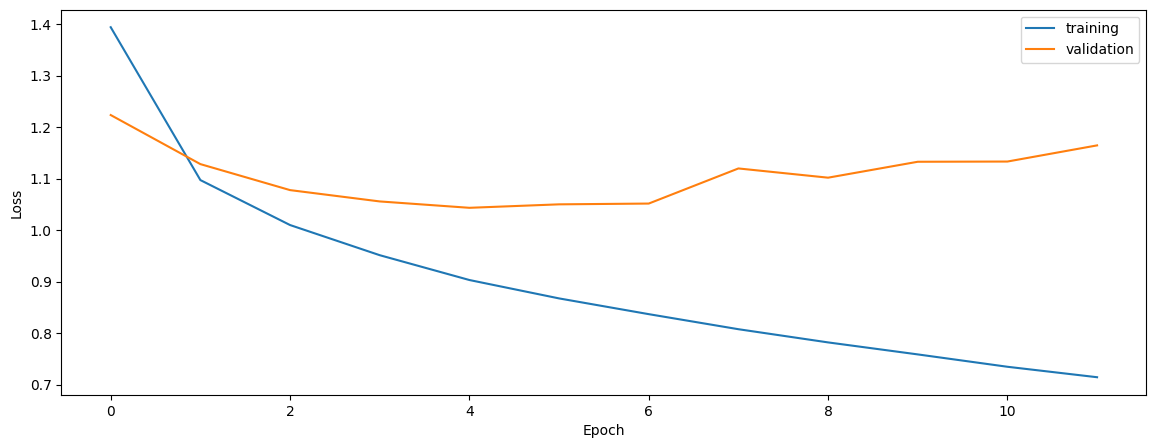

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6646425716195444
0.604458412559741
0.5967496078019117


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5967908790554081
0.5623880931065354
0.53351514838176


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6173323772217109
0.601881781051893
0.5756566497615624


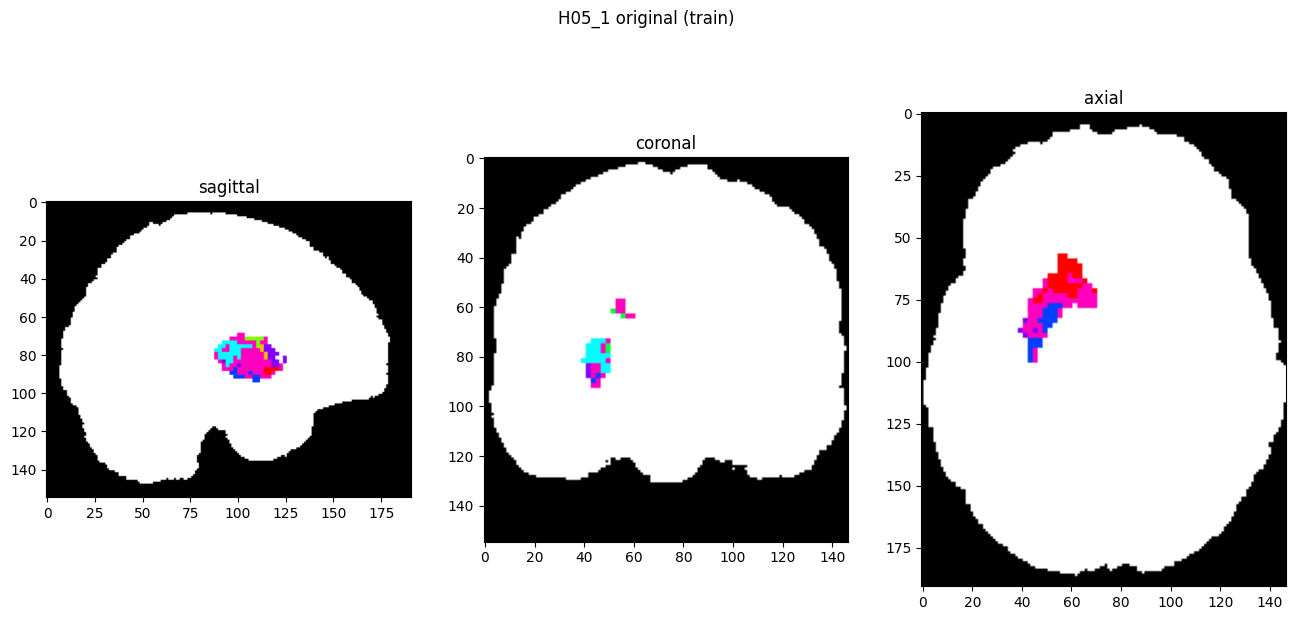

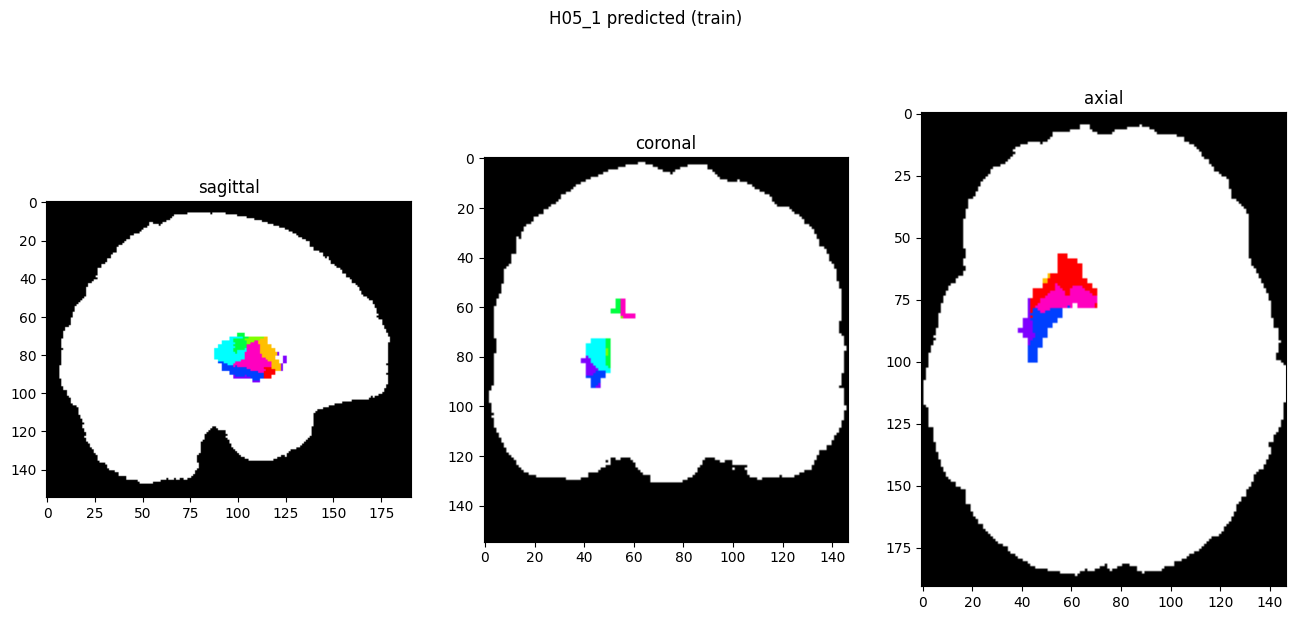

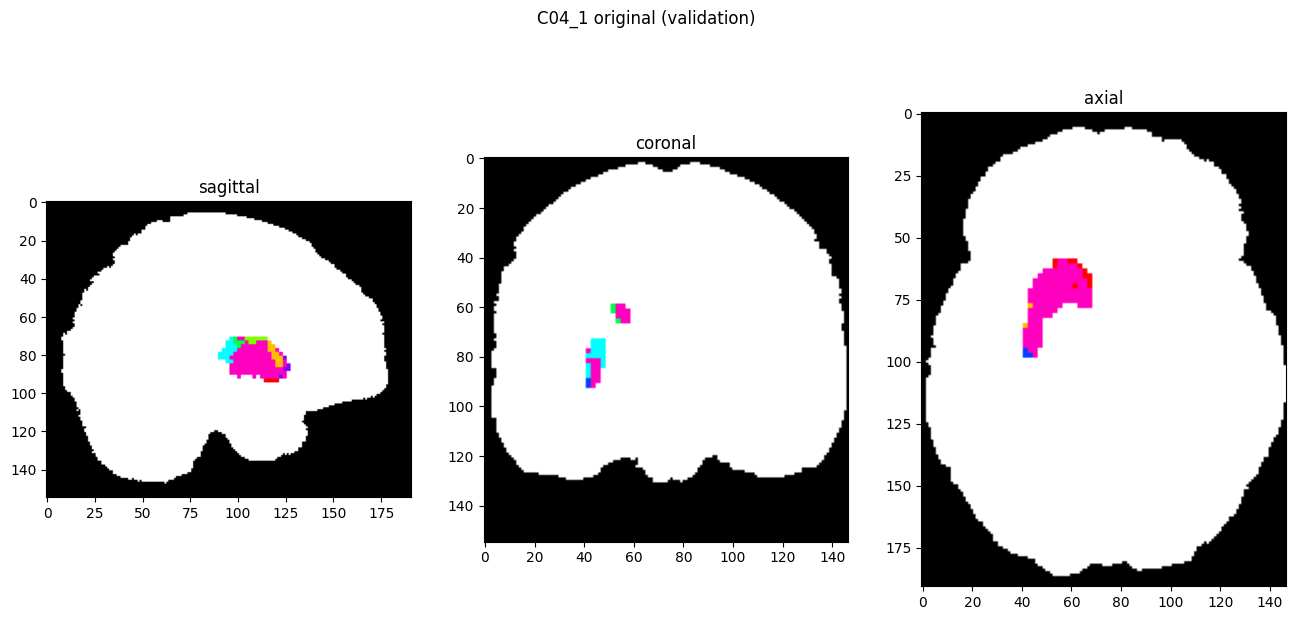

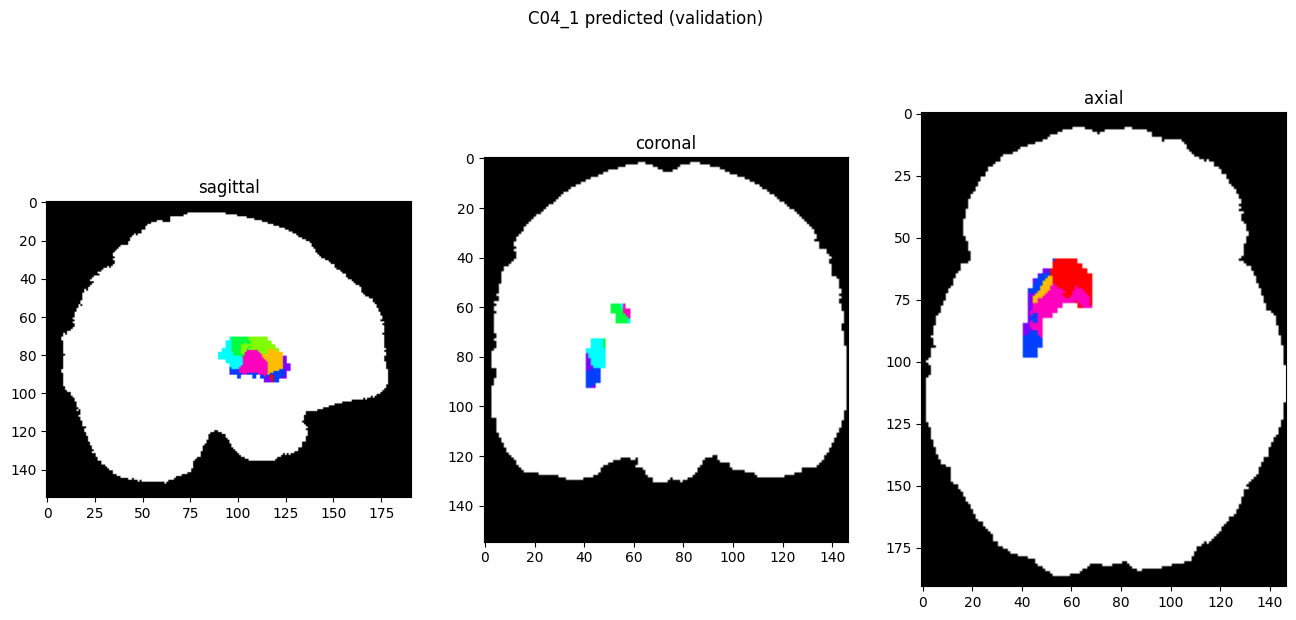

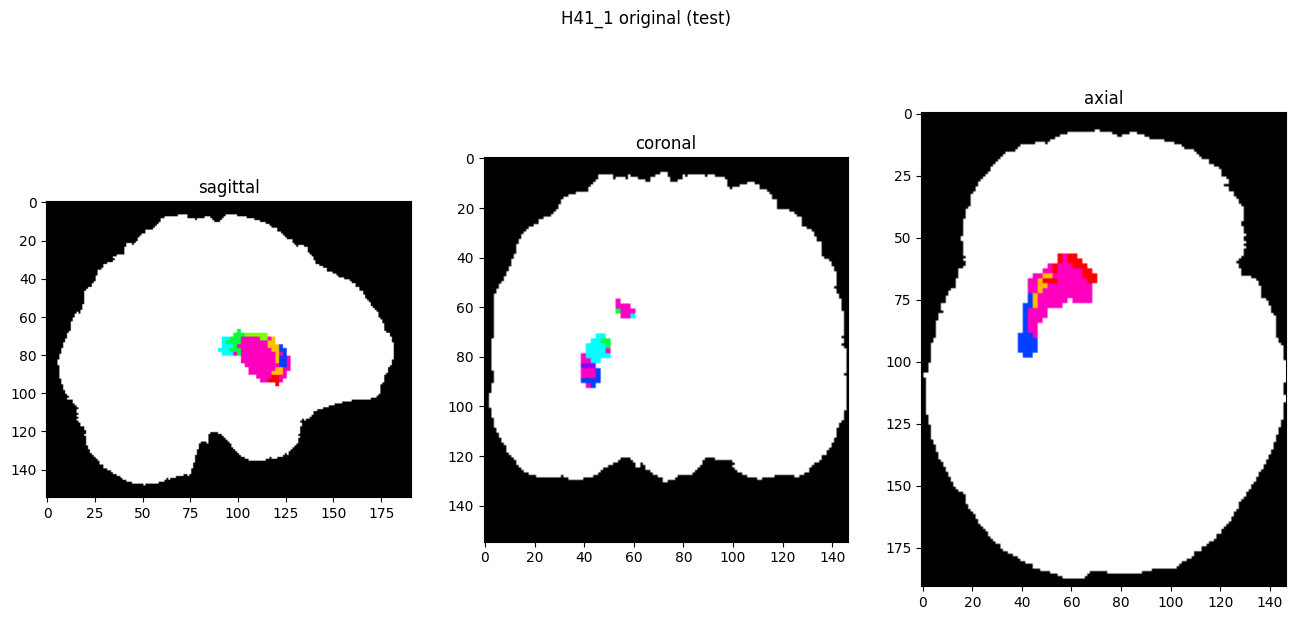

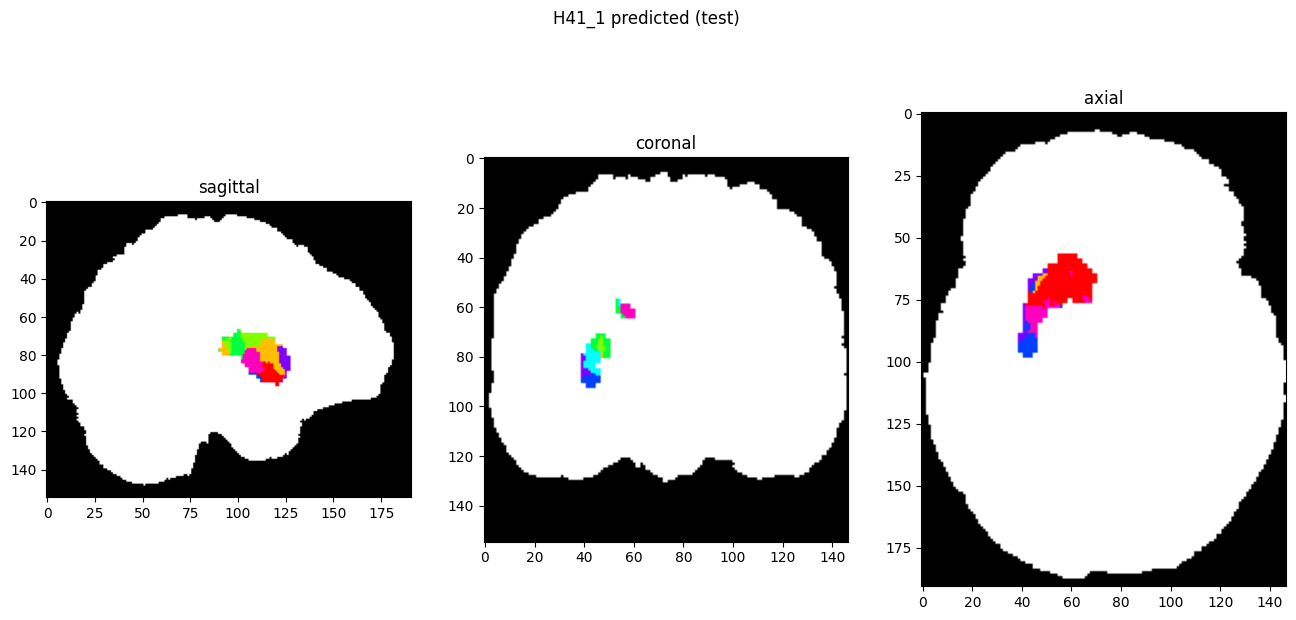

In [10]:
showResults(model, gen, threshold=0)